In [1]:
import random
import os
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
import lightgbm as lgb

import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import warnings

warnings.filterwarnings('ignore')

/Users/1233day/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import logging

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [3]:
train = pd.read_csv('../train.csv').drop(columns=['ID'])
test = pd.read_csv('../test.csv').drop(columns=['ID'])
train.shape, test.shape
# train.loc[train['시술 당시 나이'] == '알 수 없음', '시술 당시 나이'] = '만43-44세'

((256351, 68), (90067, 67))

In [4]:
train['임신 성공 여부'].value_counts()

임신 성공 여부
0    190123
1     66228
Name: count, dtype: int64

In [5]:
# train['시술 당시 나이'] = train['시술 당시 나이'].replace('알 수 없음','만35-37세')
# test['시술 당시 나이'] = test['시술 당시 나이'].replace('알 수 없음','만35-37세')

train['시술 당시 나이'].value_counts()
# train['']


시술 당시 나이
만18-34세    102476
만35-37세     57780
만38-39세     39247
만40-42세     37348
만43-44세     12253
만45-50세      6918
알 수 없음        329
Name: count, dtype: int64

In [6]:
# drop_columns = ['착상 전 유전 검사 사용 여부',
#                 'PGD 시술 여부', 'PGS 시술 여부', '난자 해동 경과일'] + ['배란 유도 유형', '불임 원인 - 자궁경부 문제', '불임 원인 - 정자 면역학적 요인','불임 원인 - 정자 운동성', '불임 원인 - 정자 형태']#
drop_columns = ['난자 해동 경과일', '배란 유도 유형']
train.drop(columns=drop_columns, inplace=True)
test.drop(columns=drop_columns, inplace=True)

train.shape, test.shape

((256351, 66), (90067, 65))

In [7]:
nan_col_list = ['착상 전 유전 검사 사용 여부','PGD 시술 여부', 'PGS 시술 여부']
for col in nan_col_list:
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)

In [8]:
drop_columns2 = []
for col in train.columns:
    if len(train[col].value_counts()) == 1:
        drop_columns2.append(col)

In [9]:
print(drop_columns2)
train.drop(columns=drop_columns2, inplace=True)
test.drop(columns=drop_columns2, inplace=True)

train.shape, test.shape

['불임 원인 - 여성 요인', '난자 채취 경과일']


((256351, 64), (90067, 63))

In [10]:
cat_to_int_dict = {'6회 이상' : 6, '5회' : 5, '4회' : 4, '3회' : 3, '2회' : 2, '1회' : 1, '0회' : 0}

cat_to_int_columns = ['총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수','DI 시술 횟수', 'DI 임신 횟수' ,'DI 출산 횟수',
                      '총 임신 횟수', 'IVF 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수'] #
for col in cat_to_int_columns:
    train[col] = train[col].map(cat_to_int_dict)
    test[col] = test[col].map(cat_to_int_dict)

In [11]:
# 5. Binning(구간화) 예시
# 예: 임신 시도 또는 마지막 임신 경과 연수
if '임신 시도 또는 마지막 임신 경과 연수' in train.columns:
    bins = [-0.1, 0.9, 3, 6, 10, 20]  # 0 이하, 1~3, 4~6, 7~10, 11~20
    labels = ['0년 이하','1~3년','4~6년','7~10년','11~20년']
    train['임신시도_bin'] = pd.cut(train['임신 시도 또는 마지막 임신 경과 연수'], bins=bins, labels=labels)
    test['임신시도_bin']  = pd.cut(test['임신 시도 또는 마지막 임신 경과 연수'],  bins=bins, labels=labels)

# 예: 총 생성 배아 수 (0~20, 21이상 구간)
if '총 생성 배아 수' in train.columns:
    bins = [-0.1, 0, 5, 10, 15, 20, 999]
    labels = ['0','1~5','6~10','11~15','16~20','21이상']
    train['총_생성_배아_bin'] = pd.cut(train['총 생성 배아 수'], bins=bins, labels=labels)
    test['총_생성_배아_bin']  = pd.cut(test['총 생성 배아 수'],  bins=bins, labels=labels)

# 6. 희소 범주(rare categories) 병합 예시
def merge_rare_categories(series, min_count=100):
    """
    시리즈 내에서 출현 횟수가 min_count 미만인 카테고리를
    모두 '기타' 카테고리로 통합
    """
    value_counts = series.value_counts(dropna=False)
    rare_cats = value_counts[value_counts < min_count].index
    return series.replace(rare_cats, '기타')


rare_merge_cols = ['특정 시술 유형', '배아 생성 주요 이유']
for col in rare_merge_cols:
    if col in train.columns:
        train[col] = merge_rare_categories(train[col], min_count=100)
    if col in test.columns:
        test[col] = merge_rare_categories(test[col], min_count=100)
train.drop(columns =['임신 시도 또는 마지막 임신 경과 연수'],inplace = True )
test.drop(columns =['임신 시도 또는 마지막 임신 경과 연수'],inplace = True )


In [12]:
procedure_encoding_dict = {'ICSI' : 'ICSI', 'IVF' : 'IVF', 'Unknown' : 'Unknown','IUI' : 'IUI',
                           'ICSI:ICSI' : 'ICSI', 'ICSI / BLASTOCYST ' : 'ICSI / BLASTOCYST',
                           'IVF / BLASTOCYST' : 'IVF / BLASTOCYST','IVF:IVF' : 'IVF','ICSI:IVF' : 'ICSI:IVF',
                           'ICSI / AH' : 'ICSI / AH','IVF:ICSI' : 'ICSI:IVF', 'IVF / AH' : 'IVF / AH',
                           'ICSI:Unknown' : 'ICSI', 'IVF:Unknown' : 'IVF', 'ICI' : 'ICI','Generic DI' : 'Generic DI',
                           'IVI' : 'IVI','ICSI / BLASTOCYST:IVF / BLASTOCYST' : 'ICSI / BLASTOCYST:IVF / BLASTOCYST',
                           'ICSI / BLASTOCYST :IVF / BLASTOCYST': 'ICSI / BLASTOCYST:IVF / BLASTOCYST','FER' : 'FER',
                           'IVF / AH:ICSI / AH' : 'IVF / AH:ICSI / AH','GIFT':'GIFT','ICSI / AH:Unknown' : 'ICSI / AH',
                           'ICSI / BLASTOCYST :ICSI' : 'ICSI / BLASTOCYST', 'IUI:ICI' : 'IUI:ICI',
                           'IVF:Unknown:Unknown:Unknown' : 'IVF'}

train['특정 시술 유형'] = train['특정 시술 유형'].map(procedure_encoding_dict)
test['특정 시술 유형'] = test['특정 시술 유형'].map(procedure_encoding_dict)

In [13]:
train['불임 원인 - 정자 요인'] = train['불임 원인 - 정자 면역학적 요인'] + train['불임 원인 - 정자 운동성'] + train['불임 원인 - 정자 농도']  + train['불임 원인 - 정자 형태']
test['불임 원인 - 정자 요인'] = test['불임 원인 - 정자 면역학적 요인'] + test['불임 원인 - 정자 운동성'] + test['불임 원인 - 정자 농도'] + test['불임 원인 - 정자 형태']
train['불임 원인 - 여성 요인'] = train['불임 원인 - 자궁경부 문제'] + train['불임 원인 - 자궁내막증'] + train['불임 원인 - 배란 장애'] + train['불임 원인 - 난관 질환']
test['불임 원인 - 여성 요인'] = test['불임 원인 - 자궁경부 문제'] + test['불임 원인 - 자궁내막증'] + test['불임 원인 - 배란 장애'] + test['불임 원인 - 난관 질환']

train['남성 불임 원인'] = train['남성 주 불임 원인'] + train['남성 부 불임 원인']
test['남성 불임 원인'] = test['남성 주 불임 원인'] + test['남성 부 불임 원인']
train['여성 불임 원인'] = train['여성 주 불임 원인'] + train['여성 부 불임 원인']
test['여성 불임 원인'] = test['여성 주 불임 원인'] + test['여성 부 불임 원인']
train['부부 불임 원인'] = train['부부 주 불임 원인'] + train['부부 부 불임 원인']
test['부부 불임 원인'] = test['부부 주 불임 원인'] + test['부부 부 불임 원인']


drop_columns3 = ['불임 원인 - 정자 면역학적 요인', '불임 원인 - 정자 운동성', '불임 원인 - 정자 형태', '불임 원인 - 자궁경부 문제',
                 '남성 주 불임 원인', '남성 부 불임 원인', '여성 주 불임 원인', '여성 부 불임 원인',
                 '부부 주 불임 원인', '부부 부 불임 원인']
train.drop(columns=drop_columns3, inplace=True)
test.drop(columns=drop_columns3, inplace=True)

In [14]:
train.drop(columns =['임신 시도 또는 마지막 임신 경과 연수'],inplace = True )
test.drop(columns =['임신 시도 또는 마지막 임신 경과 연수'],inplace = True )

KeyError: "['임신 시도 또는 마지막 임신 경과 연수'] not found in axis"

In [15]:
train.columns

Index(['시술 시기 코드', '시술 당시 나이', '시술 유형', '특정 시술 유형', '배란 자극 여부', '단일 배아 이식 여부',
       '착상 전 유전 검사 사용 여부', '착상 전 유전 진단 사용 여부', '불명확 불임 원인', '불임 원인 - 난관 질환',
       '불임 원인 - 남성 요인', '불임 원인 - 배란 장애', '불임 원인 - 자궁내막증', '불임 원인 - 정자 농도',
       '배아 생성 주요 이유', '총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수', 'DI 시술 횟수',
       '총 임신 횟수', 'IVF 임신 횟수', 'DI 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수', 'DI 출산 횟수',
       '총 생성 배아 수', '미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수',
       '미세주입 배아 이식 수', '저장된 배아 수', '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수',
       '수집된 신선 난자 수', '저장된 신선 난자 수', '혼합된 난자 수', '파트너 정자와 혼합된 난자 수',
       '기증자 정자와 혼합된 난자 수', '난자 출처', '정자 출처', '난자 기증자 나이', '정자 기증자 나이',
       '동결 배아 사용 여부', '신선 배아 사용 여부', '기증 배아 사용 여부', '대리모 여부', 'PGD 시술 여부',
       'PGS 시술 여부', '난자 혼합 경과일', '배아 이식 경과일', '배아 해동 경과일', '임신 성공 여부',
       '임신시도_bin', '총_생성_배아_bin', '불임 원인 - 정자 요인', '불임 원인 - 여성 요인', '남성 불임 원인',
       '여성 불임 원인', '부부 불임 원인'],
      dtype='object')

In [16]:
# categorical_columns = ["시술 시기 코드","시술 당시 나이", "시술 유형", "특정 시술 유형","배란 자극 여부",
                      #  "단일 배아 이식 여부","착상 전 유전 진단 사용 여부",
                      #  "남성 주 불임 원인","남성 부 불임 원인","여성 주 불임 원인","여성 부 불임 원인",
                      #  "부부 주 불임 원인","부부 부 불임 원인","불명확 불임 원인","불임 원인 - 난관 질환",
                      #  "불임 원인 - 남성 요인","불임 원인 - 배란 장애","불임 원인 - 자궁경부 문제","불임 원인 - 자궁내막증",
                      #  "불임 원인 - 정자 농도","불임 원인 - 정자 면역학적 요인","불임 원인 - 정자 운동성","불임 원인 - 정자 형태",
                      #  "배아 생성 주요 이유","총 시술 횟수","클리닉 내 총 시술 횟수","IVF 시술 횟수","DI 시술 횟수",
                      #  "총 임신 횟수","IVF 임신 횟수","DI 임신 횟수","총 출산 횟수","IVF 출산 횟수","DI 출산 횟수",
                      #  "난자 출처","정자 출처","난자 기증자 나이","정자 기증자 나이",
                      #  "동결 배아 사용 여부","신선 배아 사용 여부","기증 배아 사용 여부","대리모 여부"]
categorical_columns =  ["시술 시기 코드","시술 당시 나이","시술 유형", "특정 시술 유형",
                        "배란 자극 여부", "단일 배아 이식 여부", '착상 전 유전 검사 사용 여부',"착상 전 유전 진단 사용 여부",
                       "불명확 불임 원인","배아 생성 주요 이유",
                        "불임 원인 - 난관 질환","불임 원인 - 남성 요인","불임 원인 - 배란 장애",
                        "불임 원인 - 자궁내막증",'불임 원인 - 정자 농도',"난자 출처","정자 출처","난자 기증자 나이","정자 기증자 나이",
                       "동결 배아 사용 여부","신선 배아 사용 여부", '기증 배아 사용 여부',"대리모 여부",
                        'PGD 시술 여부', '총_생성_배아_bin','PGS 시술 여부', '불임 원인 - 정자 요인', '불임 원인 - 여성 요인',  '남성 불임 원인', '여성 불임 원인', '부부 불임 원인',"임신시도_bin"] #
# "남성 주 불임 원인","남성 부 불임 원인","여성 주 불임 원인","여성 부 불임 원인",
#                       "부부 주 불임 원인","부부 부 불임 원인",

for col in categorical_columns:
    if train[col].isna().sum() > 0 or test[col].isna().sum() > 0 :

      mode_value = train[col].mode()[0]
      train[col].fillna(mode_value, inplace=True)  # 최빈값으로 대체
      test[col].fillna(mode_value, inplace = True)
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)
    #encoder = ce.OrdinalEncoder(handle_unknown='impute')
    #encoder.fit(train[col])
    #train[col] = encoder.transform(train[col])
    #test[col] = encoder.transform(test[col])

numeric_columns = ["총 생성 배아 수", "총 시술 횟수","클리닉 내 총 시술 횟수","IVF 시술 횟수","DI 시술 횟수",
                   "총 임신 횟수","IVF 임신 횟수","DI 임신 횟수","총 출산 횟수","IVF 출산 횟수","DI 출산 횟수",
                    '미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수', '미세주입 배아 이식 수', '저장된 배아 수',
       '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수', '수집된 신선 난자 수', '저장된 신선 난자 수',
       '혼합된 난자 수', '파트너 정자와 혼합된 난자 수', '기증자 정자와 혼합된 난자 수', '난자 혼합 경과일', '배아 이식 경과일', '배아 해동 경과일'] #

# numeric_columns = ["총 생성 배아 수","미세주입된 난자 수","미세주입에서 생성된 배아 수",
#                    "이식된 배아 수","미세주입 배아 이식 수","저장된 배아 수","미세주입 후 저장된 배아 수",
#                    "수집된 신선 난자 수","혼합된 난자 수","파트너 정자와 혼합된 난자 수",
#                    "기증자 정자와 혼합된 난자 수","배아 이식 경과일"]

for col in numeric_columns:
  if train[col].isna().sum():
    if train[col].isna().sum() >= len(train)*0.5: # 결측치가 절반이 넘어갈 경우
      train[col].fillna(-1, inplace=True)  # -1로 대체
      test[col].fillna(-1, inplace = True)
    else:
      mode_value = train[col].mode()[0]  # 최빈값 구하기
      train[col].fillna(mode_value, inplace=True)  # 최빈값으로 대체
      test[col].fillna(mode_value, inplace = True)


In [17]:
len(categorical_columns) + len(numeric_columns)

59

In [18]:
def make_feature(df):
  
  df['미세주입 배아 생성률'] = (df['미세주입에서 생성된 배아 수']) / (df['미세주입된 난자 수'] + 1)
  # df['미세주입 배아 이식률'] = (df['미세주입 배아 이식 수']) / (df['미세주입에서 생성된 배아 수'] + 1)
  df['배아 이식률'] = (df['이식된 배아 수']) / (df['총 생성 배아 수'] + 1)
  df['저장 배아 비율'] = (df['저장된 배아 수'])/ (df['총 생성 배아 수'] + 1)
  df['해동 배아 생존율'] = (df['해동된 배아 수'])/ (df['총 생성 배아 수'] + 1)
  df['파트너 정자 혼합 비율'] = (df['파트너 정자와 혼합된 난자 수']) / (df['혼합된 난자 수'] + 1)


  df['임신 성공률'] = (df['총 임신 횟수']) / (df['총 시술 횟수'] + 1)

  df['출산율'] = df['총 출산 횟수'] / (df['총 임신 횟수'] + 1)

  return df

In [19]:
X = train.drop('임신 성공 여부', axis=1)
y = train['임신 성공 여부']

X = make_feature(X)
test = make_feature(test)

X.shape, test.shape

((256351, 66), (90067, 66))

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# 수치형 변수(정수, 실수)를 선택하여 스케일링
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
test[numeric_cols] = scaler.transform(test[numeric_cols])

X.shape, test.shape

((256351, 66), (90067, 66))

In [21]:
y.value_counts()

임신 성공 여부
0    190123
1     66228
Name: count, dtype: int64

In [22]:
if not os.path.exists('./weight'):
    os.makedirs('./weight')

In [23]:
from sklearn.utils.class_weight import compute_class_weight
def objective_cat(trial):
    global best_val_auc
    cbrm_param = {
        'iterations':trial.suggest_int("iterations", 1500, 3000),
        'depth':trial.suggest_int("depth", 4, 10),
        'learning_rate' : trial.suggest_float('learning_rate',0.005, 0.1),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-4, 100.0, log=True),
        'early_stopping_rounds': 300
    }

    # Generate model
    model_cat = CatBoostClassifier(**cbrm_param, auto_class_weights='Balanced', eval_metric='AUC', random_state=seed)
    model_cat.fit(X_train,
          y_train,
          cat_features=categorical_columns,
          early_stopping_rounds= 300,
          eval_set=[(X_val,y_val)],
          verbose = 300)
    
    val_auc = model_cat.get_best_score()["validation"]["AUC"]
    best_model_path = "./weight/cat_fold_cpu{}.cbm".format(idx)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        model_cat.save_model(best_model_path)
        print('저장 완료')

    return val_auc

def objective_lgbm(trial):

    lgbm_params = {
         #'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1),
         #'max_depth': trial.suggest_int('max_depth', 3, 18, step=1),
          "num_iterations": trial.suggest_int("num_iterations", 1500, 3000),
        "objective":  trial.suggest_categorical("objective", ["binary"]),
         "metric":  trial.suggest_categorical("metric", ["auc"]),
        #  "random_state":  trial.suggest_int('random_state', 42, 42),
        "random_state": seed,
        "verbose":  trial.suggest_int('verbose', -1, -1),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50, step=5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
    }

    # Generate model

    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    model_lgbm = lgb.LGBMClassifier(**lgbm_params, class_weight=class_weight_dict)

    model_lgbm.fit(X_train, y_train,eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    return model_lgbm.best_score_['valid_0']['auc']

In [24]:
for col in X.columns:
    if X[col].dtype == 'object':  # 문자형이면 category로 변환
        X[col] = X[col].astype('category')
        test[col] = test[col].astype('category')
seed = 4972

test_pred_total = []
scores_total = []
seed_everything(seed)
print('Seed {} Start!'.format(seed))
cv = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)

cat_param_list = []
lgbm_param_list = []
for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print('='*50)
    X_train, X_val = X.iloc[train_idx],X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    best_val_auc = 0

    sampler = TPESampler(seed=seed)
    optuna_cat = optuna.create_study(direction='maximize', sampler=sampler)
    optuna_cat.optimize(objective_cat, n_trials = 40)
    cat_trial = optuna_cat.best_trial
    cat_trial_params = cat_trial.params
    cat_param_list.append(cat_trial_params)
    
    model = CatBoostClassifier(**cat_trial_params, auto_class_weights='Balanced', eval_metric='AUC', random_state=seed)
    model.load_model("./weight/cat_fold_cpu{}.cbm".format(idx))
    #model = CatBoostClassifier(auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="CPU" )
    #model.fit(X_train,y_train,cat_features=categorical_columns,early_stopping_rounds = 300,eval_set=[(X_val,y_val)], verbose = 300)
    
    # model_cpu = CatBoostClassifier(auto_class_weights='Balanced',eval_metric='AUC', random_state = 501, task_type="cpu" )
    # model_cpu.fit(X_train,y_train,cat_features=categorical_columns, early_stopping_rounds = 300,eval_set=[(X_val,y_val)], verbose = 300)
    # model_cpu.save_model("cat_fold_{}.cbm".format(idx))


    sampler = TPESampler(seed=seed)
    optuna_lgbm = optuna.create_study(direction='maximize', sampler=sampler)
    optuna_lgbm.optimize(objective_lgbm, n_trials = 40)
    lgbm_trial = optuna_lgbm.best_trial
    lgbm_trial_params = lgbm_trial.params
    lgbm_param_list.append(lgbm_trial_params)
    
    # lgbm_trial_params =loaded_lgbm_params[idx]
    #print(lgbm_trial_params)

    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}
    model_lgbm = lgb.LGBMClassifier(**lgbm_trial_params,class_weight=class_weight_dict)
    # model_lgbm = lgb.LGBMClassifier(class_weight=class_weight_dict)
    #model_lgbm= lgb.LGBMClassifier(objective = 'binary', metric = 'auc', random_state =  seed, class_weight=class_weight_dict)
    model_lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    val_pred = model.predict_proba(X_val)[:, 1]
    val_pred_lgbm = model_lgbm.predict_proba(X_val)[:, 1]
    print('Cat val score : {}'.format(roc_auc_score(y_val,val_pred)))
    print('LGBM val score : {}'.format(roc_auc_score(y_val,val_pred_lgbm)))

    roc_val = roc_auc_score(y_val, (2*val_pred+val_pred_lgbm)/3)
    scores_total.append(roc_val)
    print('Ensemble val score : {}'.format(roc_val))

    test_pred = model.predict_proba(test)[:, 1]
    test_pred_lgbm = model_lgbm.predict_proba(test)[:, 1]
    test_pred_total.append((2*test_pred+test_pred_lgbm)/3)

[I 2025-02-25 00:41:13,285] A new study created in memory with name: no-name-7bf62ee0-d55c-4d38-9203-3d5cbda4e5a2


Seed 4972 Start!
0:	test: 0.7272418	best: 0.7272418 (0)	total: 182ms	remaining: 7m 9s
300:	test: 0.7387533	best: 0.7387533 (300)	total: 38.6s	remaining: 4m 24s
600:	test: 0.7401273	best: 0.7401273 (599)	total: 1m 17s	remaining: 3m 47s
900:	test: 0.7404869	best: 0.7404971 (892)	total: 1m 57s	remaining: 3m 10s
1200:	test: 0.7406387	best: 0.7406398 (1151)	total: 2m 39s	remaining: 2m 34s
1500:	test: 0.7407778	best: 0.7407807 (1498)	total: 3m 26s	remaining: 1m 59s
1800:	test: 0.7407631	best: 0.7408599 (1661)	total: 4m 16s	remaining: 1m 20s


[I 2025-02-25 00:45:56,184] Trial 0 finished with value: 0.7408599275340262 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7408599275340262.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408599275
bestIteration = 1661

Shrink model to first 1662 iterations.
저장 완료
0:	test: 0.7020597	best: 0.7020597 (0)	total: 46.6ms	remaining: 1m 42s
300:	test: 0.7304598	best: 0.7304598 (300)	total: 12.6s	remaining: 1m 19s
600:	test: 0.7342465	best: 0.7342465 (600)	total: 25.2s	remaining: 1m 6s
900:	test: 0.7362545	best: 0.7362545 (900)	total: 38.3s	remaining: 55s
1200:	test: 0.7372890	best: 0.7372890 (1200)	total: 51.7s	remaining: 42.7s
1500:	test: 0.7379821	best: 0.7379821 (1500)	total: 1m 5s	remaining: 30.1s
1800:	test: 0.7385205	best: 0.7385205 (1800)	total: 1m 19s	remaining: 17.2s
2100:	test: 0.7389667	best: 0.7389677 (2099)	total: 1m 33s	remaining: 4.07s


[I 2025-02-25 00:47:33,748] Trial 1 finished with value: 0.7390935399390067 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7408599275340262.


2192:	test: 0.7390935	best: 0.7390935 (2192)	total: 1m 37s	remaining: 0us

bestTest = 0.7390935399
bestIteration = 2192

0:	test: 0.7020597	best: 0.7020597 (0)	total: 48.7ms	remaining: 2m 3s
300:	test: 0.7406007	best: 0.7406007 (300)	total: 14.1s	remaining: 1m 44s
600:	test: 0.7405460	best: 0.7409809 (435)	total: 28.8s	remaining: 1m 32s


[I 2025-02-25 00:48:09,290] Trial 2 finished with value: 0.7409808703961456 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 2 with value: 0.7409808703961456.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409808704
bestIteration = 435

Shrink model to first 436 iterations.
저장 완료
0:	test: 0.7020597	best: 0.7020597 (0)	total: 46.5ms	remaining: 1m 48s
300:	test: 0.7394758	best: 0.7394758 (300)	total: 13.5s	remaining: 1m 31s
600:	test: 0.7406402	best: 0.7406402 (600)	total: 28s	remaining: 1m 20s
900:	test: 0.7408909	best: 0.7409412 (824)	total: 42.4s	remaining: 1m 7s
1200:	test: 0.7407996	best: 0.7409730 (1001)	total: 57.1s	remaining: 53.8s


[I 2025-02-25 00:49:11,486] Trial 3 finished with value: 0.7409729806602043 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 2 with value: 0.7409808703961456.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409729807
bestIteration = 1001

Shrink model to first 1002 iterations.
0:	test: 0.7272166	best: 0.7272166 (0)	total: 108ms	remaining: 3m 8s
300:	test: 0.7374358	best: 0.7374390 (299)	total: 36.3s	remaining: 2m 53s
600:	test: 0.7384627	best: 0.7385654 (541)	total: 1m 14s	remaining: 2m 20s
900:	test: 0.7383661	best: 0.7386106 (722)	total: 1m 52s	remaining: 1m 45s


[I 2025-02-25 00:51:20,975] Trial 4 finished with value: 0.7386106023327776 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 2 with value: 0.7409808703961456.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386106023
bestIteration = 722

Shrink model to first 723 iterations.
0:	test: 0.7020597	best: 0.7020597 (0)	total: 48.4ms	remaining: 1m 40s
300:	test: 0.7398059	best: 0.7398617 (282)	total: 13.8s	remaining: 1m 21s
600:	test: 0.7400772	best: 0.7401756 (508)	total: 28.2s	remaining: 1m 9s
900:	test: 0.7398277	best: 0.7401770 (669)	total: 42.9s	remaining: 56.3s


[I 2025-02-25 00:52:07,494] Trial 5 finished with value: 0.7401769948498488 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 2 with value: 0.7409808703961456.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7401769948
bestIteration = 669

Shrink model to first 670 iterations.
0:	test: 0.7058331	best: 0.7058331 (0)	total: 54.1ms	remaining: 1m 48s
300:	test: 0.7405333	best: 0.7405333 (300)	total: 16.8s	remaining: 1m 34s
600:	test: 0.7409200	best: 0.7409621 (463)	total: 34.6s	remaining: 1m 20s
900:	test: 0.7412129	best: 0.7412256 (892)	total: 52.8s	remaining: 1m 4s


[I 2025-02-25 00:53:18,118] Trial 6 finished with value: 0.7412255633892872 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7412255633892872.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412255634
bestIteration = 892

Shrink model to first 893 iterations.
저장 완료
0:	test: 0.7203908	best: 0.7203908 (0)	total: 68.2ms	remaining: 2m 11s
300:	test: 0.7398430	best: 0.7405819 (172)	total: 24s	remaining: 2m 9s


[I 2025-02-25 00:53:56,471] Trial 7 finished with value: 0.7405819245283981 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7412255633892872.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7405819245
bestIteration = 172

Shrink model to first 173 iterations.
0:	test: 0.7203906	best: 0.7203906 (0)	total: 68.3ms	remaining: 2m 9s
300:	test: 0.7409182	best: 0.7409862 (291)	total: 22.6s	remaining: 2m
600:	test: 0.7410555	best: 0.7412382 (424)	total: 47.3s	remaining: 1m 42s


[I 2025-02-25 00:54:54,337] Trial 8 finished with value: 0.7412381504365613 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 8 with value: 0.7412381504365613.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412381504
bestIteration = 424

Shrink model to first 425 iterations.
저장 완료
0:	test: 0.7205421	best: 0.7205421 (0)	total: 61.6ms	remaining: 2m 42s
300:	test: 0.7400631	best: 0.7400631 (300)	total: 19.3s	remaining: 2m 29s
600:	test: 0.7412886	best: 0.7413561 (556)	total: 40.4s	remaining: 2m 16s


[I 2025-02-25 00:55:52,886] Trial 9 finished with value: 0.7413560597011672 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 9 with value: 0.7413560597011672.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413560597
bestIteration = 556

Shrink model to first 557 iterations.
저장 완료
0:	test: 0.7205421	best: 0.7205421 (0)	total: 60.7ms	remaining: 2m 58s
300:	test: 0.7398618	best: 0.7398775 (293)	total: 19.4s	remaining: 2m 50s
600:	test: 0.7408346	best: 0.7408415 (594)	total: 40s	remaining: 2m 35s
900:	test: 0.7407958	best: 0.7409104 (674)	total: 1m 1s	remaining: 2m 19s


[I 2025-02-25 00:56:59,687] Trial 10 finished with value: 0.7409103591073469 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.032580115422505045, 'l2_leaf_reg': 0.05588195113566891}. Best is trial 9 with value: 0.7413560597011672.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409103591
bestIteration = 674

Shrink model to first 675 iterations.
0:	test: 0.7229789	best: 0.7229789 (0)	total: 78.2ms	remaining: 3m 34s
300:	test: 0.7409474	best: 0.7409562 (297)	total: 25.8s	remaining: 3m 29s
600:	test: 0.7407474	best: 0.7411766 (357)	total: 54.8s	remaining: 3m 15s


[I 2025-02-25 00:58:00,097] Trial 11 finished with value: 0.7411765771425305 and parameters: {'iterations': 2742, 'depth': 8, 'learning_rate': 0.05038072346939034, 'l2_leaf_reg': 1.9458284937024315}. Best is trial 9 with value: 0.7413560597011672.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411765771
bestIteration = 357

Shrink model to first 358 iterations.
0:	test: 0.7203907	best: 0.7203907 (0)	total: 69.6ms	remaining: 1m 48s
300:	test: 0.7400528	best: 0.7400613 (298)	total: 21.9s	remaining: 1m 31s
600:	test: 0.7410085	best: 0.7410181 (598)	total: 45.9s	remaining: 1m 13s
900:	test: 0.7408899	best: 0.7410588 (613)	total: 1m 11s	remaining: 52.4s


[I 2025-02-25 00:59:12,515] Trial 12 finished with value: 0.741058790968923 and parameters: {'iterations': 1565, 'depth': 7, 'learning_rate': 0.03421727225236856, 'l2_leaf_reg': 0.5279524076347274}. Best is trial 9 with value: 0.7413560597011672.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741058791
bestIteration = 613

Shrink model to first 614 iterations.
0:	test: 0.7229799	best: 0.7229799 (0)	total: 79.5ms	remaining: 3m 28s
300:	test: 0.7406651	best: 0.7408621 (255)	total: 26.5s	remaining: 3m 23s


[I 2025-02-25 01:00:03,333] Trial 13 finished with value: 0.7408621431720006 and parameters: {'iterations': 2621, 'depth': 8, 'learning_rate': 0.06513774410228096, 'l2_leaf_reg': 0.4450207665125896}. Best is trial 9 with value: 0.7413560597011672.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408621432
bestIteration = 255

Shrink model to first 256 iterations.
0:	test: 0.7205421	best: 0.7205421 (0)	total: 64.7ms	remaining: 3m 8s
300:	test: 0.7395747	best: 0.7395747 (300)	total: 19.4s	remaining: 2m 48s
600:	test: 0.7406534	best: 0.7407275 (562)	total: 40.2s	remaining: 2m 35s
900:	test: 0.7407041	best: 0.7408085 (710)	total: 1m 1s	remaining: 2m 17s


[I 2025-02-25 01:01:12,804] Trial 14 finished with value: 0.7408085429981357 and parameters: {'iterations': 2922, 'depth': 6, 'learning_rate': 0.032542601115978974, 'l2_leaf_reg': 0.0118311002022484}. Best is trial 9 with value: 0.7413560597011672.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.740808543
bestIteration = 710

Shrink model to first 711 iterations.
0:	test: 0.7229742	best: 0.7229742 (0)	total: 78.2ms	remaining: 2m 16s
300:	test: 0.7406276	best: 0.7407235 (290)	total: 26s	remaining: 2m 4s
600:	test: 0.7407665	best: 0.7409539 (506)	total: 54.4s	remaining: 1m 43s


[I 2025-02-25 01:02:27,466] Trial 15 finished with value: 0.740953937291521 and parameters: {'iterations': 1748, 'depth': 8, 'learning_rate': 0.05947895129861792, 'l2_leaf_reg': 4.722389127363701}. Best is trial 9 with value: 0.7413560597011672.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409539373
bestIteration = 506

Shrink model to first 507 iterations.
0:	test: 0.7205421	best: 0.7205421 (0)	total: 60.7ms	remaining: 2m 29s
300:	test: 0.7404476	best: 0.7404476 (300)	total: 19.4s	remaining: 2m 20s
600:	test: 0.7413007	best: 0.7413568 (510)	total: 40.6s	remaining: 2m 6s
900:	test: 0.7409934	best: 0.7414391 (670)	total: 1m 2s	remaining: 1m 48s


[I 2025-02-25 01:03:35,099] Trial 16 finished with value: 0.7414391342131756 and parameters: {'iterations': 2470, 'depth': 6, 'learning_rate': 0.04499426597359756, 'l2_leaf_reg': 0.3606784305013277}. Best is trial 16 with value: 0.7414391342131756.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414391342
bestIteration = 670

Shrink model to first 671 iterations.
저장 완료
0:	test: 0.7205421	best: 0.7205421 (0)	total: 61.7ms	remaining: 2m 35s
300:	test: 0.7387976	best: 0.7387980 (299)	total: 18.9s	remaining: 2m 19s
600:	test: 0.7403603	best: 0.7403974 (589)	total: 38.8s	remaining: 2m 4s
900:	test: 0.7407708	best: 0.7408056 (830)	total: 1m	remaining: 1m 48s
1200:	test: 0.7407973	best: 0.7408484 (1180)	total: 1m 21s	remaining: 1m 30s


[I 2025-02-25 01:05:17,046] Trial 17 finished with value: 0.7408483966869335 and parameters: {'iterations': 2529, 'depth': 6, 'learning_rate': 0.022992108537592242, 'l2_leaf_reg': 0.01727718624367702}. Best is trial 16 with value: 0.7414391342131756.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408483967
bestIteration = 1180

Shrink model to first 1181 iterations.
0:	test: 0.7058136	best: 0.7058136 (0)	total: 56.1ms	remaining: 2m 32s
300:	test: 0.7394516	best: 0.7394516 (300)	total: 16.4s	remaining: 2m 11s
600:	test: 0.7408067	best: 0.7408067 (600)	total: 34.1s	remaining: 1m 59s
900:	test: 0.7408704	best: 0.7409378 (650)	total: 52s	remaining: 1m 44s


[I 2025-02-25 01:06:12,266] Trial 18 finished with value: 0.740937840165449 and parameters: {'iterations': 2714, 'depth': 5, 'learning_rate': 0.04013382538222858, 'l2_leaf_reg': 0.18325846027435616}. Best is trial 16 with value: 0.7414391342131756.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409378402
bestIteration = 650

Shrink model to first 651 iterations.
0:	test: 0.7058334	best: 0.7058334 (0)	total: 53.8ms	remaining: 2m 9s
300:	test: 0.7386729	best: 0.7386729 (300)	total: 16.5s	remaining: 1m 55s
600:	test: 0.7402487	best: 0.7402487 (600)	total: 33.5s	remaining: 1m 40s
900:	test: 0.7406601	best: 0.7406781 (889)	total: 51.1s	remaining: 1m 25s
1200:	test: 0.7408796	best: 0.7408842 (1138)	total: 1m 8s	remaining: 1m 9s
1500:	test: 0.7410614	best: 0.7410620 (1472)	total: 1m 26s	remaining: 52.6s
1800:	test: 0.7411429	best: 0.7411436 (1799)	total: 1m 44s	remaining: 35.5s
2100:	test: 0.7411671	best: 0.7411757 (2016)	total: 2m 2s	remaining: 18.2s
2400:	test: 0.7412375	best: 0.7412375 (2400)	total: 2m 21s	remaining: 646ms


[I 2025-02-25 01:08:34,345] Trial 19 finished with value: 0.7412377493981466 and parameters: {'iterations': 2412, 'depth': 5, 'learning_rate': 0.02422108148323666, 'l2_leaf_reg': 26.173311383243348}. Best is trial 16 with value: 0.7414391342131756.


2411:	test: 0.7412314	best: 0.7412377 (2404)	total: 2m 21s	remaining: 0us

bestTest = 0.7412377494
bestIteration = 2404

Shrink model to first 2405 iterations.
0:	test: 0.7205421	best: 0.7205421 (0)	total: 62.5ms	remaining: 2m 18s
300:	test: 0.7404192	best: 0.7406563 (246)	total: 20.4s	remaining: 2m 9s


[I 2025-02-25 01:09:12,520] Trial 20 finished with value: 0.7406562675208621 and parameters: {'iterations': 2212, 'depth': 6, 'learning_rate': 0.07678055128538461, 'l2_leaf_reg': 0.012990508780008181}. Best is trial 16 with value: 0.7414391342131756.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7406562675
bestIteration = 246

Shrink model to first 247 iterations.
0:	test: 0.7203905	best: 0.7203905 (0)	total: 69.4ms	remaining: 3m 13s
300:	test: 0.7405330	best: 0.7405371 (299)	total: 22.3s	remaining: 3m 4s
600:	test: 0.7406715	best: 0.7408030 (494)	total: 47s	remaining: 2m 50s


[I 2025-02-25 01:10:16,346] Trial 21 finished with value: 0.7408030316979413 and parameters: {'iterations': 2786, 'depth': 7, 'learning_rate': 0.0518710297206485, 'l2_leaf_reg': 1.4420330189886643}. Best is trial 16 with value: 0.7414391342131756.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408030317
bestIteration = 494

Shrink model to first 495 iterations.
0:	test: 0.7268233	best: 0.7268233 (0)	total: 89.6ms	remaining: 3m 40s
300:	test: 0.7404747	best: 0.7405059 (297)	total: 28.8s	remaining: 3m 26s
600:	test: 0.7399164	best: 0.7405524 (358)	total: 1m 1s	remaining: 3m 11s


[I 2025-02-25 01:11:24,707] Trial 22 finished with value: 0.7405524263661903 and parameters: {'iterations': 2462, 'depth': 9, 'learning_rate': 0.04504888126578593, 'l2_leaf_reg': 0.4123065272019256}. Best is trial 16 with value: 0.7414391342131756.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7405524264
bestIteration = 358

Shrink model to first 359 iterations.
0:	test: 0.7203904	best: 0.7203904 (0)	total: 67.6ms	remaining: 2m
300:	test: 0.7408063	best: 0.7408063 (300)	total: 22.9s	remaining: 1m 53s
600:	test: 0.7410281	best: 0.7411352 (512)	total: 47.6s	remaining: 1m 34s


[I 2025-02-25 01:12:30,108] Trial 23 finished with value: 0.7411351947429439 and parameters: {'iterations': 1790, 'depth': 7, 'learning_rate': 0.05720809779669189, 'l2_leaf_reg': 2.1046968968560367}. Best is trial 16 with value: 0.7414391342131756.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411351947
bestIteration = 512

Shrink model to first 513 iterations.
0:	test: 0.7205421	best: 0.7205421 (0)	total: 61.4ms	remaining: 2m 9s
300:	test: 0.7403117	best: 0.7403117 (300)	total: 19.5s	remaining: 1m 57s
600:	test: 0.7408934	best: 0.7409283 (547)	total: 40.8s	remaining: 1m 42s
900:	test: 0.7407218	best: 0.7409467 (689)	total: 1m 2s	remaining: 1m 23s


[I 2025-02-25 01:13:39,683] Trial 24 finished with value: 0.7409467106587013 and parameters: {'iterations': 2112, 'depth': 6, 'learning_rate': 0.04149861656954927, 'l2_leaf_reg': 0.14286929338183368}. Best is trial 16 with value: 0.7414391342131756.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409467107
bestIteration = 689

Shrink model to first 690 iterations.
0:	test: 0.7058128	best: 0.7058128 (0)	total: 53.2ms	remaining: 2m 19s
300:	test: 0.7404273	best: 0.7404528 (298)	total: 17s	remaining: 2m 11s
600:	test: 0.7411315	best: 0.7411791 (573)	total: 34.9s	remaining: 1m 57s


[I 2025-02-25 01:14:32,506] Trial 25 finished with value: 0.7411790667572437 and parameters: {'iterations': 2623, 'depth': 5, 'learning_rate': 0.0633290210296596, 'l2_leaf_reg': 8.754309211896855}. Best is trial 16 with value: 0.7414391342131756.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411790668
bestIteration = 573

Shrink model to first 574 iterations.
0:	test: 0.7229798	best: 0.7229798 (0)	total: 134ms	remaining: 6m 17s
300:	test: 0.7395917	best: 0.7395968 (294)	total: 25.8s	remaining: 3m 35s
600:	test: 0.7407119	best: 0.7407119 (600)	total: 51.6s	remaining: 3m 10s
900:	test: 0.7407953	best: 0.7408954 (727)	total: 1m 20s	remaining: 2m 51s


[I 2025-02-25 01:16:05,172] Trial 26 finished with value: 0.7408954174483905 and parameters: {'iterations': 2820, 'depth': 8, 'learning_rate': 0.02262957131029208, 'l2_leaf_reg': 0.8191130775375889}. Best is trial 16 with value: 0.7414391342131756.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408954174
bestIteration = 727

Shrink model to first 728 iterations.
0:	test: 0.7203908	best: 0.7203908 (0)	total: 70ms	remaining: 1m 53s
300:	test: 0.7397737	best: 0.7397807 (299)	total: 21.9s	remaining: 1m 35s
600:	test: 0.7402914	best: 0.7404476 (451)	total: 46.2s	remaining: 1m 18s


[I 2025-02-25 01:17:04,258] Trial 27 finished with value: 0.7404476123955621 and parameters: {'iterations': 1617, 'depth': 7, 'learning_rate': 0.03579918379077985, 'l2_leaf_reg': 0.050524605467255276}. Best is trial 16 with value: 0.7414391342131756.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7404476124
bestIteration = 451

Shrink model to first 452 iterations.
0:	test: 0.7268233	best: 0.7268233 (0)	total: 90.7ms	remaining: 2m 51s
300:	test: 0.7394081	best: 0.7397550 (250)	total: 29s	remaining: 2m 33s


[I 2025-02-25 01:18:00,713] Trial 28 finished with value: 0.739754975375884 and parameters: {'iterations': 1891, 'depth': 9, 'learning_rate': 0.054739269916572714, 'l2_leaf_reg': 0.15213939094456283}. Best is trial 16 with value: 0.7414391342131756.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7397549754
bestIteration = 250

Shrink model to first 251 iterations.
0:	test: 0.7205563	best: 0.7205563 (0)	total: 61.7ms	remaining: 2m 24s
300:	test: 0.7392786	best: 0.7392809 (297)	total: 18.8s	remaining: 2m 6s
600:	test: 0.7406618	best: 0.7406618 (600)	total: 38.8s	remaining: 1m 51s
900:	test: 0.7411308	best: 0.7411314 (897)	total: 59.8s	remaining: 1m 35s
1200:	test: 0.7411764	best: 0.7411849 (1045)	total: 1m 21s	remaining: 1m 16s
1500:	test: 0.7412308	best: 0.7412390 (1326)	total: 1m 42s	remaining: 56.9s


[I 2025-02-25 01:19:52,179] Trial 29 finished with value: 0.7412390478096478 and parameters: {'iterations': 2336, 'depth': 6, 'learning_rate': 0.02641950626531359, 'l2_leaf_reg': 7.3194928918531454}. Best is trial 16 with value: 0.7414391342131756.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412390478
bestIteration = 1326

Shrink model to first 1327 iterations.
0:	test: 0.7058334	best: 0.7058334 (0)	total: 53.6ms	remaining: 2m 3s
300:	test: 0.7388335	best: 0.7388351 (299)	total: 16.3s	remaining: 1m 48s
600:	test: 0.7403832	best: 0.7403832 (598)	total: 33.1s	remaining: 1m 34s
900:	test: 0.7408237	best: 0.7408237 (899)	total: 50.5s	remaining: 1m 18s
1200:	test: 0.7411226	best: 0.7411226 (1200)	total: 1m 8s	remaining: 1m 2s
1500:	test: 0.7412928	best: 0.7412928 (1500)	total: 1m 26s	remaining: 46.4s
1800:	test: 0.7413242	best: 0.7413276 (1551)	total: 1m 44s	remaining: 29.4s
2100:	test: 0.7413303	best: 0.7413685 (2046)	total: 2m 2s	remaining: 12.1s


[I 2025-02-25 01:22:07,460] Trial 30 finished with value: 0.7413684839506689 and parameters: {'iterations': 2309, 'depth': 5, 'learning_rate': 0.026827869116241847, 'l2_leaf_reg': 24.46302903280327}. Best is trial 16 with value: 0.7414391342131756.


2308:	test: 0.7413480	best: 0.7413685 (2046)	total: 2m 14s	remaining: 0us

bestTest = 0.741368484
bestIteration = 2046

Shrink model to first 2047 iterations.
0:	test: 0.7058384	best: 0.7058384 (0)	total: 52.8ms	remaining: 2m 1s
300:	test: 0.7372280	best: 0.7372280 (300)	total: 16.2s	remaining: 1m 47s
600:	test: 0.7391861	best: 0.7391861 (599)	total: 33.2s	remaining: 1m 34s
900:	test: 0.7399906	best: 0.7399906 (899)	total: 50.2s	remaining: 1m 18s
1200:	test: 0.7403957	best: 0.7403957 (1198)	total: 1m 7s	remaining: 1m 2s
1500:	test: 0.7406689	best: 0.7406703 (1495)	total: 1m 25s	remaining: 45.8s
1800:	test: 0.7408503	best: 0.7408635 (1787)	total: 1m 43s	remaining: 28.9s
2100:	test: 0.7409408	best: 0.7409415 (2082)	total: 2m	remaining: 11.8s


[I 2025-02-25 01:24:20,509] Trial 31 finished with value: 0.7409809220149514 and parameters: {'iterations': 2306, 'depth': 5, 'learning_rate': 0.01692675790264013, 'l2_leaf_reg': 23.882694427061526}. Best is trial 16 with value: 0.7414391342131756.


2305:	test: 0.7409699	best: 0.7409809 (2286)	total: 2m 12s	remaining: 0us

bestTest = 0.740980922
bestIteration = 2286

Shrink model to first 2287 iterations.
0:	test: 0.7205299	best: 0.7205299 (0)	total: 61.5ms	remaining: 2m 18s
300:	test: 0.7396345	best: 0.7396345 (300)	total: 19.1s	remaining: 2m 4s
600:	test: 0.7406105	best: 0.7406105 (599)	total: 38.3s	remaining: 1m 45s
900:	test: 0.7410271	best: 0.7410282 (899)	total: 58.7s	remaining: 1m 28s
1200:	test: 0.7412288	best: 0.7412403 (1160)	total: 1m 18s	remaining: 1m 9s
1500:	test: 0.7413848	best: 0.7413848 (1500)	total: 1m 39s	remaining: 50.2s
1800:	test: 0.7414372	best: 0.7414439 (1739)	total: 2m	remaining: 30.5s
2100:	test: 0.7414729	best: 0.7414740 (2086)	total: 2m 21s	remaining: 10.6s


[I 2025-02-25 01:26:53,180] Trial 32 finished with value: 0.7415443253981543 and parameters: {'iterations': 2258, 'depth': 6, 'learning_rate': 0.027694777099947766, 'l2_leaf_reg': 87.0680682791675}. Best is trial 32 with value: 0.7415443253981543.


2257:	test: 0.7415443	best: 0.7415443 (2255)	total: 2m 32s	remaining: 0us

bestTest = 0.7415443254
bestIteration = 2255

Shrink model to first 2256 iterations.
저장 완료
0:	test: 0.7058335	best: 0.7058335 (0)	total: 55.5ms	remaining: 2m 17s
300:	test: 0.7324377	best: 0.7324377 (300)	total: 15.8s	remaining: 1m 54s
600:	test: 0.7359398	best: 0.7359398 (600)	total: 31.6s	remaining: 1m 38s
900:	test: 0.7376610	best: 0.7376610 (900)	total: 47.8s	remaining: 1m 23s
1200:	test: 0.7385327	best: 0.7385327 (1200)	total: 1m 4s	remaining: 1m 8s
1500:	test: 0.7391013	best: 0.7391013 (1500)	total: 1m 20s	remaining: 52.6s
1800:	test: 0.7395271	best: 0.7395271 (1800)	total: 1m 37s	remaining: 36.7s
2100:	test: 0.7399318	best: 0.7399318 (2100)	total: 1m 54s	remaining: 20.5s
2400:	test: 0.7401672	best: 0.7401672 (2399)	total: 2m 11s	remaining: 4.22s


[I 2025-02-25 01:29:09,608] Trial 33 finished with value: 0.7402170947206437 and parameters: {'iterations': 2478, 'depth': 5, 'learning_rate': 0.006101886111858596, 'l2_leaf_reg': 42.764369076253296}. Best is trial 32 with value: 0.7415443253981543.


2477:	test: 0.7402171	best: 0.7402171 (2477)	total: 2m 16s	remaining: 0us

bestTest = 0.7402170947
bestIteration = 2477

0:	test: 0.7205259	best: 0.7205259 (0)	total: 64.3ms	remaining: 2m 48s
300:	test: 0.7395784	best: 0.7395784 (300)	total: 18.9s	remaining: 2m 25s
600:	test: 0.7407236	best: 0.7407279 (597)	total: 38.2s	remaining: 2m 8s
900:	test: 0.7411198	best: 0.7411198 (900)	total: 58.5s	remaining: 1m 51s
1200:	test: 0.7413170	best: 0.7413447 (1157)	total: 1m 18s	remaining: 1m 32s
1500:	test: 0.7415115	best: 0.7415126 (1460)	total: 1m 39s	remaining: 1m 14s
1800:	test: 0.7415576	best: 0.7415661 (1711)	total: 2m	remaining: 54.7s
2100:	test: 0.7416922	best: 0.7416954 (2077)	total: 2m 22s	remaining: 35s
2400:	test: 0.7417164	best: 0.7417467 (2302)	total: 2m 43s	remaining: 14.7s


[I 2025-02-25 01:32:08,434] Trial 34 finished with value: 0.7417466750877851 and parameters: {'iterations': 2617, 'depth': 6, 'learning_rate': 0.028598458149083638, 'l2_leaf_reg': 79.84130011156066}. Best is trial 34 with value: 0.7417466750877851.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417466751
bestIteration = 2302

Shrink model to first 2303 iterations.
저장 완료
0:	test: 0.7020597	best: 0.7020597 (0)	total: 49.7ms	remaining: 1m 52s
300:	test: 0.7360842	best: 0.7360842 (300)	total: 13.1s	remaining: 1m 25s
600:	test: 0.7384484	best: 0.7384484 (600)	total: 27.5s	remaining: 1m 15s
900:	test: 0.7394250	best: 0.7394250 (900)	total: 41.7s	remaining: 1m 2s
1200:	test: 0.7399235	best: 0.7399241 (1192)	total: 55.8s	remaining: 49.1s
1500:	test: 0.7402158	best: 0.7402169 (1499)	total: 1m 10s	remaining: 35.5s
1800:	test: 0.7404032	best: 0.7404042 (1779)	total: 1m 24s	remaining: 21.3s
2100:	test: 0.7405156	best: 0.7405156 (2100)	total: 1m 38s	remaining: 7.33s


[I 2025-02-25 01:33:54,224] Trial 35 finished with value: 0.7405650015014322 and parameters: {'iterations': 2258, 'depth': 4, 'learning_rate': 0.016700470355342622, 'l2_leaf_reg': 88.28002203659814}. Best is trial 34 with value: 0.7417466750877851.


2257:	test: 0.7405637	best: 0.7405650 (2253)	total: 1m 45s	remaining: 0us

bestTest = 0.7405650015
bestIteration = 2253

Shrink model to first 2254 iterations.
0:	test: 0.7058128	best: 0.7058128 (0)	total: 53.9ms	remaining: 1m 56s
300:	test: 0.7388581	best: 0.7388612 (299)	total: 16.5s	remaining: 1m 42s
600:	test: 0.7403723	best: 0.7403815 (599)	total: 34.2s	remaining: 1m 29s
900:	test: 0.7409630	best: 0.7409630 (900)	total: 52.1s	remaining: 1m 13s
1200:	test: 0.7410232	best: 0.7410803 (1047)	total: 1m 9s	remaining: 56.3s


[I 2025-02-25 01:35:13,147] Trial 36 finished with value: 0.741080276304191 and parameters: {'iterations': 2169, 'depth': 5, 'learning_rate': 0.029066492223718637, 'l2_leaf_reg': 18.61860253365674}. Best is trial 34 with value: 0.7417466750877851.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7410802763
bestIteration = 1047

Shrink model to first 1048 iterations.
0:	test: 0.7020597	best: 0.7020597 (0)	total: 47.1ms	remaining: 1m 52s
300:	test: 0.7357816	best: 0.7357829 (299)	total: 13.1s	remaining: 1m 30s
600:	test: 0.7383362	best: 0.7383362 (600)	total: 26.8s	remaining: 1m 19s
900:	test: 0.7395271	best: 0.7395271 (900)	total: 41s	remaining: 1m 7s
1200:	test: 0.7400596	best: 0.7400596 (1200)	total: 55.4s	remaining: 54.4s
1500:	test: 0.7404353	best: 0.7404358 (1499)	total: 1m 9s	remaining: 40.9s
1800:	test: 0.7406612	best: 0.7406612 (1800)	total: 1m 24s	remaining: 27.1s
2100:	test: 0.7407899	best: 0.7407955 (2093)	total: 1m 39s	remaining: 13.1s


[I 2025-02-25 01:37:06,158] Trial 37 finished with value: 0.7408361153818173 and parameters: {'iterations': 2379, 'depth': 4, 'learning_rate': 0.01619145625145554, 'l2_leaf_reg': 4.377674014323893}. Best is trial 34 with value: 0.7417466750877851.


2378:	test: 0.7408333	best: 0.7408361 (2363)	total: 1m 52s	remaining: 0us

bestTest = 0.7408361154
bestIteration = 2363

Shrink model to first 2364 iterations.
0:	test: 0.7205299	best: 0.7205299 (0)	total: 64.6ms	remaining: 2m 45s
300:	test: 0.7368286	best: 0.7368286 (300)	total: 18.5s	remaining: 2m 19s
600:	test: 0.7391565	best: 0.7391565 (600)	total: 37.7s	remaining: 2m 3s
900:	test: 0.7400132	best: 0.7400132 (899)	total: 57s	remaining: 1m 45s
1200:	test: 0.7405167	best: 0.7405179 (1199)	total: 1m 16s	remaining: 1m 27s
1500:	test: 0.7406945	best: 0.7406945 (1500)	total: 1m 37s	remaining: 1m 9s
1800:	test: 0.7409132	best: 0.7409135 (1790)	total: 1m 57s	remaining: 50.3s
2100:	test: 0.7410569	best: 0.7410621 (2097)	total: 2m 18s	remaining: 30.8s
2400:	test: 0.7411559	best: 0.7411559 (2398)	total: 2m 39s	remaining: 11.1s


[I 2025-02-25 01:39:57,275] Trial 38 finished with value: 0.7412448172038714 and parameters: {'iterations': 2569, 'depth': 6, 'learning_rate': 0.011596950897018232, 'l2_leaf_reg': 84.97685955126057}. Best is trial 34 with value: 0.7417466750877851.


2568:	test: 0.7412448	best: 0.7412448 (2568)	total: 2m 50s	remaining: 0us

bestTest = 0.7412448172
bestIteration = 2568

0:	test: 0.7058128	best: 0.7058128 (0)	total: 56.5ms	remaining: 1m 55s
300:	test: 0.7400260	best: 0.7400260 (300)	total: 16.8s	remaining: 1m 37s
600:	test: 0.7408482	best: 0.7408482 (600)	total: 34.4s	remaining: 1m 22s
900:	test: 0.7410066	best: 0.7410201 (882)	total: 52.3s	remaining: 1m 6s
1200:	test: 0.7410631	best: 0.7411030 (1015)	total: 1m 10s	remaining: 49.8s


[I 2025-02-25 01:41:15,240] Trial 39 finished with value: 0.7411029647547032 and parameters: {'iterations': 2046, 'depth': 5, 'learning_rate': 0.04586161155993301, 'l2_leaf_reg': 15.743703749705348}. Best is trial 34 with value: 0.7417466750877851.
[I 2025-02-25 01:41:15,246] A new study created in memory with name: no-name-6c086780-5c18-4817-8b8b-2eb83ef14663


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411029648
bestIteration = 1015

Shrink model to first 1016 iterations.


[I 2025-02-25 01:41:38,199] Trial 0 finished with value: 0.7312063730261277 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7312063730261277.
[I 2025-02-25 01:41:55,047] Trial 1 finished with value: 0.7407665451435562 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7407665451435562.
[I 2025-02-25 01:42:14,499] Trial 2 finished with value: 0.7404826814181249 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.741746675087785
LGBM val score : 0.7408268200260859
Ensemble val score : 0.7416461613607523


[I 2025-02-25 01:55:00,169] A new study created in memory with name: no-name-1be95046-e83d-4376-a1ee-9b0b48bd0c97


0:	test: 0.7189181	best: 0.7189181 (0)	total: 142ms	remaining: 5m 35s
300:	test: 0.7330032	best: 0.7330199 (297)	total: 37.8s	remaining: 4m 19s
600:	test: 0.7343455	best: 0.7343466 (591)	total: 1m 17s	remaining: 3m 48s
900:	test: 0.7347520	best: 0.7347520 (900)	total: 1m 58s	remaining: 3m 11s
1200:	test: 0.7349292	best: 0.7349364 (1199)	total: 2m 40s	remaining: 2m 36s
1500:	test: 0.7349034	best: 0.7350006 (1309)	total: 3m 30s	remaining: 2m 1s


[I 2025-02-25 01:58:48,601] Trial 0 finished with value: 0.7350006377076594 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7350006377076594.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7350006377
bestIteration = 1309

Shrink model to first 1310 iterations.
저장 완료
0:	test: 0.6930725	best: 0.6930725 (0)	total: 54.3ms	remaining: 1m 58s
300:	test: 0.7237127	best: 0.7237127 (300)	total: 13s	remaining: 1m 21s
600:	test: 0.7281129	best: 0.7281129 (600)	total: 26s	remaining: 1m 8s
900:	test: 0.7304756	best: 0.7304756 (900)	total: 39.5s	remaining: 56.6s
1200:	test: 0.7316830	best: 0.7316830 (1200)	total: 52.9s	remaining: 43.7s
1500:	test: 0.7324787	best: 0.7324788 (1499)	total: 1m 6s	remaining: 30.7s
1800:	test: 0.7329783	best: 0.7329818 (1796)	total: 1m 20s	remaining: 17.5s
2100:	test: 0.7333934	best: 0.7333934 (2100)	total: 1m 34s	remaining: 4.14s


[I 2025-02-25 02:00:27,887] Trial 1 finished with value: 0.7335159082922853 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7350006377076594.


2192:	test: 0.7335159	best: 0.7335159 (2192)	total: 1m 38s	remaining: 0us

bestTest = 0.7335159083
bestIteration = 2192

0:	test: 0.6930725	best: 0.6930725 (0)	total: 52.4ms	remaining: 2m 12s
300:	test: 0.7340671	best: 0.7343509 (241)	total: 14.2s	remaining: 1m 45s


[I 2025-02-25 02:00:54,011] Trial 2 finished with value: 0.7343508772225231 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7350006377076594.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7343508772
bestIteration = 241

Shrink model to first 242 iterations.
0:	test: 0.6930725	best: 0.6930725 (0)	total: 51.7ms	remaining: 2m
300:	test: 0.7336689	best: 0.7336689 (300)	total: 13.7s	remaining: 1m 32s
600:	test: 0.7346064	best: 0.7347052 (592)	total: 28.3s	remaining: 1m 21s


[I 2025-02-25 02:01:36,750] Trial 3 finished with value: 0.7347051667568596 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7350006377076594.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7347051668
bestIteration = 592

Shrink model to first 593 iterations.
0:	test: 0.7187536	best: 0.7187536 (0)	total: 127ms	remaining: 3m 40s
300:	test: 0.7326442	best: 0.7326626 (297)	total: 37s	remaining: 2m 57s
600:	test: 0.7332776	best: 0.7334848 (536)	total: 1m 17s	remaining: 2m 26s


[I 2025-02-25 02:03:26,598] Trial 4 finished with value: 0.7334847734806638 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7350006377076594.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7334847735
bestIteration = 536

Shrink model to first 537 iterations.
0:	test: 0.6930725	best: 0.6930725 (0)	total: 53.3ms	remaining: 1m 50s
300:	test: 0.7342531	best: 0.7343239 (291)	total: 14s	remaining: 1m 22s
600:	test: 0.7341822	best: 0.7344869 (347)	total: 28.9s	remaining: 1m 11s


[I 2025-02-25 02:03:57,918] Trial 5 finished with value: 0.734486929201011 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7350006377076594.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7344869292
bestIteration = 347

Shrink model to first 348 iterations.
0:	test: 0.6996703	best: 0.6996703 (0)	total: 63.2ms	remaining: 2m 6s
300:	test: 0.7349102	best: 0.7349344 (285)	total: 17.3s	remaining: 1m 37s
600:	test: 0.7352729	best: 0.7352838 (579)	total: 35s	remaining: 1m 21s
900:	test: 0.7353181	best: 0.7353470 (718)	total: 52.9s	remaining: 1m 4s
1200:	test: 0.7352295	best: 0.7353925 (934)	total: 1m 10s	remaining: 47s


[I 2025-02-25 02:05:11,116] Trial 6 finished with value: 0.7353924875797915 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7353924875797915.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7353924876
bestIteration = 934

Shrink model to first 935 iterations.
저장 완료
0:	test: 0.7157714	best: 0.7157714 (0)	total: 81.2ms	remaining: 2m 36s
300:	test: 0.7335551	best: 0.7344296 (186)	total: 24s	remaining: 2m 9s


[I 2025-02-25 02:05:50,915] Trial 7 finished with value: 0.7344296395591164 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7353924875797915.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7344296396
bestIteration = 186

Shrink model to first 187 iterations.
0:	test: 0.7157707	best: 0.7157707 (0)	total: 80.5ms	remaining: 2m 33s
300:	test: 0.7351431	best: 0.7351638 (298)	total: 23.1s	remaining: 2m 3s
600:	test: 0.7350848	best: 0.7352602 (346)	total: 48.3s	remaining: 1m 44s


[I 2025-02-25 02:06:43,299] Trial 8 finished with value: 0.7352602281708316 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 6 with value: 0.7353924875797915.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7352602282
bestIteration = 346

Shrink model to first 347 iterations.
0:	test: 0.7132866	best: 0.7132866 (0)	total: 71.6ms	remaining: 3m 8s
300:	test: 0.7345390	best: 0.7345390 (300)	total: 19.7s	remaining: 2m 32s
600:	test: 0.7351953	best: 0.7352199 (530)	total: 41s	remaining: 2m 19s
900:	test: 0.7351407	best: 0.7352506 (691)	total: 1m 2s	remaining: 2m


[I 2025-02-25 02:07:52,915] Trial 9 finished with value: 0.7352506057666786 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 6 with value: 0.7353924875797915.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7352506058
bestIteration = 691

Shrink model to first 692 iterations.
0:	test: 0.7132583	best: 0.7132583 (0)	total: 73.1ms	remaining: 3m 35s
300:	test: 0.7349215	best: 0.7349215 (300)	total: 20.2s	remaining: 2m 57s
600:	test: 0.7352115	best: 0.7352439 (551)	total: 41s	remaining: 2m 39s


[I 2025-02-25 02:08:52,653] Trial 10 finished with value: 0.7352438704808992 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.07265276039199581, 'l2_leaf_reg': 97.18545559492516}. Best is trial 6 with value: 0.7353924875797915.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7352438705
bestIteration = 551

Shrink model to first 552 iterations.
0:	test: 0.7168352	best: 0.7168352 (0)	total: 94.5ms	remaining: 2m 35s
300:	test: 0.7344774	best: 0.7347351 (244)	total: 26.6s	remaining: 1m 58s


[I 2025-02-25 02:09:43,106] Trial 11 finished with value: 0.7347350863577216 and parameters: {'iterations': 1645, 'depth': 8, 'learning_rate': 0.06346104813783957, 'l2_leaf_reg': 2.2353549998321114}. Best is trial 6 with value: 0.7353924875797915.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7347350864
bestIteration = 244

Shrink model to first 245 iterations.
0:	test: 0.7132583	best: 0.7132583 (0)	total: 73ms	remaining: 2m 18s
300:	test: 0.7338222	best: 0.7338222 (300)	total: 19.5s	remaining: 1m 43s
600:	test: 0.7347545	best: 0.7347545 (600)	total: 39.7s	remaining: 1m 25s
900:	test: 0.7349694	best: 0.7349984 (844)	total: 1m	remaining: 1m 6s
1200:	test: 0.7350392	best: 0.7350485 (1170)	total: 1m 21s	remaining: 47.4s
1500:	test: 0.7351189	best: 0.7351192 (1498)	total: 1m 42s	remaining: 27.1s
1800:	test: 0.7351002	best: 0.7351303 (1650)	total: 2m 3s	remaining: 6.65s


[I 2025-02-25 02:11:53,598] Trial 12 finished with value: 0.7351331949623938 and parameters: {'iterations': 1898, 'depth': 6, 'learning_rate': 0.02806616524326411, 'l2_leaf_reg': 87.13438924619796}. Best is trial 6 with value: 0.7353924875797915.


1897:	test: 0.7351294	best: 0.7351332 (1854)	total: 2m 10s	remaining: 0us

bestTest = 0.735133195
bestIteration = 1854

Shrink model to first 1855 iterations.
0:	test: 0.7168279	best: 0.7168279 (0)	total: 97.5ms	remaining: 3m 8s
300:	test: 0.7344442	best: 0.7347408 (244)	total: 27s	remaining: 2m 26s


[I 2025-02-25 02:12:44,202] Trial 13 finished with value: 0.7347408327955298 and parameters: {'iterations': 1937, 'depth': 8, 'learning_rate': 0.07888750974731618, 'l2_leaf_reg': 4.806418665752243}. Best is trial 6 with value: 0.7353924875797915.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7347408328
bestIteration = 244

Shrink model to first 245 iterations.
0:	test: 0.6996157	best: 0.6996157 (0)	total: 64.5ms	remaining: 1m 38s
300:	test: 0.7346261	best: 0.7346484 (297)	total: 17.3s	remaining: 1m 10s
600:	test: 0.7346578	best: 0.7348386 (466)	total: 35.5s	remaining: 55s


[I 2025-02-25 02:13:29,968] Trial 14 finished with value: 0.7348385540084854 and parameters: {'iterations': 1533, 'depth': 5, 'learning_rate': 0.053066721913325426, 'l2_leaf_reg': 0.0983013136702041}. Best is trial 6 with value: 0.7353924875797915.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.734838554
bestIteration = 466

Shrink model to first 467 iterations.
0:	test: 0.7168330	best: 0.7168330 (0)	total: 95.8ms	remaining: 3m 20s
300:	test: 0.7348217	best: 0.7348697 (295)	total: 26.2s	remaining: 2m 36s


[I 2025-02-25 02:14:24,701] Trial 15 finished with value: 0.7348696530786141 and parameters: {'iterations': 2097, 'depth': 8, 'learning_rate': 0.05486381213782748, 'l2_leaf_reg': 1.1304247061212531}. Best is trial 6 with value: 0.7353924875797915.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7348696531
bestIteration = 295

Shrink model to first 296 iterations.
0:	test: 0.7157768	best: 0.7157768 (0)	total: 82.8ms	remaining: 2m 25s
300:	test: 0.7353286	best: 0.7353454 (298)	total: 23.5s	remaining: 1m 53s
600:	test: 0.7352875	best: 0.7356410 (417)	total: 48.6s	remaining: 1m 33s


[I 2025-02-25 02:15:23,411] Trial 16 finished with value: 0.7356409783237694 and parameters: {'iterations': 1755, 'depth': 7, 'learning_rate': 0.08232767483332624, 'l2_leaf_reg': 9.516367896892985}. Best is trial 16 with value: 0.7356409783237694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7356409783
bestIteration = 417

Shrink model to first 418 iterations.
저장 완료
0:	test: 0.7174738	best: 0.7174738 (0)	total: 111ms	remaining: 3m 2s
300:	test: 0.7354192	best: 0.7354819 (229)	total: 30.7s	remaining: 2m 18s


[I 2025-02-25 02:16:19,281] Trial 17 finished with value: 0.7354819048525558 and parameters: {'iterations': 1654, 'depth': 9, 'learning_rate': 0.08463541811597368, 'l2_leaf_reg': 17.691266116809846}. Best is trial 16 with value: 0.7356409783237694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7354819049
bestIteration = 229

Shrink model to first 230 iterations.
0:	test: 0.7174775	best: 0.7174775 (0)	total: 110ms	remaining: 3m 9s
300:	test: 0.7350145	best: 0.7354052 (222)	total: 30.3s	remaining: 2m 23s


[I 2025-02-25 02:17:14,259] Trial 18 finished with value: 0.7354051559533977 and parameters: {'iterations': 1726, 'depth': 9, 'learning_rate': 0.08692110303007522, 'l2_leaf_reg': 16.207897295752858}. Best is trial 16 with value: 0.7356409783237694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.735405156
bestIteration = 222

Shrink model to first 223 iterations.
0:	test: 0.7173116	best: 0.7173116 (0)	total: 107ms	remaining: 2m 43s
300:	test: 0.7300276	best: 0.7338399 (101)	total: 31.6s	remaining: 2m 8s


[I 2025-02-25 02:17:57,347] Trial 19 finished with value: 0.7338398612416757 and parameters: {'iterations': 1528, 'depth': 9, 'learning_rate': 0.09869311191425145, 'l2_leaf_reg': 0.012217019716912952}. Best is trial 16 with value: 0.7356409783237694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7338398612
bestIteration = 101

Shrink model to first 102 iterations.
0:	test: 0.7173911	best: 0.7173911 (0)	total: 111ms	remaining: 3m 14s
300:	test: 0.7334571	best: 0.7341580 (222)	total: 30.9s	remaining: 2m 28s


[I 2025-02-25 02:18:53,377] Trial 20 finished with value: 0.734158016126657 and parameters: {'iterations': 1751, 'depth': 9, 'learning_rate': 0.08210290495405295, 'l2_leaf_reg': 0.3755689603302559}. Best is trial 16 with value: 0.7356409783237694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7341580161
bestIteration = 222

Shrink model to first 223 iterations.
0:	test: 0.7174797	best: 0.7174797 (0)	total: 109ms	remaining: 3m 7s
300:	test: 0.7344360	best: 0.7349372 (177)	total: 30.6s	remaining: 2m 23s


[I 2025-02-25 02:19:43,634] Trial 21 finished with value: 0.7349372045002575 and parameters: {'iterations': 1712, 'depth': 9, 'learning_rate': 0.08777191969107231, 'l2_leaf_reg': 16.918841774388543}. Best is trial 16 with value: 0.7356409783237694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7349372045
bestIteration = 177

Shrink model to first 178 iterations.
0:	test: 0.7168002	best: 0.7168002 (0)	total: 94.9ms	remaining: 2m 34s
300:	test: 0.7351740	best: 0.7351965 (275)	total: 26.2s	remaining: 1m 55s
600:	test: 0.7352995	best: 0.7354001 (394)	total: 54.6s	remaining: 1m 33s


[I 2025-02-25 02:20:47,230] Trial 22 finished with value: 0.7354001362592791 and parameters: {'iterations': 1628, 'depth': 8, 'learning_rate': 0.06779966332079775, 'l2_leaf_reg': 19.97721114559238}. Best is trial 16 with value: 0.7356409783237694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7354001363
bestIteration = 394

Shrink model to first 395 iterations.
0:	test: 0.7174877	best: 0.7174877 (0)	total: 108ms	remaining: 3m 18s
300:	test: 0.7347264	best: 0.7347269 (289)	total: 29.7s	remaining: 2m 31s
600:	test: 0.7342061	best: 0.7348517 (349)	total: 1m 2s	remaining: 2m 8s


[I 2025-02-25 02:21:55,011] Trial 23 finished with value: 0.7348517187917158 and parameters: {'iterations': 1841, 'depth': 9, 'learning_rate': 0.08616197512268549, 'l2_leaf_reg': 27.08793823226336}. Best is trial 16 with value: 0.7356409783237694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7348517188
bestIteration = 349

Shrink model to first 350 iterations.
0:	test: 0.7188714	best: 0.7188714 (0)	total: 123ms	remaining: 3m 6s
300:	test: 0.7317509	best: 0.7339552 (107)	total: 43.2s	remaining: 2m 54s


[I 2025-02-25 02:22:55,510] Trial 24 finished with value: 0.7339551910968163 and parameters: {'iterations': 1516, 'depth': 10, 'learning_rate': 0.09784332378184771, 'l2_leaf_reg': 2.4830645602722483}. Best is trial 16 with value: 0.7356409783237694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7339551911
bestIteration = 107

Shrink model to first 108 iterations.
0:	test: 0.7157691	best: 0.7157691 (0)	total: 81.1ms	remaining: 2m 25s
300:	test: 0.7352736	best: 0.7353265 (259)	total: 23.5s	remaining: 1m 56s
600:	test: 0.7350460	best: 0.7354055 (399)	total: 48.7s	remaining: 1m 36s


[I 2025-02-25 02:23:52,686] Trial 25 finished with value: 0.735405537195989 and parameters: {'iterations': 1794, 'depth': 7, 'learning_rate': 0.07560365867215878, 'l2_leaf_reg': 6.328153378618003}. Best is trial 16 with value: 0.7356409783237694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7354055372
bestIteration = 399

Shrink model to first 400 iterations.
0:	test: 0.7157691	best: 0.7157691 (0)	total: 80.9ms	remaining: 2m 25s
300:	test: 0.7350472	best: 0.7350472 (300)	total: 23.3s	remaining: 1m 56s
600:	test: 0.7350639	best: 0.7352503 (360)	total: 48.5s	remaining: 1m 36s


[I 2025-02-25 02:24:46,393] Trial 26 finished with value: 0.7352503436623972 and parameters: {'iterations': 1798, 'depth': 7, 'learning_rate': 0.06205526564839561, 'l2_leaf_reg': 6.134949608431428}. Best is trial 16 with value: 0.7356409783237694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7352503437
bestIteration = 360

Shrink model to first 361 iterations.
0:	test: 0.7157712	best: 0.7157712 (0)	total: 81.9ms	remaining: 2m 48s
300:	test: 0.7350476	best: 0.7350735 (298)	total: 23.6s	remaining: 2m 17s
600:	test: 0.7344608	best: 0.7350926 (314)	total: 48.7s	remaining: 1m 57s


[I 2025-02-25 02:25:36,449] Trial 27 finished with value: 0.7350926402817459 and parameters: {'iterations': 2055, 'depth': 7, 'learning_rate': 0.07530271728869951, 'l2_leaf_reg': 0.5946575063729446}. Best is trial 16 with value: 0.7356409783237694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7350926403
bestIteration = 314

Shrink model to first 315 iterations.
0:	test: 0.7132867	best: 0.7132867 (0)	total: 72.4ms	remaining: 1m 57s
300:	test: 0.7349047	best: 0.7349383 (297)	total: 20.4s	remaining: 1m 29s
600:	test: 0.7346800	best: 0.7350521 (506)	total: 41.9s	remaining: 1m 11s


[I 2025-02-25 02:26:33,515] Trial 28 finished with value: 0.735052093543652 and parameters: {'iterations': 1627, 'depth': 6, 'learning_rate': 0.0631970928908385, 'l2_leaf_reg': 0.025696564465310767}. Best is trial 16 with value: 0.7356409783237694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7350520935
bestIteration = 506

Shrink model to first 507 iterations.
0:	test: 0.7168340	best: 0.7168340 (0)	total: 91.5ms	remaining: 3m 19s
300:	test: 0.7353250	best: 0.7353375 (283)	total: 26.7s	remaining: 2m 46s
600:	test: 0.7348066	best: 0.7353877 (332)	total: 55.5s	remaining: 2m 25s


[I 2025-02-25 02:27:32,319] Trial 29 finished with value: 0.7353876982197385 and parameters: {'iterations': 2176, 'depth': 8, 'learning_rate': 0.07550393187154472, 'l2_leaf_reg': 7.051557132363142}. Best is trial 16 with value: 0.7356409783237694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7353876982
bestIteration = 332

Shrink model to first 333 iterations.
0:	test: 0.6996392	best: 0.6996392 (0)	total: 62.7ms	remaining: 2m 25s
300:	test: 0.7348522	best: 0.7348587 (299)	total: 17.3s	remaining: 1m 56s
600:	test: 0.7350983	best: 0.7351395 (519)	total: 35.2s	remaining: 1m 41s


[I 2025-02-25 02:28:20,861] Trial 30 finished with value: 0.7351395212066429 and parameters: {'iterations': 2329, 'depth': 5, 'learning_rate': 0.09119634987281065, 'l2_leaf_reg': 34.17978544496477}. Best is trial 16 with value: 0.7356409783237694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351395212
bestIteration = 519

Shrink model to first 520 iterations.
0:	test: 0.7189228	best: 0.7189228 (0)	total: 125ms	remaining: 3m 27s
300:	test: 0.7329544	best: 0.7342377 (170)	total: 42.6s	remaining: 3m 11s


[I 2025-02-25 02:29:30,929] Trial 31 finished with value: 0.7342376521441886 and parameters: {'iterations': 1656, 'depth': 10, 'learning_rate': 0.08550166523264299, 'l2_leaf_reg': 8.558205773638177}. Best is trial 16 with value: 0.7356409783237694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7342376521
bestIteration = 170

Shrink model to first 171 iterations.
0:	test: 0.7157804	best: 0.7157804 (0)	total: 80.3ms	remaining: 2m 26s
300:	test: 0.7350267	best: 0.7351708 (253)	total: 23.7s	remaining: 1m 59s


[I 2025-02-25 02:30:15,726] Trial 32 finished with value: 0.7351708108980672 and parameters: {'iterations': 1820, 'depth': 7, 'learning_rate': 0.08297321416301695, 'l2_leaf_reg': 12.590001846607212}. Best is trial 16 with value: 0.7356409783237694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351708109
bestIteration = 253

Shrink model to first 254 iterations.
0:	test: 0.7174879	best: 0.7174879 (0)	total: 109ms	remaining: 4m 31s
300:	test: 0.7347915	best: 0.7351731 (237)	total: 30.2s	remaining: 3m 39s


[I 2025-02-25 02:31:11,856] Trial 33 finished with value: 0.7351731102674459 and parameters: {'iterations': 2481, 'depth': 9, 'learning_rate': 0.0901615557533208, 'l2_leaf_reg': 31.006466163492103}. Best is trial 16 with value: 0.7356409783237694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351731103
bestIteration = 237

Shrink model to first 238 iterations.
0:	test: 0.7168301	best: 0.7168301 (0)	total: 94.8ms	remaining: 2m 43s
300:	test: 0.7346483	best: 0.7346895 (273)	total: 26.8s	remaining: 2m 6s


[I 2025-02-25 02:32:05,160] Trial 34 finished with value: 0.7346895358106169 and parameters: {'iterations': 1724, 'depth': 8, 'learning_rate': 0.07805197317124207, 'l2_leaf_reg': 3.3894425510698003}. Best is trial 16 with value: 0.7356409783237694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7346895358
bestIteration = 273

Shrink model to first 274 iterations.
0:	test: 0.7157711	best: 0.7157711 (0)	total: 80ms	remaining: 2m 7s
300:	test: 0.7343928	best: 0.7345942 (224)	total: 23.8s	remaining: 1m 42s


[I 2025-02-25 02:32:47,782] Trial 35 finished with value: 0.7345942489904578 and parameters: {'iterations': 1596, 'depth': 7, 'learning_rate': 0.09391294851417287, 'l2_leaf_reg': 0.6871150353691639}. Best is trial 16 with value: 0.7356409783237694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.734594249
bestIteration = 224

Shrink model to first 225 iterations.
0:	test: 0.7188600	best: 0.7188600 (0)	total: 128ms	remaining: 4m 39s
300:	test: 0.7346116	best: 0.7347532 (236)	total: 40.7s	remaining: 4m 15s


[I 2025-02-25 02:34:08,946] Trial 36 finished with value: 0.7347532350935775 and parameters: {'iterations': 2187, 'depth': 10, 'learning_rate': 0.06684077914112431, 'l2_leaf_reg': 45.74917680336641}. Best is trial 16 with value: 0.7356409783237694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7347532351
bestIteration = 236

Shrink model to first 237 iterations.
0:	test: 0.7174851	best: 0.7174851 (0)	total: 111ms	remaining: 3m 21s
300:	test: 0.7351507	best: 0.7351980 (225)	total: 30.4s	remaining: 2m 33s


[I 2025-02-25 02:35:04,108] Trial 37 finished with value: 0.7351979704614193 and parameters: {'iterations': 1821, 'depth': 9, 'learning_rate': 0.07218611100493674, 'l2_leaf_reg': 15.049014170530382}. Best is trial 16 with value: 0.7356409783237694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351979705
bestIteration = 225

Shrink model to first 226 iterations.
0:	test: 0.7168153	best: 0.7168153 (0)	total: 94.7ms	remaining: 2m 41s
300:	test: 0.7336917	best: 0.7336975 (297)	total: 25.4s	remaining: 1m 58s
600:	test: 0.7331944	best: 0.7339101 (439)	total: 53.8s	remaining: 1m 38s


[I 2025-02-25 02:36:11,489] Trial 38 finished with value: 0.7339101051891199 and parameters: {'iterations': 1705, 'depth': 8, 'learning_rate': 0.03729328733066339, 'l2_leaf_reg': 0.004839354485791075}. Best is trial 16 with value: 0.7356409783237694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7339101052
bestIteration = 439

Shrink model to first 440 iterations.
0:	test: 0.7157707	best: 0.7157707 (0)	total: 82.1ms	remaining: 2m 44s
300:	test: 0.7350666	best: 0.7350730 (299)	total: 23.6s	remaining: 2m 13s
600:	test: 0.7347530	best: 0.7352190 (351)	total: 48.9s	remaining: 1m 54s


[I 2025-02-25 02:37:04,809] Trial 39 finished with value: 0.735218970574156 and parameters: {'iterations': 2010, 'depth': 7, 'learning_rate': 0.057017742273827485, 'l2_leaf_reg': 1.4427036890633749}. Best is trial 16 with value: 0.7356409783237694.
[I 2025-02-25 02:37:04,812] A new study created in memory with name: no-name-a30123ff-2e64-4680-b04f-d326f60419aa


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7352189706
bestIteration = 351

Shrink model to first 352 iterations.


[I 2025-02-25 02:37:27,976] Trial 0 finished with value: 0.7254408605928802 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7254408605928802.
[I 2025-02-25 02:37:44,955] Trial 1 finished with value: 0.7351023023986688 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7351023023986688.
[I 2025-02-25 02:38:04,433] Trial 2 finished with value: 0.7346592587948257 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7356409783237695
LGBM val score : 0.735205150530222
Ensemble val score : 0.7357847028094068


[I 2025-02-25 02:49:51,774] A new study created in memory with name: no-name-4db83229-97cb-4580-b830-5142c0cadce9


0:	test: 0.7269106	best: 0.7269106 (0)	total: 130ms	remaining: 5m 8s
300:	test: 0.7398279	best: 0.7398279 (300)	total: 39s	remaining: 4m 27s
600:	test: 0.7415753	best: 0.7415787 (594)	total: 1m 19s	remaining: 3m 54s
900:	test: 0.7422925	best: 0.7422925 (900)	total: 2m	remaining: 3m 16s
1200:	test: 0.7427375	best: 0.7427460 (1183)	total: 2m 42s	remaining: 2m 38s
1500:	test: 0.7427814	best: 0.7428236 (1373)	total: 3m 32s	remaining: 2m 2s


[I 2025-02-25 02:53:52,041] Trial 0 finished with value: 0.7428236125712393 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7428236125712393.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428236126
bestIteration = 1373

Shrink model to first 1374 iterations.
저장 완료
0:	test: 0.6950652	best: 0.6950652 (0)	total: 64.5ms	remaining: 2m 21s
300:	test: 0.7299093	best: 0.7299093 (300)	total: 13.2s	remaining: 1m 23s
600:	test: 0.7345714	best: 0.7345714 (600)	total: 26.4s	remaining: 1m 10s
900:	test: 0.7368578	best: 0.7368578 (900)	total: 40.5s	remaining: 58.1s
1200:	test: 0.7381118	best: 0.7381118 (1200)	total: 55.5s	remaining: 45.9s
1500:	test: 0.7389011	best: 0.7389011 (1500)	total: 1m 9s	remaining: 32.2s
1800:	test: 0.7394129	best: 0.7394129 (1800)	total: 1m 23s	remaining: 18.2s
2100:	test: 0.7398808	best: 0.7398808 (2100)	total: 1m 37s	remaining: 4.29s


[I 2025-02-25 02:55:34,913] Trial 1 finished with value: 0.7400001855380611 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7428236125712393.


2192:	test: 0.7400002	best: 0.7400002 (2192)	total: 1m 42s	remaining: 0us

bestTest = 0.7400001855
bestIteration = 2192

0:	test: 0.6950652	best: 0.6950652 (0)	total: 63.2ms	remaining: 2m 40s
300:	test: 0.7409786	best: 0.7410901 (294)	total: 15.1s	remaining: 1m 52s
600:	test: 0.7409145	best: 0.7411323 (457)	total: 30.5s	remaining: 1m 38s


[I 2025-02-25 02:56:13,494] Trial 2 finished with value: 0.7411322576139427 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7428236125712393.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411322576
bestIteration = 457

Shrink model to first 458 iterations.
0:	test: 0.6950652	best: 0.6950652 (0)	total: 62.1ms	remaining: 2m 24s
300:	test: 0.7403909	best: 0.7403909 (300)	total: 13.7s	remaining: 1m 32s
600:	test: 0.7414052	best: 0.7414324 (568)	total: 28.5s	remaining: 1m 22s
900:	test: 0.7413963	best: 0.7415304 (823)	total: 43.3s	remaining: 1m 8s


[I 2025-02-25 02:57:08,254] Trial 3 finished with value: 0.741530386075 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7428236125712393.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415303861
bestIteration = 823

Shrink model to first 824 iterations.
0:	test: 0.7267870	best: 0.7267870 (0)	total: 126ms	remaining: 3m 39s
300:	test: 0.7392910	best: 0.7392910 (300)	total: 37.8s	remaining: 3m
600:	test: 0.7402713	best: 0.7403621 (477)	total: 1m 17s	remaining: 2m 26s
900:	test: 0.7404790	best: 0.7404966 (801)	total: 1m 55s	remaining: 1m 47s
1200:	test: 0.7397995	best: 0.7407397 (1047)	total: 2m 40s	remaining: 1m 12s


[I 2025-02-25 03:00:12,187] Trial 4 finished with value: 0.7407396611417361 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7428236125712393.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7407396611
bestIteration = 1047

Shrink model to first 1048 iterations.
0:	test: 0.6950652	best: 0.6950652 (0)	total: 56ms	remaining: 1m 56s
300:	test: 0.7414516	best: 0.7414516 (300)	total: 14.6s	remaining: 1m 26s
600:	test: 0.7416245	best: 0.7417301 (354)	total: 29.3s	remaining: 1m 12s


[I 2025-02-25 03:00:44,293] Trial 5 finished with value: 0.7417301214513403 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7428236125712393.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417301215
bestIteration = 354

Shrink model to first 355 iterations.
0:	test: 0.7035389	best: 0.7035389 (0)	total: 62.2ms	remaining: 2m 4s
300:	test: 0.7420925	best: 0.7420935 (299)	total: 17.2s	remaining: 1m 36s
600:	test: 0.7426062	best: 0.7426085 (596)	total: 34.9s	remaining: 1m 21s
900:	test: 0.7427858	best: 0.7428176 (897)	total: 52.9s	remaining: 1m 4s


[I 2025-02-25 03:01:54,924] Trial 6 finished with value: 0.7428175643163797 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 0 with value: 0.7428236125712393.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428175643
bestIteration = 897

Shrink model to first 898 iterations.
0:	test: 0.7218415	best: 0.7218415 (0)	total: 79.5ms	remaining: 2m 33s
300:	test: 0.7412379	best: 0.7419462 (205)	total: 23.7s	remaining: 2m 8s


[I 2025-02-25 03:02:35,888] Trial 7 finished with value: 0.7419461827473971 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 0 with value: 0.7428236125712393.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7419461827
bestIteration = 205

Shrink model to first 206 iterations.
0:	test: 0.7218424	best: 0.7218424 (0)	total: 77.8ms	remaining: 2m 27s
300:	test: 0.7423496	best: 0.7423604 (286)	total: 22.5s	remaining: 1m 59s
600:	test: 0.7422012	best: 0.7424506 (392)	total: 47.2s	remaining: 1m 42s


[I 2025-02-25 03:03:30,871] Trial 8 finished with value: 0.74245056272439 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 0 with value: 0.7428236125712393.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7424505627
bestIteration = 392

Shrink model to first 393 iterations.
0:	test: 0.7197002	best: 0.7197002 (0)	total: 71.1ms	remaining: 3m 7s
300:	test: 0.7412309	best: 0.7412575 (299)	total: 19.2s	remaining: 2m 29s
600:	test: 0.7422577	best: 0.7422977 (590)	total: 41.6s	remaining: 2m 20s


[I 2025-02-25 03:04:33,993] Trial 9 finished with value: 0.7422976923878388 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 0 with value: 0.7428236125712393.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7422976924
bestIteration = 590

Shrink model to first 591 iterations.
0:	test: 0.7272643	best: 0.7272643 (0)	total: 126ms	remaining: 6m 9s
300:	test: 0.7417121	best: 0.7417121 (300)	total: 38s	remaining: 5m 33s
600:	test: 0.7426386	best: 0.7426386 (600)	total: 1m 17s	remaining: 5m 4s
900:	test: 0.7429062	best: 0.7429062 (900)	total: 2m 10s	remaining: 4m 56s
1200:	test: 0.7429950	best: 0.7429950 (1200)	total: 3m 3s	remaining: 4m 26s
1500:	test: 0.7429733	best: 0.7430475 (1256)	total: 3m 54s	remaining: 3m 45s


[I 2025-02-25 03:08:38,090] Trial 10 finished with value: 0.7430475369957413 and parameters: {'iterations': 2945, 'depth': 10, 'learning_rate': 0.025911330134996406, 'l2_leaf_reg': 97.18545559492516}. Best is trial 10 with value: 0.7430475369957413.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.743047537
bestIteration = 1256

Shrink model to first 1257 iterations.
저장 완료
0:	test: 0.7272866	best: 0.7272866 (0)	total: 120ms	remaining: 5m 59s
300:	test: 0.7419433	best: 0.7419463 (298)	total: 36.2s	remaining: 5m 24s
600:	test: 0.7427295	best: 0.7427406 (595)	total: 1m 20s	remaining: 5m 19s
900:	test: 0.7429282	best: 0.7429819 (857)	total: 2m 14s	remaining: 5m 11s
1200:	test: 0.7430896	best: 0.7431038 (1190)	total: 3m 8s	remaining: 4m 41s
1500:	test: 0.7430833	best: 0.7431267 (1434)	total: 4m 3s	remaining: 4m 1s


[I 2025-02-25 03:13:22,788] Trial 11 finished with value: 0.743126692488757 and parameters: {'iterations': 2995, 'depth': 10, 'learning_rate': 0.026163874004606635, 'l2_leaf_reg': 73.1213351392818}. Best is trial 11 with value: 0.743126692488757.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7431266925
bestIteration = 1434

Shrink model to first 1435 iterations.
저장 완료
0:	test: 0.7251925	best: 0.7251925 (0)	total: 124ms	remaining: 5m 58s
300:	test: 0.7417900	best: 0.7417900 (300)	total: 28.3s	remaining: 4m 4s
600:	test: 0.7427625	best: 0.7427652 (587)	total: 57.1s	remaining: 3m 38s
900:	test: 0.7429717	best: 0.7429719 (898)	total: 1m 29s	remaining: 3m 18s
1200:	test: 0.7431647	best: 0.7431671 (1193)	total: 2m 3s	remaining: 2m 53s
1500:	test: 0.7432084	best: 0.7432578 (1480)	total: 2m 37s	remaining: 2m 26s
1800:	test: 0.7432796	best: 0.7432979 (1701)	total: 3m 11s	remaining: 1m 56s


[I 2025-02-25 03:16:57,377] Trial 12 finished with value: 0.7432979339526757 and parameters: {'iterations': 2897, 'depth': 9, 'learning_rate': 0.02806616524326411, 'l2_leaf_reg': 87.13438924619796}. Best is trial 12 with value: 0.7432979339526757.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.743297934
bestIteration = 1701

Shrink model to first 1702 iterations.
저장 완료
0:	test: 0.7252461	best: 0.7252461 (0)	total: 118ms	remaining: 5m 51s
300:	test: 0.7419426	best: 0.7419426 (300)	total: 29.4s	remaining: 4m 21s
600:	test: 0.7426317	best: 0.7426523 (465)	total: 1m 2s	remaining: 4m 6s


[I 2025-02-25 03:18:19,087] Trial 13 finished with value: 0.7426522916817807 and parameters: {'iterations': 2975, 'depth': 9, 'learning_rate': 0.02991325011301619, 'l2_leaf_reg': 6.51790052016232}. Best is trial 12 with value: 0.7432979339526757.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426522917
bestIteration = 465

Shrink model to first 466 iterations.
0:	test: 0.7241356	best: 0.7241356 (0)	total: 100ms	remaining: 4m 36s
300:	test: 0.7416743	best: 0.7416743 (300)	total: 26.8s	remaining: 3m 38s
600:	test: 0.7427957	best: 0.7427993 (599)	total: 55.5s	remaining: 3m 18s
900:	test: 0.7430482	best: 0.7430841 (813)	total: 1m 25s	remaining: 2m 56s
1200:	test: 0.7430007	best: 0.7431276 (1053)	total: 1m 55s	remaining: 2m 29s


[I 2025-02-25 03:20:30,472] Trial 14 finished with value: 0.7431276138250191 and parameters: {'iterations': 2754, 'depth': 8, 'learning_rate': 0.028213940573808334, 'l2_leaf_reg': 11.34882823847059}. Best is trial 12 with value: 0.7432979339526757.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7431276138
bestIteration = 1053

Shrink model to first 1054 iterations.
0:	test: 0.7241061	best: 0.7241061 (0)	total: 114ms	remaining: 5m 10s
300:	test: 0.7419854	best: 0.7420815 (221)	total: 27.2s	remaining: 3m 38s


[I 2025-02-25 03:21:19,488] Trial 15 finished with value: 0.7420815278385802 and parameters: {'iterations': 2718, 'depth': 8, 'learning_rate': 0.06211785996573631, 'l2_leaf_reg': 0.030020115275661678}. Best is trial 12 with value: 0.7432979339526757.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7420815278
bestIteration = 221

Shrink model to first 222 iterations.
0:	test: 0.7241332	best: 0.7241332 (0)	total: 97.7ms	remaining: 4m 27s
300:	test: 0.7418492	best: 0.7418492 (300)	total: 25.8s	remaining: 3m 28s
600:	test: 0.7423929	best: 0.7424199 (594)	total: 55.3s	remaining: 3m 16s
900:	test: 0.7421893	best: 0.7424902 (683)	total: 1m 25s	remaining: 2m 55s


[I 2025-02-25 03:22:54,093] Trial 16 finished with value: 0.7424902238677147 and parameters: {'iterations': 2740, 'depth': 8, 'learning_rate': 0.035870893236084424, 'l2_leaf_reg': 7.271286562073501}. Best is trial 12 with value: 0.7432979339526757.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7424902239
bestIteration = 683

Shrink model to first 684 iterations.
0:	test: 0.7241071	best: 0.7241071 (0)	total: 102ms	remaining: 4m 46s
300:	test: 0.7411602	best: 0.7411602 (300)	total: 25.4s	remaining: 3m 31s
600:	test: 0.7423331	best: 0.7423380 (597)	total: 51.6s	remaining: 3m 9s
900:	test: 0.7428721	best: 0.7428721 (900)	total: 1m 21s	remaining: 2m 52s
1200:	test: 0.7429204	best: 0.7429225 (1199)	total: 1m 51s	remaining: 2m 29s
1500:	test: 0.7426715	best: 0.7429356 (1209)	total: 2m 22s	remaining: 2m 4s


[I 2025-02-25 03:25:17,518] Trial 17 finished with value: 0.7429355906685984 and parameters: {'iterations': 2811, 'depth': 8, 'learning_rate': 0.021754312478655786, 'l2_leaf_reg': 1.1573000967262355}. Best is trial 12 with value: 0.7432979339526757.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429355907
bestIteration = 1209

Shrink model to first 1210 iterations.
0:	test: 0.7252756	best: 0.7252756 (0)	total: 110ms	remaining: 4m 35s
300:	test: 0.7419530	best: 0.7419600 (299)	total: 28.3s	remaining: 3m 27s
600:	test: 0.7424357	best: 0.7424727 (570)	total: 1m 2s	remaining: 3m 17s


[I 2025-02-25 03:26:51,030] Trial 18 finished with value: 0.7424726668521306 and parameters: {'iterations': 2507, 'depth': 9, 'learning_rate': 0.0414161631329224, 'l2_leaf_reg': 18.777065184428203}. Best is trial 12 with value: 0.7432979339526757.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7424726669
bestIteration = 570

Shrink model to first 571 iterations.
0:	test: 0.7252114	best: 0.7252114 (0)	total: 119ms	remaining: 5m 37s
300:	test: 0.7424647	best: 0.7426756 (280)	total: 31.5s	remaining: 4m 25s


[I 2025-02-25 03:27:55,017] Trial 19 finished with value: 0.74267555939368 and parameters: {'iterations': 2831, 'depth': 9, 'learning_rate': 0.06099268797854106, 'l2_leaf_reg': 1.4969676709690884}. Best is trial 12 with value: 0.7432979339526757.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426755594
bestIteration = 280

Shrink model to first 281 iterations.
0:	test: 0.7218287	best: 0.7218287 (0)	total: 119ms	remaining: 3m 4s
300:	test: 0.7397443	best: 0.7397453 (299)	total: 22.2s	remaining: 1m 32s
600:	test: 0.7411561	best: 0.7411561 (600)	total: 46.1s	remaining: 1m 12s
900:	test: 0.7418805	best: 0.7418901 (891)	total: 1m 12s	remaining: 52.3s
1200:	test: 0.7418432	best: 0.7419746 (928)	total: 1m 38s	remaining: 28.6s


[I 2025-02-25 03:29:35,890] Trial 20 finished with value: 0.7419746329757717 and parameters: {'iterations': 1551, 'depth': 7, 'learning_rate': 0.019347020037057214, 'l2_leaf_reg': 0.012990508780008181}. Best is trial 12 with value: 0.7432979339526757.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741974633
bestIteration = 928

Shrink model to first 929 iterations.
0:	test: 0.7252753	best: 0.7252753 (0)	total: 108ms	remaining: 5m 21s
300:	test: 0.7420013	best: 0.7420013 (300)	total: 29s	remaining: 4m 18s
600:	test: 0.7430415	best: 0.7430503 (570)	total: 1m	remaining: 3m 59s
900:	test: 0.7429786	best: 0.7431607 (687)	total: 1m 35s	remaining: 3m 39s


[I 2025-02-25 03:31:21,001] Trial 21 finished with value: 0.7431606588208741 and parameters: {'iterations': 2983, 'depth': 9, 'learning_rate': 0.029321454590493203, 'l2_leaf_reg': 31.45979022834493}. Best is trial 12 with value: 0.7432979339526757.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7431606588
bestIteration = 687

Shrink model to first 688 iterations.
0:	test: 0.7252742	best: 0.7252742 (0)	total: 117ms	remaining: 5m 1s
300:	test: 0.7420183	best: 0.7420183 (300)	total: 28.9s	remaining: 3m 39s
600:	test: 0.7426895	best: 0.7427104 (591)	total: 1m 2s	remaining: 3m 27s
900:	test: 0.7425825	best: 0.7427964 (696)	total: 1m 38s	remaining: 3m 2s


[I 2025-02-25 03:33:10,413] Trial 22 finished with value: 0.7427964212376714 and parameters: {'iterations': 2582, 'depth': 9, 'learning_rate': 0.035148996235349866, 'l2_leaf_reg': 25.785803499022997}. Best is trial 12 with value: 0.7432979339526757.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427964212
bestIteration = 696

Shrink model to first 697 iterations.
0:	test: 0.7241129	best: 0.7241129 (0)	total: 97.7ms	remaining: 4m 39s
300:	test: 0.7402766	best: 0.7402766 (300)	total: 26.5s	remaining: 3m 45s
600:	test: 0.7416924	best: 0.7416937 (599)	total: 52.3s	remaining: 3m 16s
900:	test: 0.7422613	best: 0.7422733 (895)	total: 1m 21s	remaining: 2m 56s
1200:	test: 0.7425706	best: 0.7425745 (1198)	total: 1m 52s	remaining: 2m 34s
1500:	test: 0.7425122	best: 0.7425973 (1450)	total: 2m 22s	remaining: 2m 8s


[I 2025-02-25 03:35:58,850] Trial 23 finished with value: 0.7425972974379879 and parameters: {'iterations': 2859, 'depth': 8, 'learning_rate': 0.016614658100155666, 'l2_leaf_reg': 2.991415964642775}. Best is trial 12 with value: 0.7432979339526757.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425972974
bestIteration = 1450

Shrink model to first 1451 iterations.
0:	test: 0.7252104	best: 0.7252104 (0)	total: 121ms	remaining: 5m 29s
300:	test: 0.7414179	best: 0.7414249 (292)	total: 30.4s	remaining: 4m 4s
600:	test: 0.7418989	best: 0.7420831 (472)	total: 1m 4s	remaining: 3m 46s


[I 2025-02-25 03:37:24,042] Trial 24 finished with value: 0.7420831004642693 and parameters: {'iterations': 2714, 'depth': 9, 'learning_rate': 0.033130985377124375, 'l2_leaf_reg': 0.379821007672553}. Best is trial 12 with value: 0.7432979339526757.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7420831005
bestIteration = 472

Shrink model to first 473 iterations.
0:	test: 0.7241485	best: 0.7241485 (0)	total: 96.5ms	remaining: 4m 38s
300:	test: 0.7420829	best: 0.7421055 (292)	total: 26s	remaining: 3m 43s
600:	test: 0.7424597	best: 0.7425972 (491)	total: 56.2s	remaining: 3m 34s


[I 2025-02-25 03:38:39,399] Trial 25 finished with value: 0.7425971703571241 and parameters: {'iterations': 2891, 'depth': 8, 'learning_rate': 0.04728273060844935, 'l2_leaf_reg': 24.8381812885726}. Best is trial 12 with value: 0.7432979339526757.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425971704
bestIteration = 491

Shrink model to first 492 iterations.
0:	test: 0.7218877	best: 0.7218877 (0)	total: 83.7ms	remaining: 3m 23s
300:	test: 0.7347977	best: 0.7347977 (300)	total: 22.5s	remaining: 2m 39s
600:	test: 0.7382579	best: 0.7382579 (600)	total: 45.5s	remaining: 2m 19s
900:	test: 0.7397431	best: 0.7397431 (900)	total: 1m 8s	remaining: 1m 57s
1200:	test: 0.7405799	best: 0.7405799 (1200)	total: 1m 31s	remaining: 1m 34s
1500:	test: 0.7410742	best: 0.7410742 (1500)	total: 1m 54s	remaining: 1m 11s
1800:	test: 0.7414784	best: 0.7414784 (1800)	total: 2m 17s	remaining: 48.6s
2100:	test: 0.7417584	best: 0.7417584 (2098)	total: 2m 41s	remaining: 25.8s
2400:	test: 0.7419918	best: 0.7419923 (2395)	total: 3m 6s	remaining: 2.87s


[I 2025-02-25 03:41:49,575] Trial 26 finished with value: 0.742020358259064 and parameters: {'iterations': 2438, 'depth': 7, 'learning_rate': 0.006059939669800063, 'l2_leaf_reg': 33.508139690289084}. Best is trial 12 with value: 0.7432979339526757.


2437:	test: 0.7420203	best: 0.7420204 (2436)	total: 3m 9s	remaining: 0us

bestTest = 0.7420203583
bestIteration = 2436

Shrink model to first 2437 iterations.
0:	test: 0.7196997	best: 0.7196997 (0)	total: 78.5ms	remaining: 3m 28s
300:	test: 0.7417853	best: 0.7417853 (300)	total: 21s	remaining: 2m 43s
600:	test: 0.7424170	best: 0.7424354 (570)	total: 43s	remaining: 2m 26s


[I 2025-02-25 03:42:53,186] Trial 27 finished with value: 0.7424354281877714 and parameters: {'iterations': 2653, 'depth': 6, 'learning_rate': 0.05775762975480389, 'l2_leaf_reg': 4.7243353177772835}. Best is trial 12 with value: 0.7432979339526757.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7424354282
bestIteration = 570

Shrink model to first 571 iterations.
0:	test: 0.7252111	best: 0.7252111 (0)	total: 116ms	remaining: 5m 29s
300:	test: 0.7414581	best: 0.7414581 (300)	total: 30.1s	remaining: 4m 12s
600:	test: 0.7421267	best: 0.7421472 (549)	total: 1m 2s	remaining: 3m 52s
900:	test: 0.7417732	best: 0.7422518 (653)	total: 1m 38s	remaining: 3m 30s


[I 2025-02-25 03:44:38,031] Trial 28 finished with value: 0.7422518003109129 and parameters: {'iterations': 2830, 'depth': 9, 'learning_rate': 0.026090180192834007, 'l2_leaf_reg': 0.6323343132123307}. Best is trial 12 with value: 0.7432979339526757.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7422518003
bestIteration = 653

Shrink model to first 654 iterations.
0:	test: 0.7269101	best: 0.7269101 (0)	total: 125ms	remaining: 5m 4s
300:	test: 0.7402492	best: 0.7402511 (299)	total: 39.5s	remaining: 4m 41s
600:	test: 0.7420459	best: 0.7420459 (600)	total: 1m 21s	remaining: 4m 10s
900:	test: 0.7425764	best: 0.7425830 (898)	total: 2m 4s	remaining: 3m 33s
1200:	test: 0.7427656	best: 0.7428236 (1099)	total: 2m 52s	remaining: 2m 58s


[I 2025-02-25 03:48:04,397] Trial 29 finished with value: 0.7428236443414553 and parameters: {'iterations': 2446, 'depth': 10, 'learning_rate': 0.013591331493697456, 'l2_leaf_reg': 13.633339401610208}. Best is trial 12 with value: 0.7432979339526757.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428236443
bestIteration = 1099

Shrink model to first 1100 iterations.
0:	test: 0.7196957	best: 0.7196957 (0)	total: 80.1ms	remaining: 3m 4s
300:	test: 0.7413417	best: 0.7413417 (300)	total: 20.7s	remaining: 2m 18s
600:	test: 0.7423362	best: 0.7423826 (574)	total: 43.1s	remaining: 2m 2s
900:	test: 0.7425516	best: 0.7425689 (764)	total: 1m 5s	remaining: 1m 42s


[I 2025-02-25 03:49:22,585] Trial 30 finished with value: 0.7425689067787681 and parameters: {'iterations': 2309, 'depth': 6, 'learning_rate': 0.043406038812507444, 'l2_leaf_reg': 11.953601611368297}. Best is trial 12 with value: 0.7432979339526757.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425689068
bestIteration = 764

Shrink model to first 765 iterations.
0:	test: 0.7272770	best: 0.7272770 (0)	total: 123ms	remaining: 6m 8s
300:	test: 0.7417066	best: 0.7417066 (300)	total: 37.6s	remaining: 5m 36s
600:	test: 0.7426305	best: 0.7426307 (599)	total: 1m 18s	remaining: 5m 14s
900:	test: 0.7429023	best: 0.7429118 (888)	total: 2m 14s	remaining: 5m 12s
1200:	test: 0.7431217	best: 0.7431309 (1197)	total: 3m 9s	remaining: 4m 43s
1500:	test: 0.7431731	best: 0.7432307 (1449)	total: 4m 2s	remaining: 4m 2s


[I 2025-02-25 03:54:10,240] Trial 31 finished with value: 0.7432307439172388 and parameters: {'iterations': 2999, 'depth': 10, 'learning_rate': 0.025341083875578062, 'l2_leaf_reg': 92.7480661481973}. Best is trial 12 with value: 0.7432979339526757.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7432307439
bestIteration = 1449

Shrink model to first 1450 iterations.
0:	test: 0.7272834	best: 0.7272834 (0)	total: 149ms	remaining: 7m 13s
300:	test: 0.7414635	best: 0.7414635 (300)	total: 39.8s	remaining: 5m 44s
600:	test: 0.7427037	best: 0.7427153 (597)	total: 1m 19s	remaining: 5m 5s
900:	test: 0.7430279	best: 0.7430279 (899)	total: 2m 11s	remaining: 4m 53s
1200:	test: 0.7431803	best: 0.7432157 (1186)	total: 3m 5s	remaining: 4m 24s
1500:	test: 0.7432340	best: 0.7432764 (1443)	total: 3m 58s	remaining: 3m 44s


[I 2025-02-25 03:58:54,320] Trial 32 finished with value: 0.743276429487761 and parameters: {'iterations': 2911, 'depth': 10, 'learning_rate': 0.02058363084052614, 'l2_leaf_reg': 55.53220662784197}. Best is trial 12 with value: 0.7432979339526757.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7432764295
bestIteration = 1443

Shrink model to first 1444 iterations.
0:	test: 0.7272717	best: 0.7272717 (0)	total: 142ms	remaining: 7m 2s
300:	test: 0.7370543	best: 0.7370543 (300)	total: 39.3s	remaining: 5m 48s
600:	test: 0.7397792	best: 0.7397792 (600)	total: 1m 19s	remaining: 5m 14s
900:	test: 0.7409314	best: 0.7409314 (900)	total: 2m 1s	remaining: 4m 38s
1200:	test: 0.7416176	best: 0.7416179 (1199)	total: 2m 41s	remaining: 3m 58s
1500:	test: 0.7419955	best: 0.7419955 (1500)	total: 3m 24s	remaining: 3m 20s
1800:	test: 0.7422488	best: 0.7422497 (1798)	total: 4m 6s	remaining: 2m 40s
2100:	test: 0.7424400	best: 0.7424401 (2099)	total: 4m 45s	remaining: 1m 58s
2400:	test: 0.7426135	best: 0.7426153 (2399)	total: 5m 33s	remaining: 1m 19s
2700:	test: 0.7426987	best: 0.7427035 (2698)	total: 6m 30s	remaining: 39.3s
2972:	test: 0.7427669	best: 0.7427669 (2972)	total: 7m 20s	remaining: 0us

bestTest = 0.7427669186
bestIter

[I 2025-02-25 04:06:16,010] Trial 33 finished with value: 0.7427669186208936 and parameters: {'iterations': 2973, 'depth': 10, 'learning_rate': 0.005964405741246542, 'l2_leaf_reg': 50.15916888288846}. Best is trial 12 with value: 0.7432979339526757.


0:	test: 0.7268067	best: 0.7268067 (0)	total: 137ms	remaining: 6m 39s
300:	test: 0.7417106	best: 0.7417106 (300)	total: 39.8s	remaining: 5m 44s
600:	test: 0.7428015	best: 0.7428020 (599)	total: 1m 20s	remaining: 5m 11s
900:	test: 0.7431234	best: 0.7431363 (893)	total: 2m 11s	remaining: 4m 54s
1200:	test: 0.7430170	best: 0.7431471 (940)	total: 3m 6s	remaining: 4m 25s


[I 2025-02-25 04:09:29,695] Trial 34 finished with value: 0.7431470691110056 and parameters: {'iterations': 2911, 'depth': 10, 'learning_rate': 0.022484171019342986, 'l2_leaf_reg': 38.602730643599145}. Best is trial 12 with value: 0.7432979339526757.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7431470691
bestIteration = 940

Shrink model to first 941 iterations.
0:	test: 0.7272756	best: 0.7272756 (0)	total: 133ms	remaining: 6m 23s
300:	test: 0.7409568	best: 0.7409568 (300)	total: 38.7s	remaining: 5m 32s
600:	test: 0.7421980	best: 0.7421998 (596)	total: 1m 15s	remaining: 4m 48s
900:	test: 0.7427520	best: 0.7427528 (898)	total: 2m	remaining: 4m 25s
1200:	test: 0.7428579	best: 0.7428818 (1159)	total: 2m 53s	remaining: 4m 4s
1500:	test: 0.7429421	best: 0.7429440 (1484)	total: 3m 48s	remaining: 3m 30s
1800:	test: 0.7429015	best: 0.7429810 (1632)	total: 4m 39s	remaining: 2m 49s


[I 2025-02-25 04:14:32,835] Trial 35 finished with value: 0.7429809783933462 and parameters: {'iterations': 2889, 'depth': 10, 'learning_rate': 0.01712481292238153, 'l2_leaf_reg': 88.51577928045378}. Best is trial 12 with value: 0.7432979339526757.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429809784
bestIteration = 1632

Shrink model to first 1633 iterations.
0:	test: 0.7251791	best: 0.7251791 (0)	total: 112ms	remaining: 4m 4s
300:	test: 0.7387439	best: 0.7387439 (300)	total: 27.6s	remaining: 2m 52s
600:	test: 0.7409873	best: 0.7409874 (598)	total: 56.1s	remaining: 2m 27s
900:	test: 0.7417998	best: 0.7417998 (900)	total: 1m 23s	remaining: 1m 58s
1200:	test: 0.7423014	best: 0.7423014 (1199)	total: 1m 50s	remaining: 1m 30s
1500:	test: 0.7425106	best: 0.7425107 (1498)	total: 2m 20s	remaining: 1m 3s
1800:	test: 0.7426033	best: 0.7426035 (1797)	total: 2m 52s	remaining: 36.4s
2100:	test: 0.7427766	best: 0.7427788 (2088)	total: 3m 25s	remaining: 7.81s


[I 2025-02-25 04:18:06,965] Trial 36 finished with value: 0.7428036767607367 and parameters: {'iterations': 2181, 'depth': 9, 'learning_rate': 0.010360181467047414, 'l2_leaf_reg': 95.56991941816968}. Best is trial 12 with value: 0.7432979339526757.


2180:	test: 0.7428010	best: 0.7428037 (2165)	total: 3m 33s	remaining: 0us

bestTest = 0.7428036768
bestIteration = 2165

Shrink model to first 2166 iterations.
0:	test: 0.7268735	best: 0.7268735 (0)	total: 121ms	remaining: 6m 3s
300:	test: 0.7418805	best: 0.7419239 (293)	total: 39.2s	remaining: 5m 51s
600:	test: 0.7418500	best: 0.7422142 (445)	total: 1m 22s	remaining: 5m 30s


[I 2025-02-25 04:19:52,237] Trial 37 finished with value: 0.7422142201167323 and parameters: {'iterations': 3000, 'depth': 10, 'learning_rate': 0.03210893116609709, 'l2_leaf_reg': 2.938953740416093}. Best is trial 12 with value: 0.7432979339526757.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7422142201
bestIteration = 445

Shrink model to first 446 iterations.
0:	test: 0.7252763	best: 0.7252763 (0)	total: 109ms	remaining: 5m 5s
300:	test: 0.7421470	best: 0.7421506 (297)	total: 27.8s	remaining: 3m 50s
600:	test: 0.7426991	best: 0.7427684 (515)	total: 1m 1s	remaining: 3m 45s
900:	test: 0.7427205	best: 0.7428343 (788)	total: 1m 34s	remaining: 3m 20s


[I 2025-02-25 04:21:49,032] Trial 38 finished with value: 0.7428342516223023 and parameters: {'iterations': 2802, 'depth': 9, 'learning_rate': 0.03729328733066339, 'l2_leaf_reg': 36.80486429478774}. Best is trial 12 with value: 0.7432979339526757.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428342516
bestIteration = 788

Shrink model to first 789 iterations.
0:	test: 0.7267905	best: 0.7267905 (0)	total: 123ms	remaining: 5m 17s
300:	test: 0.7356032	best: 0.7391381 (95)	total: 41.9s	remaining: 5m 18s


[I 2025-02-25 04:22:45,924] Trial 39 finished with value: 0.739138140441288 and parameters: {'iterations': 2590, 'depth': 10, 'learning_rate': 0.08103129583237369, 'l2_leaf_reg': 0.006255778199270938}. Best is trial 12 with value: 0.7432979339526757.
[I 2025-02-25 04:22:45,931] A new study created in memory with name: no-name-027bc781-946a-488e-8a91-a38dc434b507


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7391381404
bestIteration = 95

Shrink model to first 96 iterations.


[I 2025-02-25 04:23:09,464] Trial 0 finished with value: 0.7343031782145657 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7343031782145657.
[I 2025-02-25 04:23:26,575] Trial 1 finished with value: 0.7424347808696217 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7424347808696217.
[I 2025-02-25 04:23:46,993] Trial 2 finished with value: 0.7420393925896893 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7432979339526757
LGBM val score : 0.7426082700763182
Ensemble val score : 0.7433811878035476


[I 2025-02-25 04:37:17,007] A new study created in memory with name: no-name-f23ea683-d19a-43ed-96e9-2be4daab23c1


0:	test: 0.7282260	best: 0.7282260 (0)	total: 183ms	remaining: 7m 12s
300:	test: 0.7390882	best: 0.7390882 (300)	total: 41.9s	remaining: 4m 47s
600:	test: 0.7405514	best: 0.7405535 (596)	total: 1m 22s	remaining: 4m 2s
900:	test: 0.7410148	best: 0.7410148 (900)	total: 2m 2s	remaining: 3m 19s
1200:	test: 0.7414092	best: 0.7414178 (1182)	total: 2m 47s	remaining: 2m 42s
1500:	test: 0.7414454	best: 0.7414669 (1464)	total: 3m 37s	remaining: 2m 5s
1800:	test: 0.7412876	best: 0.7414757 (1524)	total: 4m 26s	remaining: 1m 23s


[I 2025-02-25 04:41:47,611] Trial 0 finished with value: 0.7414756985416269 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7414756985416269.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414756985
bestIteration = 1524

Shrink model to first 1525 iterations.
저장 완료
0:	test: 0.6988814	best: 0.6988814 (0)	total: 56.7ms	remaining: 2m 4s
300:	test: 0.7299273	best: 0.7299273 (300)	total: 12.9s	remaining: 1m 20s


Training has stopped (degenerate solution on iteration 390, probably too small l2-regularization, try to increase it)
[I 2025-02-25 04:42:04,399] Trial 1 finished with value: 0.7318363682604967 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7414756985416269.



bestTest = 0.7318363683
bestIteration = 389

Shrink model to first 390 iterations.
0:	test: 0.6988814	best: 0.6988814 (0)	total: 53.7ms	remaining: 2m 16s
300:	test: 0.7403846	best: 0.7404690 (290)	total: 14.2s	remaining: 1m 45s
600:	test: 0.7401635	best: 0.7405450 (502)	total: 28.8s	remaining: 1m 32s


[I 2025-02-25 04:42:43,312] Trial 2 finished with value: 0.7405450300245061 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7414756985416269.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.74054503
bestIteration = 502

Shrink model to first 503 iterations.
0:	test: 0.6988814	best: 0.6988814 (0)	total: 52.2ms	remaining: 2m 1s
300:	test: 0.7387885	best: 0.7387885 (300)	total: 13.5s	remaining: 1m 31s
600:	test: 0.7398319	best: 0.7398319 (600)	total: 28.1s	remaining: 1m 21s
900:	test: 0.7400483	best: 0.7400723 (804)	total: 42.8s	remaining: 1m 8s
1200:	test: 0.7398395	best: 0.7400802 (921)	total: 57.5s	remaining: 54.2s


[I 2025-02-25 04:43:41,991] Trial 3 finished with value: 0.7400801941121669 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7414756985416269.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7400801941
bestIteration = 921

Shrink model to first 922 iterations.
0:	test: 0.7281149	best: 0.7281149 (0)	total: 122ms	remaining: 3m 32s
300:	test: 0.7384660	best: 0.7385088 (299)	total: 37s	remaining: 2m 57s
600:	test: 0.7394272	best: 0.7394272 (600)	total: 1m 16s	remaining: 2m 24s
900:	test: 0.7397162	best: 0.7397901 (850)	total: 1m 56s	remaining: 1m 48s


[I 2025-02-25 04:46:16,922] Trial 4 finished with value: 0.7397900771937105 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7414756985416269.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7397900772
bestIteration = 850

Shrink model to first 851 iterations.
0:	test: 0.6988814	best: 0.6988814 (0)	total: 51.6ms	remaining: 1m 47s
300:	test: 0.7405087	best: 0.7405087 (300)	total: 14.1s	remaining: 1m 23s
600:	test: 0.7405061	best: 0.7406886 (362)	total: 28.9s	remaining: 1m 11s


[I 2025-02-25 04:46:49,094] Trial 5 finished with value: 0.7406885934450707 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7414756985416269.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7406885934
bestIteration = 362

Shrink model to first 363 iterations.
0:	test: 0.7071303	best: 0.7071303 (0)	total: 61.8ms	remaining: 2m 3s
300:	test: 0.7408372	best: 0.7408642 (299)	total: 17.7s	remaining: 1m 39s
600:	test: 0.7412903	best: 0.7413498 (585)	total: 35.7s	remaining: 1m 23s


[I 2025-02-25 04:47:42,036] Trial 6 finished with value: 0.7413498214483067 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 0 with value: 0.7414756985416269.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413498214
bestIteration = 585

Shrink model to first 586 iterations.
0:	test: 0.7236828	best: 0.7236828 (0)	total: 85.5ms	remaining: 2m 44s
300:	test: 0.7392613	best: 0.7402550 (161)	total: 24.3s	remaining: 2m 11s


[I 2025-02-25 04:48:20,014] Trial 7 finished with value: 0.7402550242908641 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 0 with value: 0.7414756985416269.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7402550243
bestIteration = 161

Shrink model to first 162 iterations.
0:	test: 0.7237079	best: 0.7237079 (0)	total: 81.4ms	remaining: 2m 34s
300:	test: 0.7403712	best: 0.7404518 (284)	total: 23.2s	remaining: 2m 3s
600:	test: 0.7405785	best: 0.7406185 (567)	total: 50.8s	remaining: 1m 50s


[I 2025-02-25 04:49:34,872] Trial 8 finished with value: 0.7406184636234578 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 0 with value: 0.7414756985416269.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7406184636
bestIteration = 567

Shrink model to first 568 iterations.
0:	test: 0.7210650	best: 0.7210650 (0)	total: 82.1ms	remaining: 3m 36s
300:	test: 0.7402452	best: 0.7402465 (299)	total: 21.6s	remaining: 2m 48s
600:	test: 0.7408639	best: 0.7409460 (469)	total: 44s	remaining: 2m 29s


[I 2025-02-25 04:50:31,634] Trial 9 finished with value: 0.7409459664357189 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 0 with value: 0.7414756985416269.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409459664
bestIteration = 469

Shrink model to first 470 iterations.
0:	test: 0.7280440	best: 0.7280440 (0)	total: 124ms	remaining: 6m 4s
300:	test: 0.7407458	best: 0.7407458 (300)	total: 37.2s	remaining: 5m 27s
600:	test: 0.7414434	best: 0.7414580 (564)	total: 1m 18s	remaining: 5m 4s
900:	test: 0.7415198	best: 0.7415720 (818)	total: 2m 11s	remaining: 4m 59s
1200:	test: 0.7416689	best: 0.7416788 (1181)	total: 3m 5s	remaining: 4m 29s
1500:	test: 0.7416950	best: 0.7416951 (1498)	total: 4m	remaining: 3m 50s
1800:	test: 0.7415885	best: 0.7417116 (1534)	total: 4m 55s	remaining: 3m 7s


[I 2025-02-25 04:55:33,700] Trial 10 finished with value: 0.7417116327175484 and parameters: {'iterations': 2945, 'depth': 10, 'learning_rate': 0.025911330134996406, 'l2_leaf_reg': 97.18545559492516}. Best is trial 10 with value: 0.7417116327175484.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417116327
bestIteration = 1534

Shrink model to first 1535 iterations.
저장 완료
0:	test: 0.7281196	best: 0.7281196 (0)	total: 149ms	remaining: 7m 24s
300:	test: 0.7407294	best: 0.7407294 (300)	total: 40s	remaining: 5m 58s
600:	test: 0.7414293	best: 0.7414334 (598)	total: 1m 23s	remaining: 5m 32s
900:	test: 0.7416230	best: 0.7416248 (899)	total: 2m 16s	remaining: 5m 17s
1200:	test: 0.7415873	best: 0.7416937 (1054)	total: 3m 8s	remaining: 4m 41s


[I 2025-02-25 04:59:10,798] Trial 11 finished with value: 0.7416936565156096 and parameters: {'iterations': 2995, 'depth': 10, 'learning_rate': 0.026163874004606635, 'l2_leaf_reg': 73.1213351392818}. Best is trial 10 with value: 0.7417116327175484.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416936565
bestIteration = 1054

Shrink model to first 1055 iterations.
0:	test: 0.7268090	best: 0.7268090 (0)	total: 119ms	remaining: 5m 45s
300:	test: 0.7407392	best: 0.7407392 (300)	total: 28.3s	remaining: 4m 3s
600:	test: 0.7413401	best: 0.7413401 (600)	total: 57.5s	remaining: 3m 39s
900:	test: 0.7416592	best: 0.7416894 (829)	total: 1m 30s	remaining: 3m 20s
1200:	test: 0.7417403	best: 0.7417458 (1191)	total: 2m 3s	remaining: 2m 54s
1500:	test: 0.7417784	best: 0.7418367 (1363)	total: 2m 36s	remaining: 2m 26s


[I 2025-02-25 05:02:06,293] Trial 12 finished with value: 0.7418366759247614 and parameters: {'iterations': 2897, 'depth': 9, 'learning_rate': 0.02806616524326411, 'l2_leaf_reg': 87.13438924619796}. Best is trial 12 with value: 0.7418366759247614.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418366759
bestIteration = 1363

Shrink model to first 1364 iterations.
저장 완료
0:	test: 0.7268030	best: 0.7268030 (0)	total: 122ms	remaining: 6m 1s
300:	test: 0.7407022	best: 0.7407022 (300)	total: 28.7s	remaining: 4m 14s
600:	test: 0.7416188	best: 0.7416276 (599)	total: 59.2s	remaining: 3m 54s
900:	test: 0.7415188	best: 0.7416668 (613)	total: 1m 32s	remaining: 3m 33s


[I 2025-02-25 05:03:40,743] Trial 13 finished with value: 0.7416668252373899 and parameters: {'iterations': 2975, 'depth': 9, 'learning_rate': 0.02975441117748237, 'l2_leaf_reg': 7.828901342687942}. Best is trial 12 with value: 0.7418366759247614.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416668252
bestIteration = 613

Shrink model to first 614 iterations.
0:	test: 0.7256743	best: 0.7256743 (0)	total: 92.9ms	remaining: 4m 15s
300:	test: 0.7399981	best: 0.7400061 (299)	total: 25.4s	remaining: 3m 26s
600:	test: 0.7406339	best: 0.7407646 (503)	total: 53.3s	remaining: 3m 10s
900:	test: 0.7403729	best: 0.7408381 (684)	total: 1m 22s	remaining: 2m 49s


[I 2025-02-25 05:05:11,477] Trial 14 finished with value: 0.7408381290785171 and parameters: {'iterations': 2754, 'depth': 8, 'learning_rate': 0.028213940573808334, 'l2_leaf_reg': 0.02939703823210393}. Best is trial 12 with value: 0.7418366759247614.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408381291
bestIteration = 684

Shrink model to first 685 iterations.
0:	test: 0.7268085	best: 0.7268085 (0)	total: 108ms	remaining: 2m 43s
300:	test: 0.7408737	best: 0.7409384 (273)	total: 30.6s	remaining: 2m 3s
600:	test: 0.7404305	best: 0.7410218 (331)	total: 1m 3s	remaining: 1m 36s


[I 2025-02-25 05:06:19,007] Trial 15 finished with value: 0.7410217547702018 and parameters: {'iterations': 1513, 'depth': 9, 'learning_rate': 0.06221445398551971, 'l2_leaf_reg': 9.663069382488304}. Best is trial 12 with value: 0.7418366759247614.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7410217548
bestIteration = 331

Shrink model to first 332 iterations.
0:	test: 0.7267990	best: 0.7267990 (0)	total: 113ms	remaining: 5m 18s
300:	test: 0.7407480	best: 0.7407480 (300)	total: 28.7s	remaining: 4m
600:	test: 0.7405136	best: 0.7411230 (433)	total: 1m 1s	remaining: 3m 47s


[I 2025-02-25 05:07:35,714] Trial 16 finished with value: 0.7411229806018396 and parameters: {'iterations': 2824, 'depth': 9, 'learning_rate': 0.03780133673970677, 'l2_leaf_reg': 1.8341589839267998}. Best is trial 12 with value: 0.7418366759247614.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411229806
bestIteration = 433

Shrink model to first 434 iterations.
0:	test: 0.7256935	best: 0.7256935 (0)	total: 95.6ms	remaining: 4m 3s
300:	test: 0.7398844	best: 0.7398844 (300)	total: 25s	remaining: 3m 6s
600:	test: 0.7409433	best: 0.7409433 (600)	total: 48.7s	remaining: 2m 37s
900:	test: 0.7413189	best: 0.7413199 (898)	total: 1m 16s	remaining: 2m 19s
1200:	test: 0.7415401	best: 0.7415427 (1198)	total: 1m 45s	remaining: 1m 57s
1500:	test: 0.7415459	best: 0.7415601 (1232)	total: 2m 13s	remaining: 1m 33s


[I 2025-02-25 05:09:52,850] Trial 17 finished with value: 0.7415601275245346 and parameters: {'iterations': 2546, 'depth': 8, 'learning_rate': 0.020683376194142355, 'l2_leaf_reg': 80.62911323694684}. Best is trial 12 with value: 0.7418366759247614.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415601275
bestIteration = 1232

Shrink model to first 1233 iterations.
0:	test: 0.7256743	best: 0.7256743 (0)	total: 100ms	remaining: 4m 42s
300:	test: 0.7403554	best: 0.7403629 (299)	total: 26.3s	remaining: 3m 40s
600:	test: 0.7398733	best: 0.7405140 (326)	total: 54.9s	remaining: 3m 22s


[I 2025-02-25 05:10:50,507] Trial 18 finished with value: 0.740514037257523 and parameters: {'iterations': 2815, 'depth': 8, 'learning_rate': 0.038994196866933575, 'l2_leaf_reg': 0.010016909578442512}. Best is trial 12 with value: 0.7418366759247614.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7405140373
bestIteration = 326

Shrink model to first 327 iterations.
0:	test: 0.7267953	best: 0.7267953 (0)	total: 110ms	remaining: 4m 30s
300:	test: 0.7397967	best: 0.7401147 (262)	total: 30s	remaining: 3m 34s


[I 2025-02-25 05:11:49,905] Trial 19 finished with value: 0.7401147090552311 and parameters: {'iterations': 2460, 'depth': 9, 'learning_rate': 0.06108415238553991, 'l2_leaf_reg': 0.31055845032241847}. Best is trial 12 with value: 0.7418366759247614.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7401147091
bestIteration = 262

Shrink model to first 263 iterations.
0:	test: 0.7282077	best: 0.7282077 (0)	total: 124ms	remaining: 5m 38s
300:	test: 0.7402537	best: 0.7402559 (298)	total: 37.1s	remaining: 4m 58s
600:	test: 0.7411544	best: 0.7411544 (600)	total: 1m 16s	remaining: 4m 29s
900:	test: 0.7413244	best: 0.7414173 (785)	total: 2m 3s	remaining: 4m 9s


[I 2025-02-25 05:14:24,152] Trial 20 finished with value: 0.7414173026888078 and parameters: {'iterations': 2723, 'depth': 10, 'learning_rate': 0.01929636238051948, 'l2_leaf_reg': 20.419787539717326}. Best is trial 12 with value: 0.7418366759247614.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414173027
bestIteration = 785

Shrink model to first 786 iterations.
0:	test: 0.7280694	best: 0.7280694 (0)	total: 162ms	remaining: 8m 4s
300:	test: 0.7408067	best: 0.7408067 (300)	total: 38s	remaining: 5m 39s
600:	test: 0.7414772	best: 0.7414786 (597)	total: 1m 19s	remaining: 5m 15s
900:	test: 0.7416138	best: 0.7416276 (758)	total: 2m 11s	remaining: 5m 4s
1200:	test: 0.7417651	best: 0.7417791 (1138)	total: 3m 3s	remaining: 4m 33s
1500:	test: 0.7418357	best: 0.7418979 (1454)	total: 3m 55s	remaining: 3m 53s


[I 2025-02-25 05:19:04,485] Trial 21 finished with value: 0.7418978871359139 and parameters: {'iterations': 2987, 'depth': 10, 'learning_rate': 0.026734118994056238, 'l2_leaf_reg': 89.15015196527139}. Best is trial 21 with value: 0.7418978871359139.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418978871
bestIteration = 1454

Shrink model to first 1455 iterations.
저장 완료
0:	test: 0.7281642	best: 0.7281642 (0)	total: 127ms	remaining: 6m 7s
300:	test: 0.7408995	best: 0.7408995 (300)	total: 37.7s	remaining: 5m 25s
600:	test: 0.7415465	best: 0.7415552 (597)	total: 1m 24s	remaining: 5m 22s
900:	test: 0.7413892	best: 0.7415875 (677)	total: 2m 14s	remaining: 4m 57s


[I 2025-02-25 05:21:31,717] Trial 22 finished with value: 0.7415874750179635 and parameters: {'iterations': 2901, 'depth': 10, 'learning_rate': 0.03207041050153613, 'l2_leaf_reg': 26.79380819355506}. Best is trial 21 with value: 0.7418978871359139.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741587475
bestIteration = 677

Shrink model to first 678 iterations.
0:	test: 0.7267986	best: 0.7267986 (0)	total: 112ms	remaining: 4m 57s
300:	test: 0.7399005	best: 0.7399005 (300)	total: 28.1s	remaining: 3m 39s
600:	test: 0.7411448	best: 0.7411448 (600)	total: 57.7s	remaining: 3m 17s
900:	test: 0.7413108	best: 0.7414191 (813)	total: 1m 31s	remaining: 2m 57s


[I 2025-02-25 05:23:26,922] Trial 23 finished with value: 0.7414191292964711 and parameters: {'iterations': 2655, 'depth': 9, 'learning_rate': 0.0196124913381426, 'l2_leaf_reg': 2.4534576369251293}. Best is trial 21 with value: 0.7418978871359139.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414191293
bestIteration = 813

Shrink model to first 814 iterations.
0:	test: 0.7257595	best: 0.7257595 (0)	total: 98.9ms	remaining: 4m 42s
300:	test: 0.7406566	best: 0.7406566 (300)	total: 24.5s	remaining: 3m 28s
600:	test: 0.7412489	best: 0.7412819 (592)	total: 53.2s	remaining: 3m 20s


[I 2025-02-25 05:24:48,251] Trial 24 finished with value: 0.7412818716432312 and parameters: {'iterations': 2861, 'depth': 8, 'learning_rate': 0.044055598493985285, 'l2_leaf_reg': 23.907646817393502}. Best is trial 21 with value: 0.7418978871359139.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412818716
bestIteration = 592

Shrink model to first 593 iterations.
0:	test: 0.7280440	best: 0.7280440 (0)	total: 124ms	remaining: 6m 10s
300:	test: 0.7373887	best: 0.7373887 (300)	total: 36.6s	remaining: 5m 26s
600:	test: 0.7397060	best: 0.7397060 (600)	total: 1m 14s	remaining: 4m 55s
900:	test: 0.7405861	best: 0.7405861 (900)	total: 1m 52s	remaining: 4m 19s
1200:	test: 0.7409126	best: 0.7409126 (1200)	total: 2m 29s	remaining: 3m 41s
1500:	test: 0.7411665	best: 0.7411674 (1499)	total: 3m 2s	remaining: 3m
1800:	test: 0.7413844	best: 0.7413857 (1795)	total: 3m 39s	remaining: 2m 23s
2100:	test: 0.7414443	best: 0.7414477 (2087)	total: 4m 30s	remaining: 1m 53s
2400:	test: 0.7414943	best: 0.7414943 (2400)	total: 5m 22s	remaining: 1m 17s
2700:	test: 0.7415768	best: 0.7415792 (2683)	total: 6m 15s	remaining: 38.9s


[I 2025-02-25 05:31:53,334] Trial 25 finished with value: 0.7416225260306681 and parameters: {'iterations': 2981, 'depth': 10, 'learning_rate': 0.00746691849547795, 'l2_leaf_reg': 97.17161829204947}. Best is trial 21 with value: 0.7418978871359139.


2980:	test: 0.7416156	best: 0.7416225 (2950)	total: 7m 4s	remaining: 0us

bestTest = 0.741622526
bestIteration = 2950

Shrink model to first 2951 iterations.
0:	test: 0.7267985	best: 0.7267985 (0)	total: 110ms	remaining: 4m 53s
300:	test: 0.7404566	best: 0.7404566 (300)	total: 28.2s	remaining: 3m 42s
600:	test: 0.7413960	best: 0.7413960 (600)	total: 57.4s	remaining: 3m 17s
900:	test: 0.7414653	best: 0.7415828 (782)	total: 1m 31s	remaining: 2m 59s


[I 2025-02-25 05:33:45,008] Trial 26 finished with value: 0.7415827973139909 and parameters: {'iterations': 2674, 'depth': 9, 'learning_rate': 0.02262957131029208, 'l2_leaf_reg': 4.342397790956773}. Best is trial 21 with value: 0.7418978871359139.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415827973
bestIteration = 782

Shrink model to first 783 iterations.
0:	test: 0.7281670	best: 0.7281670 (0)	total: 123ms	remaining: 5m 54s
300:	test: 0.7398189	best: 0.7398189 (300)	total: 37.2s	remaining: 5m 19s
600:	test: 0.7408692	best: 0.7408748 (597)	total: 1m 17s	remaining: 4m 53s
900:	test: 0.7412216	best: 0.7412411 (897)	total: 1m 58s	remaining: 4m 19s


[I 2025-02-25 05:36:28,005] Trial 27 finished with value: 0.7412411144670218 and parameters: {'iterations': 2884, 'depth': 10, 'learning_rate': 0.015031205029540619, 'l2_leaf_reg': 0.9029191790950363}. Best is trial 21 with value: 0.7418978871359139.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412411145
bestIteration = 897

Shrink model to first 898 iterations.
0:	test: 0.7210521	best: 0.7210521 (0)	total: 76.4ms	remaining: 3m 15s
300:	test: 0.7396055	best: 0.7396069 (299)	total: 19.7s	remaining: 2m 27s
600:	test: 0.7410424	best: 0.7410428 (595)	total: 40.3s	remaining: 2m 11s
900:	test: 0.7412491	best: 0.7412731 (882)	total: 1m 1s	remaining: 1m 54s


[I 2025-02-25 05:37:50,023] Trial 28 finished with value: 0.7412731476061958 and parameters: {'iterations': 2565, 'depth': 6, 'learning_rate': 0.0337943701088492, 'l2_leaf_reg': 26.30162555901931}. Best is trial 21 with value: 0.7418978871359139.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412731476
bestIteration = 882

Shrink model to first 883 iterations.
0:	test: 0.7282258	best: 0.7282258 (0)	total: 132ms	remaining: 5m 22s
300:	test: 0.7409557	best: 0.7410687 (263)	total: 40.6s	remaining: 4m 49s


[I 2025-02-25 05:39:13,274] Trial 29 finished with value: 0.7410687104998078 and parameters: {'iterations': 2449, 'depth': 10, 'learning_rate': 0.050464686896635226, 'l2_leaf_reg': 9.626994619429544}. Best is trial 21 with value: 0.7418978871359139.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7410687105
bestIteration = 263

Shrink model to first 264 iterations.
0:	test: 0.7267957	best: 0.7267957 (0)	total: 115ms	remaining: 5m 18s
300:	test: 0.7409379	best: 0.7410697 (269)	total: 30.6s	remaining: 4m 11s


[I 2025-02-25 05:40:14,058] Trial 30 finished with value: 0.7410696793960466 and parameters: {'iterations': 2774, 'depth': 9, 'learning_rate': 0.058170590848351834, 'l2_leaf_reg': 0.4763386213455399}. Best is trial 21 with value: 0.7418978871359139.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7410696794
bestIteration = 269

Shrink model to first 270 iterations.
0:	test: 0.7280523	best: 0.7280523 (0)	total: 128ms	remaining: 6m 23s
300:	test: 0.7406007	best: 0.7406017 (299)	total: 37.5s	remaining: 5m 36s
600:	test: 0.7412177	best: 0.7412302 (566)	total: 1m 20s	remaining: 5m 20s
900:	test: 0.7413793	best: 0.7414701 (729)	total: 2m 11s	remaining: 5m 5s


[I 2025-02-25 05:42:47,235] Trial 31 finished with value: 0.7414701154755952 and parameters: {'iterations': 2999, 'depth': 10, 'learning_rate': 0.026576916315223995, 'l2_leaf_reg': 37.64651340079741}. Best is trial 21 with value: 0.7418978871359139.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414701155
bestIteration = 729

Shrink model to first 730 iterations.
0:	test: 0.7280431	best: 0.7280431 (0)	total: 129ms	remaining: 6m 17s
300:	test: 0.7407463	best: 0.7407463 (300)	total: 36s	remaining: 5m 13s
600:	test: 0.7413639	best: 0.7413714 (586)	total: 1m 14s	remaining: 4m 48s
900:	test: 0.7415009	best: 0.7415012 (899)	total: 2m 6s	remaining: 4m 42s
1200:	test: 0.7415977	best: 0.7416194 (1103)	total: 2m 59s	remaining: 4m 15s


[I 2025-02-25 05:46:22,313] Trial 32 finished with value: 0.7416193691761196 and parameters: {'iterations': 2916, 'depth': 10, 'learning_rate': 0.02544781311881664, 'l2_leaf_reg': 95.30112086900064}. Best is trial 21 with value: 0.7418978871359139.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416193692
bestIteration = 1103

Shrink model to first 1104 iterations.
0:	test: 0.7280470	best: 0.7280470 (0)	total: 123ms	remaining: 5m 58s
300:	test: 0.7366736	best: 0.7366759 (299)	total: 36.6s	remaining: 5m 17s
600:	test: 0.7391107	best: 0.7391107 (600)	total: 1m 13s	remaining: 4m 42s
900:	test: 0.7401848	best: 0.7401848 (900)	total: 1m 51s	remaining: 4m 7s
1200:	test: 0.7407250	best: 0.7407259 (1198)	total: 2m 28s	remaining: 3m 31s
1500:	test: 0.7409904	best: 0.7409907 (1499)	total: 3m 4s	remaining: 2m 52s
1800:	test: 0.7411304	best: 0.7411304 (1800)	total: 3m 41s	remaining: 2m 16s
2100:	test: 0.7412628	best: 0.7412646 (2094)	total: 4m 19s	remaining: 1m 39s
2400:	test: 0.7413553	best: 0.7413576 (2376)	total: 5m 3s	remaining: 1m 4s
2700:	test: 0.7414352	best: 0.7414397 (2664)	total: 5m 56s	remaining: 27.3s


[I 2025-02-25 05:52:56,751] Trial 33 finished with value: 0.7415042650971267 and parameters: {'iterations': 2908, 'depth': 10, 'learning_rate': 0.005953002013820357, 'l2_leaf_reg': 41.20006472619695}. Best is trial 21 with value: 0.7418978871359139.


2907:	test: 0.7415043	best: 0.7415043 (2907)	total: 6m 34s	remaining: 0us

bestTest = 0.7415042651
bestIteration = 2907

0:	test: 0.7267980	best: 0.7267980 (0)	total: 108ms	remaining: 5m 25s
300:	test: 0.7393279	best: 0.7393279 (300)	total: 28.3s	remaining: 4m 13s
600:	test: 0.7404474	best: 0.7404474 (600)	total: 57.4s	remaining: 3m 49s
900:	test: 0.7409621	best: 0.7409653 (882)	total: 1m 26s	remaining: 3m 22s
1200:	test: 0.7411035	best: 0.7411242 (1185)	total: 1m 59s	remaining: 2m 59s


[I 2025-02-25 05:55:28,677] Trial 34 finished with value: 0.7411241956930243 and parameters: {'iterations': 3000, 'depth': 9, 'learning_rate': 0.014087123704740814, 'l2_leaf_reg': 4.555351413600973}. Best is trial 21 with value: 0.7418978871359139.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411241957
bestIteration = 1185

Shrink model to first 1186 iterations.
0:	test: 0.7282265	best: 0.7282265 (0)	total: 126ms	remaining: 4m 51s
300:	test: 0.7407134	best: 0.7407134 (300)	total: 38.6s	remaining: 4m 18s
600:	test: 0.7412064	best: 0.7413649 (542)	total: 1m 24s	remaining: 4m 2s


[I 2025-02-25 05:57:33,435] Trial 35 finished with value: 0.7413649386121639 and parameters: {'iterations': 2318, 'depth': 10, 'learning_rate': 0.03472232594233672, 'l2_leaf_reg': 13.318830899154701}. Best is trial 21 with value: 0.7418978871359139.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413649386
bestIteration = 542

Shrink model to first 543 iterations.
0:	test: 0.7257043	best: 0.7257043 (0)	total: 94.7ms	remaining: 3m 27s
300:	test: 0.7410283	best: 0.7410580 (291)	total: 24.7s	remaining: 2m 35s
600:	test: 0.7418554	best: 0.7418554 (600)	total: 53.1s	remaining: 2m 20s
900:	test: 0.7419984	best: 0.7420131 (884)	total: 1m 21s	remaining: 1m 55s


[I 2025-02-25 05:59:21,846] Trial 36 finished with value: 0.7420130507782 and parameters: {'iterations': 2190, 'depth': 8, 'learning_rate': 0.043905023509071106, 'l2_leaf_reg': 51.28773776232231}. Best is trial 36 with value: 0.7420130507782.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7420130508
bestIteration = 884

Shrink model to first 885 iterations.
저장 완료
0:	test: 0.7257222	best: 0.7257222 (0)	total: 101ms	remaining: 3m 47s
300:	test: 0.7407482	best: 0.7407482 (300)	total: 25.6s	remaining: 2m 46s
600:	test: 0.7412837	best: 0.7414193 (428)	total: 54.4s	remaining: 2m 29s


[I 2025-02-25 06:00:28,676] Trial 37 finished with value: 0.7414193079863511 and parameters: {'iterations': 2253, 'depth': 8, 'learning_rate': 0.04557883409079544, 'l2_leaf_reg': 4.85235117713955}. Best is trial 36 with value: 0.7420130507782.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741419308
bestIteration = 428

Shrink model to first 429 iterations.
0:	test: 0.7237975	best: 0.7237975 (0)	total: 83.5ms	remaining: 3m
300:	test: 0.7406282	best: 0.7406306 (296)	total: 22s	remaining: 2m 15s
600:	test: 0.7414250	best: 0.7414250 (600)	total: 46.8s	remaining: 2m 1s
900:	test: 0.7414783	best: 0.7415630 (840)	total: 1m 11s	remaining: 1m 39s


[I 2025-02-25 06:02:00,054] Trial 38 finished with value: 0.7415629587664128 and parameters: {'iterations': 2161, 'depth': 7, 'learning_rate': 0.04404748654653708, 'l2_leaf_reg': 45.14591639770691}. Best is trial 36 with value: 0.7420130507782.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415629588
bestIteration = 840

Shrink model to first 841 iterations.
0:	test: 0.7257573	best: 0.7257573 (0)	total: 92.6ms	remaining: 3m 15s
300:	test: 0.7412975	best: 0.7413691 (236)	total: 27.1s	remaining: 2m 43s


[I 2025-02-25 06:02:49,856] Trial 39 finished with value: 0.7413691398097895 and parameters: {'iterations': 2111, 'depth': 8, 'learning_rate': 0.08103129583237369, 'l2_leaf_reg': 18.717843584428174}. Best is trial 36 with value: 0.7420130507782.
[I 2025-02-25 06:02:49,861] A new study created in memory with name: no-name-6ce6658c-e56b-44c5-91cc-1bf5f85a996b


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413691398
bestIteration = 236

Shrink model to first 237 iterations.


[I 2025-02-25 06:03:12,897] Trial 0 finished with value: 0.7308119510904991 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7308119510904991.
[I 2025-02-25 06:03:29,897] Trial 1 finished with value: 0.7406981076884649 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7406981076884649.
[I 2025-02-25 06:03:49,451] Trial 2 finished with value: 0.7399004678307547 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7420130507781999
LGBM val score : 0.740971356282239
Ensemble val score : 0.7420312096409051


[I 2025-02-25 06:15:03,151] A new study created in memory with name: no-name-f1b48d7b-0486-4ebd-8666-5e388318f669


0:	test: 0.7300954	best: 0.7300954 (0)	total: 144ms	remaining: 5m 41s
300:	test: 0.7412666	best: 0.7412685 (299)	total: 38.9s	remaining: 4m 27s
600:	test: 0.7432515	best: 0.7432515 (600)	total: 1m 21s	remaining: 3m 57s
900:	test: 0.7437760	best: 0.7437815 (895)	total: 2m 1s	remaining: 3m 17s
1200:	test: 0.7442014	best: 0.7442014 (1200)	total: 2m 45s	remaining: 2m 40s
1500:	test: 0.7442860	best: 0.7442860 (1500)	total: 3m 34s	remaining: 2m 3s


[I 2025-02-25 06:19:28,450] Trial 0 finished with value: 0.7442860297329159 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7442860297329159.


1800:	test: 0.7441599	best: 0.7442860 (1500)	total: 4m 24s	remaining: 1m 23s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442860297
bestIteration = 1500

Shrink model to first 1501 iterations.
저장 완료
0:	test: 0.7030483	best: 0.7030483 (0)	total: 53.3ms	remaining: 1m 56s
300:	test: 0.7309659	best: 0.7309659 (300)	total: 12.9s	remaining: 1m 21s
600:	test: 0.7356918	best: 0.7356918 (600)	total: 26s	remaining: 1m 8s
900:	test: 0.7378862	best: 0.7378862 (900)	total: 39.4s	remaining: 56.4s
1200:	test: 0.7391175	best: 0.7391175 (1200)	total: 53s	remaining: 43.8s


Training has stopped (degenerate solution on iteration 1228, probably too small l2-regularization, try to increase it)
[I 2025-02-25 06:20:22,960] Trial 1 finished with value: 0.7392043079414008 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7442860297329159.



bestTest = 0.7392043079
bestIteration = 1227

Shrink model to first 1228 iterations.
0:	test: 0.7030483	best: 0.7030483 (0)	total: 58.8ms	remaining: 2m 28s
300:	test: 0.7431215	best: 0.7431657 (299)	total: 14.2s	remaining: 1m 45s
600:	test: 0.7430950	best: 0.7435500 (421)	total: 29s	remaining: 1m 33s


[I 2025-02-25 06:20:58,125] Trial 2 finished with value: 0.7435500061167531 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7442860297329159.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7435500061
bestIteration = 421

Shrink model to first 422 iterations.
0:	test: 0.7030483	best: 0.7030483 (0)	total: 51.8ms	remaining: 2m
300:	test: 0.7420659	best: 0.7420659 (300)	total: 13.5s	remaining: 1m 31s
600:	test: 0.7430537	best: 0.7431131 (562)	total: 27.9s	remaining: 1m 20s
900:	test: 0.7432201	best: 0.7432545 (853)	total: 42.5s	remaining: 1m 7s
1200:	test: 0.7432574	best: 0.7432853 (957)	total: 57.2s	remaining: 54s
1500:	test: 0.7431391	best: 0.7432904 (1211)	total: 1m 12s	remaining: 40s


[I 2025-02-25 06:22:11,089] Trial 3 finished with value: 0.7432903895753881 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7442860297329159.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7432903896
bestIteration = 1211

Shrink model to first 1212 iterations.
0:	test: 0.7299635	best: 0.7299635 (0)	total: 121ms	remaining: 3m 31s
300:	test: 0.7409677	best: 0.7409731 (299)	total: 36.1s	remaining: 2m 52s
600:	test: 0.7420878	best: 0.7420930 (599)	total: 1m 14s	remaining: 2m 21s
900:	test: 0.7422826	best: 0.7423446 (824)	total: 1m 54s	remaining: 1m 47s


[I 2025-02-25 06:24:38,051] Trial 4 finished with value: 0.742344564185548 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7442860297329159.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7423445642
bestIteration = 824

Shrink model to first 825 iterations.
0:	test: 0.7030483	best: 0.7030483 (0)	total: 53.1ms	remaining: 1m 50s
300:	test: 0.7428106	best: 0.7428122 (286)	total: 14s	remaining: 1m 22s
600:	test: 0.7433089	best: 0.7433684 (586)	total: 28.6s	remaining: 1m 10s
900:	test: 0.7434438	best: 0.7434841 (690)	total: 43.4s	remaining: 56.9s
1200:	test: 0.7431568	best: 0.7434963 (952)	total: 58.3s	remaining: 42.8s


[I 2025-02-25 06:25:39,275] Trial 5 finished with value: 0.743496311793224 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7442860297329159.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7434963118
bestIteration = 952

Shrink model to first 953 iterations.
0:	test: 0.7047918	best: 0.7047918 (0)	total: 63.2ms	remaining: 2m 6s
300:	test: 0.7432705	best: 0.7432887 (297)	total: 17.2s	remaining: 1m 36s
600:	test: 0.7435905	best: 0.7436001 (494)	total: 34.8s	remaining: 1m 20s
900:	test: 0.7435620	best: 0.7436881 (708)	total: 52.8s	remaining: 1m 4s


[I 2025-02-25 06:26:38,745] Trial 6 finished with value: 0.7436880857434416 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 0 with value: 0.7442860297329159.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7436880857
bestIteration = 708

Shrink model to first 709 iterations.
0:	test: 0.7209747	best: 0.7209747 (0)	total: 80.6ms	remaining: 2m 35s
300:	test: 0.7421042	best: 0.7425476 (186)	total: 23.6s	remaining: 2m 7s


[I 2025-02-25 06:27:18,050] Trial 7 finished with value: 0.7425476313361883 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 0 with value: 0.7442860297329159.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425476313
bestIteration = 186

Shrink model to first 187 iterations.
0:	test: 0.7209747	best: 0.7209747 (0)	total: 79.8ms	remaining: 2m 31s
300:	test: 0.7433896	best: 0.7433896 (300)	total: 22.8s	remaining: 2m 1s
600:	test: 0.7436525	best: 0.7439180 (468)	total: 47.9s	remaining: 1m 43s


[I 2025-02-25 06:28:20,169] Trial 8 finished with value: 0.7439179643178705 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 0 with value: 0.7442860297329159.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7439179643
bestIteration = 468

Shrink model to first 469 iterations.
0:	test: 0.7165235	best: 0.7165235 (0)	total: 76.7ms	remaining: 3m 22s
300:	test: 0.7425792	best: 0.7425792 (300)	total: 19.2s	remaining: 2m 29s
600:	test: 0.7438719	best: 0.7438757 (598)	total: 40.7s	remaining: 2m 18s
900:	test: 0.7437101	best: 0.7439413 (774)	total: 1m 2s	remaining: 1m 59s


[I 2025-02-25 06:29:35,034] Trial 9 finished with value: 0.7439412654782365 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 0 with value: 0.7442860297329159.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7439412655
bestIteration = 774

Shrink model to first 775 iterations.
0:	test: 0.7247211	best: 0.7247211 (0)	total: 102ms	remaining: 5m 1s
300:	test: 0.7431022	best: 0.7431074 (298)	total: 37.1s	remaining: 5m 25s
600:	test: 0.7438920	best: 0.7438920 (600)	total: 1m 16s	remaining: 4m 56s
900:	test: 0.7441278	best: 0.7441400 (899)	total: 2m 9s	remaining: 4m 54s
1200:	test: 0.7441521	best: 0.7441754 (1128)	total: 3m 2s	remaining: 4m 24s


[I 2025-02-25 06:33:17,918] Trial 10 finished with value: 0.7441753690756086 and parameters: {'iterations': 2945, 'depth': 10, 'learning_rate': 0.025911330134996406, 'l2_leaf_reg': 97.18545559492516}. Best is trial 0 with value: 0.7442860297329159.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7441753691
bestIteration = 1128

Shrink model to first 1129 iterations.
0:	test: 0.7246915	best: 0.7246915 (0)	total: 105ms	remaining: 5m 13s
300:	test: 0.7430630	best: 0.7430744 (299)	total: 37.1s	remaining: 5m 32s
600:	test: 0.7439912	best: 0.7439967 (596)	total: 1m 17s	remaining: 5m 8s
900:	test: 0.7443314	best: 0.7443314 (900)	total: 2m 10s	remaining: 5m 3s
1200:	test: 0.7444611	best: 0.7444724 (1185)	total: 3m 3s	remaining: 4m 34s


[I 2025-02-25 06:37:12,013] Trial 11 finished with value: 0.7444723516563472 and parameters: {'iterations': 2995, 'depth': 10, 'learning_rate': 0.026163874004606635, 'l2_leaf_reg': 73.1213351392818}. Best is trial 11 with value: 0.7444723516563472.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7444723517
bestIteration = 1185

Shrink model to first 1186 iterations.
저장 완료
0:	test: 0.7240401	best: 0.7240401 (0)	total: 106ms	remaining: 4m 59s
300:	test: 0.7428348	best: 0.7428348 (300)	total: 27.8s	remaining: 3m 54s
600:	test: 0.7438380	best: 0.7438713 (592)	total: 57.4s	remaining: 3m 32s
900:	test: 0.7438704	best: 0.7439369 (775)	total: 1m 30s	remaining: 3m 14s


[I 2025-02-25 06:39:02,214] Trial 12 finished with value: 0.7439369054451619 and parameters: {'iterations': 2831, 'depth': 9, 'learning_rate': 0.02603853414531855, 'l2_leaf_reg': 9.386190522738517}. Best is trial 11 with value: 0.7444723516563472.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7439369054
bestIteration = 775

Shrink model to first 776 iterations.
0:	test: 0.7240349	best: 0.7240349 (0)	total: 100ms	remaining: 4m 1s
300:	test: 0.7425625	best: 0.7425625 (300)	total: 28s	remaining: 3m 17s
600:	test: 0.7436217	best: 0.7436272 (571)	total: 57.1s	remaining: 2m 52s
900:	test: 0.7439018	best: 0.7439100 (830)	total: 1m 30s	remaining: 2m 32s


[I 2025-02-25 06:40:58,159] Trial 13 finished with value: 0.7439100026909902 and parameters: {'iterations': 2421, 'depth': 9, 'learning_rate': 0.022316119918197153, 'l2_leaf_reg': 6.676773824742184}. Best is trial 11 with value: 0.7444723516563472.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7439100027
bestIteration = 830

Shrink model to first 831 iterations.
0:	test: 0.7240508	best: 0.7240508 (0)	total: 104ms	remaining: 2m 39s
300:	test: 0.7432861	best: 0.7432861 (300)	total: 27.7s	remaining: 1m 53s
600:	test: 0.7439461	best: 0.7440581 (549)	total: 59.8s	remaining: 1m 32s


[I 2025-02-25 06:42:25,296] Trial 14 finished with value: 0.7440581167471682 and parameters: {'iterations': 1533, 'depth': 9, 'learning_rate': 0.03443594749665465, 'l2_leaf_reg': 11.564056006203653}. Best is trial 11 with value: 0.7444723516563472.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7440581167
bestIteration = 549

Shrink model to first 550 iterations.
0:	test: 0.7246502	best: 0.7246502 (0)	total: 93.9ms	remaining: 4m 14s
300:	test: 0.7429632	best: 0.7435940 (261)	total: 26.4s	remaining: 3m 31s


[I 2025-02-25 06:43:16,975] Trial 15 finished with value: 0.7435939677981458 and parameters: {'iterations': 2717, 'depth': 8, 'learning_rate': 0.06347916602487957, 'l2_leaf_reg': 0.026986971696484528}. Best is trial 11 with value: 0.7444723516563472.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7435939678
bestIteration = 261

Shrink model to first 262 iterations.
0:	test: 0.7300282	best: 0.7300282 (0)	total: 124ms	remaining: 6m
300:	test: 0.7420393	best: 0.7420393 (300)	total: 37.2s	remaining: 5m 23s
600:	test: 0.7433295	best: 0.7433454 (591)	total: 1m 18s	remaining: 5m 1s
900:	test: 0.7436734	best: 0.7437909 (812)	total: 1m 59s	remaining: 4m 28s
1200:	test: 0.7436259	best: 0.7438145 (972)	total: 2m 44s	remaining: 3m 55s


[I 2025-02-25 06:46:13,430] Trial 16 finished with value: 0.7438144711101985 and parameters: {'iterations': 2918, 'depth': 10, 'learning_rate': 0.015627704142452237, 'l2_leaf_reg': 1.1564999623873626}. Best is trial 11 with value: 0.7444723516563472.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7438144711
bestIteration = 972

Shrink model to first 973 iterations.
0:	test: 0.7246743	best: 0.7246743 (0)	total: 98ms	remaining: 4m 4s
300:	test: 0.7368622	best: 0.7368660 (299)	total: 24.7s	remaining: 3m
600:	test: 0.7401073	best: 0.7401074 (599)	total: 48.7s	remaining: 2m 33s
900:	test: 0.7416217	best: 0.7416217 (900)	total: 1m 13s	remaining: 2m 10s
1200:	test: 0.7423701	best: 0.7423701 (1200)	total: 1m 37s	remaining: 1m 45s
1500:	test: 0.7428106	best: 0.7428106 (1500)	total: 2m 2s	remaining: 1m 20s
1800:	test: 0.7431246	best: 0.7431246 (1800)	total: 2m 26s	remaining: 56.4s
2100:	test: 0.7433879	best: 0.7433884 (2097)	total: 2m 50s	remaining: 32s
2400:	test: 0.7436212	best: 0.7436212 (2398)	total: 3m 16s	remaining: 7.71s


[I 2025-02-25 06:49:39,164] Trial 17 finished with value: 0.7436841625078516 and parameters: {'iterations': 2495, 'depth': 8, 'learning_rate': 0.005588768772785566, 'l2_leaf_reg': 27.028519492661054}. Best is trial 11 with value: 0.7444723516563472.


2494:	test: 0.7436841	best: 0.7436842 (2486)	total: 3m 25s	remaining: 0us

bestTest = 0.7436841625
bestIteration = 2486

Shrink model to first 2487 iterations.
0:	test: 0.7246501	best: 0.7246501 (0)	total: 97.8ms	remaining: 3m 40s
300:	test: 0.7432551	best: 0.7432551 (300)	total: 25.1s	remaining: 2m 43s
600:	test: 0.7442205	best: 0.7442270 (590)	total: 53.5s	remaining: 2m 27s
900:	test: 0.7437755	best: 0.7442975 (629)	total: 1m 22s	remaining: 2m 3s


[I 2025-02-25 06:51:04,609] Trial 18 finished with value: 0.7442975214776499 and parameters: {'iterations': 2255, 'depth': 8, 'learning_rate': 0.03519084982617142, 'l2_leaf_reg': 1.4779556720626297}. Best is trial 11 with value: 0.7444723516563472.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442975215
bestIteration = 629

Shrink model to first 630 iterations.
0:	test: 0.7246501	best: 0.7246501 (0)	total: 95.5ms	remaining: 2m 42s
300:	test: 0.7432772	best: 0.7432789 (297)	total: 25.1s	remaining: 1m 56s
600:	test: 0.7438758	best: 0.7439471 (429)	total: 53.6s	remaining: 1m 38s


[I 2025-02-25 06:52:10,733] Trial 19 finished with value: 0.7439470709138969 and parameters: {'iterations': 1701, 'depth': 8, 'learning_rate': 0.03689499993250822, 'l2_leaf_reg': 1.5131106852526994}. Best is trial 11 with value: 0.7444723516563472.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7439470709
bestIteration = 429

Shrink model to first 430 iterations.
0:	test: 0.7209747	best: 0.7209747 (0)	total: 82.5ms	remaining: 3m 2s
300:	test: 0.7435370	best: 0.7436388 (240)	total: 23.2s	remaining: 2m 27s


[I 2025-02-25 06:52:54,324] Trial 20 finished with value: 0.7436388070453941 and parameters: {'iterations': 2212, 'depth': 7, 'learning_rate': 0.05895956217033331, 'l2_leaf_reg': 0.012990508780008181}. Best is trial 11 with value: 0.7444723516563472.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.743638807
bestIteration = 240

Shrink model to first 241 iterations.
0:	test: 0.7240244	best: 0.7240244 (0)	total: 104ms	remaining: 4m 5s
300:	test: 0.7430704	best: 0.7430739 (291)	total: 28.4s	remaining: 3m 13s
600:	test: 0.7437553	best: 0.7438069 (484)	total: 1m	remaining: 2m 55s


[I 2025-02-25 06:54:15,046] Trial 21 finished with value: 0.7438069264263717 and parameters: {'iterations': 2349, 'depth': 9, 'learning_rate': 0.030526577015167446, 'l2_leaf_reg': 3.8785579980928975}. Best is trial 11 with value: 0.7444723516563472.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7438069264
bestIteration = 484

Shrink model to first 485 iterations.
0:	test: 0.7301495	best: 0.7301495 (0)	total: 124ms	remaining: 5m 35s
300:	test: 0.7423916	best: 0.7423939 (299)	total: 37s	remaining: 4m 56s
600:	test: 0.7435909	best: 0.7435969 (597)	total: 1m 15s	remaining: 4m 24s
900:	test: 0.7442063	best: 0.7442166 (896)	total: 2m	remaining: 4m 2s
1200:	test: 0.7441815	best: 0.7442800 (1040)	total: 2m 51s	remaining: 3m 36s


[I 2025-02-25 06:57:30,951] Trial 22 finished with value: 0.7442799820731959 and parameters: {'iterations': 2714, 'depth': 10, 'learning_rate': 0.018256419105796673, 'l2_leaf_reg': 23.577698322983274}. Best is trial 11 with value: 0.7444723516563472.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442799821
bestIteration = 1040

Shrink model to first 1041 iterations.
0:	test: 0.7240195	best: 0.7240195 (0)	total: 103ms	remaining: 3m 39s
300:	test: 0.7426806	best: 0.7426806 (300)	total: 29.3s	remaining: 2m 58s
600:	test: 0.7417319	best: 0.7430070 (396)	total: 1m 2s	remaining: 2m 38s


[I 2025-02-25 06:58:44,034] Trial 23 finished with value: 0.7430069755128789 and parameters: {'iterations': 2131, 'depth': 9, 'learning_rate': 0.042951120911644214, 'l2_leaf_reg': 0.16692545318271604}. Best is trial 11 with value: 0.7444723516563472.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430069755
bestIteration = 396

Shrink model to first 397 iterations.
0:	test: 0.7300238	best: 0.7300238 (0)	total: 122ms	remaining: 5m 14s
300:	test: 0.7420361	best: 0.7420561 (298)	total: 36.4s	remaining: 4m 36s
600:	test: 0.7435229	best: 0.7435229 (600)	total: 1m 14s	remaining: 4m 6s
900:	test: 0.7438939	best: 0.7438955 (897)	total: 1m 53s	remaining: 3m 32s
1200:	test: 0.7439424	best: 0.7440930 (1042)	total: 2m 37s	remaining: 3m 1s


[I 2025-02-25 07:01:43,702] Trial 24 finished with value: 0.744092977157334 and parameters: {'iterations': 2585, 'depth': 10, 'learning_rate': 0.01413567206669741, 'l2_leaf_reg': 0.6149774490857359}. Best is trial 11 with value: 0.7444723516563472.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7440929772
bestIteration = 1042

Shrink model to first 1043 iterations.
0:	test: 0.7246473	best: 0.7246473 (0)	total: 97ms	remaining: 3m 46s
300:	test: 0.7430815	best: 0.7430867 (299)	total: 24.7s	remaining: 2m 46s
600:	test: 0.7440590	best: 0.7440773 (558)	total: 52.6s	remaining: 2m 31s
900:	test: 0.7442545	best: 0.7443183 (744)	total: 1m 21s	remaining: 2m 9s


[I 2025-02-25 07:03:19,816] Trial 25 finished with value: 0.7443183130379221 and parameters: {'iterations': 2332, 'depth': 8, 'learning_rate': 0.030868919617520245, 'l2_leaf_reg': 3.4892405147608914}. Best is trial 11 with value: 0.7444723516563472.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.744318313
bestIteration = 744

Shrink model to first 745 iterations.
0:	test: 0.7165235	best: 0.7165235 (0)	total: 76.6ms	remaining: 3m 35s
300:	test: 0.7421227	best: 0.7421227 (300)	total: 19.4s	remaining: 2m 42s
600:	test: 0.7437348	best: 0.7437348 (600)	total: 40.3s	remaining: 2m 28s
900:	test: 0.7438081	best: 0.7438580 (761)	total: 1m 1s	remaining: 2m 11s


[I 2025-02-25 07:04:33,330] Trial 26 finished with value: 0.7438579920232202 and parameters: {'iterations': 2820, 'depth': 6, 'learning_rate': 0.03131281707547397, 'l2_leaf_reg': 2.7270777807706263}. Best is trial 11 with value: 0.7444723516563472.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.743857992
bestIteration = 761

Shrink model to first 762 iterations.
0:	test: 0.7246703	best: 0.7246703 (0)	total: 97.6ms	remaining: 3m 41s
300:	test: 0.7433027	best: 0.7433027 (300)	total: 25.1s	remaining: 2m 44s
600:	test: 0.7439020	best: 0.7439495 (591)	total: 53.4s	remaining: 2m 28s
900:	test: 0.7440206	best: 0.7440541 (733)	total: 1m 21s	remaining: 2m 4s


[I 2025-02-25 07:06:08,048] Trial 27 finished with value: 0.744054102181195 and parameters: {'iterations': 2275, 'depth': 8, 'learning_rate': 0.04761299199179468, 'l2_leaf_reg': 32.31573164196382}. Best is trial 11 with value: 0.7444723516563472.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7440541022
bestIteration = 733

Shrink model to first 734 iterations.
0:	test: 0.7165235	best: 0.7165235 (0)	total: 74.4ms	remaining: 3m 3s
300:	test: 0.7435986	best: 0.7435986 (300)	total: 20s	remaining: 2m 24s
600:	test: 0.7437920	best: 0.7440399 (437)	total: 41.6s	remaining: 2m 9s


[I 2025-02-25 07:06:59,697] Trial 28 finished with value: 0.7440399499426906 and parameters: {'iterations': 2474, 'depth': 6, 'learning_rate': 0.055606322358082064, 'l2_leaf_reg': 0.4883084655613313}. Best is trial 11 with value: 0.7444723516563472.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7440399499
bestIteration = 437

Shrink model to first 438 iterations.
0:	test: 0.7246473	best: 0.7246473 (0)	total: 93.3ms	remaining: 3m 8s
300:	test: 0.7420773	best: 0.7420773 (300)	total: 26.4s	remaining: 2m 31s
600:	test: 0.7435674	best: 0.7435674 (600)	total: 52.8s	remaining: 2m 5s
900:	test: 0.7441754	best: 0.7441834 (891)	total: 1m 22s	remaining: 1m 42s
1200:	test: 0.7442162	best: 0.7442877 (1164)	total: 1m 50s	remaining: 1m 16s


[I 2025-02-25 07:09:16,513] Trial 29 finished with value: 0.744287709417789 and parameters: {'iterations': 2025, 'depth': 8, 'learning_rate': 0.022083779435091915, 'l2_leaf_reg': 3.5361927112034857}. Best is trial 11 with value: 0.7444723516563472.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442877094
bestIteration = 1164

Shrink model to first 1165 iterations.
0:	test: 0.7209747	best: 0.7209747 (0)	total: 85.7ms	remaining: 2m 40s
300:	test: 0.7429782	best: 0.7429782 (300)	total: 22.5s	remaining: 1m 57s
600:	test: 0.7435984	best: 0.7436000 (593)	total: 47.5s	remaining: 1m 41s


[I 2025-02-25 07:10:29,507] Trial 30 finished with value: 0.7436077666277763 and parameters: {'iterations': 1880, 'depth': 7, 'learning_rate': 0.04182344711605876, 'l2_leaf_reg': 0.11148294406122569}. Best is trial 11 with value: 0.7444723516563472.


900:	test: 0.7432070	best: 0.7436078 (601)	total: 1m 12s	remaining: 1m 19s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7436077666
bestIteration = 601

Shrink model to first 602 iterations.
0:	test: 0.7246468	best: 0.7246468 (0)	total: 97.8ms	remaining: 3m 21s
300:	test: 0.7422292	best: 0.7422422 (298)	total: 25.1s	remaining: 2m 26s
600:	test: 0.7432841	best: 0.7432841 (600)	total: 50.7s	remaining: 2m 3s
900:	test: 0.7435968	best: 0.7436643 (877)	total: 1m 19s	remaining: 1m 42s


[I 2025-02-25 07:12:15,578] Trial 31 finished with value: 0.7436643279311597 and parameters: {'iterations': 2062, 'depth': 8, 'learning_rate': 0.022182321985851374, 'l2_leaf_reg': 3.908077122701118}. Best is trial 11 with value: 0.7444723516563472.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7436643279
bestIteration = 877

Shrink model to first 878 iterations.
0:	test: 0.7246373	best: 0.7246373 (0)	total: 93.4ms	remaining: 2m 43s
300:	test: 0.7429054	best: 0.7429071 (299)	total: 24.6s	remaining: 1m 58s
600:	test: 0.7440352	best: 0.7440509 (595)	total: 51.4s	remaining: 1m 38s
900:	test: 0.7441764	best: 0.7441869 (735)	total: 1m 20s	remaining: 1m 15s


[I 2025-02-25 07:13:48,878] Trial 32 finished with value: 0.7441869005292048 and parameters: {'iterations': 1753, 'depth': 8, 'learning_rate': 0.029958315629498078, 'l2_leaf_reg': 14.99067302201233}. Best is trial 11 with value: 0.7444723516563472.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7441869005
bestIteration = 735

Shrink model to first 736 iterations.
0:	test: 0.7241412	best: 0.7241412 (0)	total: 100ms	remaining: 3m 42s
300:	test: 0.7424777	best: 0.7424777 (300)	total: 28s	remaining: 2m 57s
600:	test: 0.7435346	best: 0.7435346 (600)	total: 54.1s	remaining: 2m 25s
900:	test: 0.7438862	best: 0.7438868 (897)	total: 1m 25s	remaining: 2m 5s
1200:	test: 0.7440374	best: 0.7440502 (1183)	total: 1m 58s	remaining: 1m 39s


[I 2025-02-25 07:16:18,108] Trial 33 finished with value: 0.7440501710038327 and parameters: {'iterations': 2217, 'depth': 9, 'learning_rate': 0.02049606402393383, 'l2_leaf_reg': 48.07962928185955}. Best is trial 11 with value: 0.7444723516563472.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.744050171
bestIteration = 1183

Shrink model to first 1184 iterations.
0:	test: 0.7246478	best: 0.7246478 (0)	total: 98.9ms	remaining: 3m 50s
300:	test: 0.7425881	best: 0.7425890 (299)	total: 25.1s	remaining: 2m 48s
600:	test: 0.7438854	best: 0.7439048 (561)	total: 52.5s	remaining: 2m 30s
900:	test: 0.7441504	best: 0.7441583 (880)	total: 1m 21s	remaining: 2m 8s
1200:	test: 0.7439991	best: 0.7442446 (985)	total: 1m 50s	remaining: 1m 43s


[I 2025-02-25 07:18:16,758] Trial 34 finished with value: 0.744244573680731 and parameters: {'iterations': 2328, 'depth': 8, 'learning_rate': 0.026765132925624976, 'l2_leaf_reg': 2.4036546407282184}. Best is trial 11 with value: 0.7444723516563472.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442445737
bestIteration = 985

Shrink model to first 986 iterations.
0:	test: 0.7209733	best: 0.7209733 (0)	total: 80ms	remaining: 2m 26s
300:	test: 0.7380718	best: 0.7380718 (300)	total: 21.2s	remaining: 1m 47s
600:	test: 0.7411603	best: 0.7411603 (600)	total: 43s	remaining: 1m 28s
900:	test: 0.7422550	best: 0.7422550 (900)	total: 1m 5s	remaining: 1m 7s
1200:	test: 0.7428308	best: 0.7428322 (1197)	total: 1m 28s	remaining: 46.2s
1500:	test: 0.7432570	best: 0.7432587 (1498)	total: 1m 50s	remaining: 24.4s
1800:	test: 0.7437449	best: 0.7437449 (1800)	total: 2m 15s	remaining: 2.25s


[I 2025-02-25 07:20:34,875] Trial 35 finished with value: 0.7437634968437332 and parameters: {'iterations': 1831, 'depth': 7, 'learning_rate': 0.008445395209735352, 'l2_leaf_reg': 7.103020430189392}. Best is trial 11 with value: 0.7444723516563472.


1830:	test: 0.7437635	best: 0.7437635 (1829)	total: 2m 17s	remaining: 0us

bestTest = 0.7437634968
bestIteration = 1829

Shrink model to first 1830 iterations.
0:	test: 0.7165235	best: 0.7165235 (0)	total: 74.1ms	remaining: 2m 36s
300:	test: 0.7423518	best: 0.7423518 (300)	total: 19s	remaining: 1m 54s
600:	test: 0.7437414	best: 0.7437963 (543)	total: 40.2s	remaining: 1m 41s
900:	test: 0.7440514	best: 0.7441040 (884)	total: 1m 1s	remaining: 1m 23s


[I 2025-02-25 07:21:57,642] Trial 36 finished with value: 0.744104024162811 and parameters: {'iterations': 2115, 'depth': 6, 'learning_rate': 0.034849229766374175, 'l2_leaf_reg': 0.5258223870954172}. Best is trial 11 with value: 0.7444723516563472.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7441040242
bestIteration = 884

Shrink model to first 885 iterations.
0:	test: 0.7047390	best: 0.7047390 (0)	total: 63.1ms	remaining: 2m 6s
300:	test: 0.7427520	best: 0.7427520 (300)	total: 16.8s	remaining: 1m 35s
600:	test: 0.7434486	best: 0.7434972 (429)	total: 34.9s	remaining: 1m 21s
900:	test: 0.7434051	best: 0.7434981 (638)	total: 53.3s	remaining: 1m 5s


[I 2025-02-25 07:22:53,454] Trial 37 finished with value: 0.7434980788375939 and parameters: {'iterations': 2011, 'depth': 5, 'learning_rate': 0.04580470949786744, 'l2_leaf_reg': 0.009614363237955392}. Best is trial 11 with value: 0.7444723516563472.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7434980788
bestIteration = 638

Shrink model to first 639 iterations.
0:	test: 0.7240234	best: 0.7240234 (0)	total: 104ms	remaining: 2m 44s
300:	test: 0.7403307	best: 0.7403307 (300)	total: 27.7s	remaining: 1m 58s
600:	test: 0.7425421	best: 0.7425421 (600)	total: 56.3s	remaining: 1m 32s
900:	test: 0.7432580	best: 0.7432585 (899)	total: 1m 24s	remaining: 1m 4s
1200:	test: 0.7436819	best: 0.7436945 (1197)	total: 1m 54s	remaining: 36.9s
1500:	test: 0.7439299	best: 0.7439913 (1461)	total: 2m 27s	remaining: 8.64s


[I 2025-02-25 07:25:31,115] Trial 38 finished with value: 0.7439947016941612 and parameters: {'iterations': 1589, 'depth': 9, 'learning_rate': 0.010793740340547706, 'l2_leaf_reg': 0.2641479530437085}. Best is trial 11 with value: 0.7444723516563472.


1588:	test: 0.7439562	best: 0.7439947 (1542)	total: 2m 37s	remaining: 0us

bestTest = 0.7439947017
bestIteration = 1542

Shrink model to first 1543 iterations.
0:	test: 0.7246501	best: 0.7246501 (0)	total: 96.7ms	remaining: 3m 55s
300:	test: 0.7429729	best: 0.7430274 (154)	total: 27.3s	remaining: 3m 13s


[I 2025-02-25 07:26:13,316] Trial 39 finished with value: 0.7430273501300974 and parameters: {'iterations': 2436, 'depth': 8, 'learning_rate': 0.08103129583237369, 'l2_leaf_reg': 1.0754640093660797}. Best is trial 11 with value: 0.7444723516563472.
[I 2025-02-25 07:26:13,323] A new study created in memory with name: no-name-bdbf7d64-1631-4062-b055-23214442d9b0


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430273501
bestIteration = 154

Shrink model to first 155 iterations.


[I 2025-02-25 07:26:36,329] Trial 0 finished with value: 0.7347289126801801 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7347289126801801.
[I 2025-02-25 07:26:53,211] Trial 1 finished with value: 0.7436438461000131 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7436438461000131.
[I 2025-02-25 07:27:12,590] Trial 2 finished with value: 0.743116834051169 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Bes

Cat val score : 0.7444723516563472
LGBM val score : 0.7438726882731376
Ensemble val score : 0.7445674345269955


[I 2025-02-25 07:38:33,593] A new study created in memory with name: no-name-c154b9b9-a9fb-40ef-9c35-e73f4a971aaa


0:	test: 0.7205993	best: 0.7205993 (0)	total: 140ms	remaining: 5m 31s
300:	test: 0.7360926	best: 0.7360939 (299)	total: 39.6s	remaining: 4m 31s
600:	test: 0.7377538	best: 0.7377538 (600)	total: 1m 20s	remaining: 3m 56s
900:	test: 0.7383049	best: 0.7383068 (897)	total: 2m 1s	remaining: 3m 18s
1200:	test: 0.7386073	best: 0.7386073 (1200)	total: 2m 46s	remaining: 2m 41s
1500:	test: 0.7386789	best: 0.7387204 (1367)	total: 3m 36s	remaining: 2m 4s
1800:	test: 0.7387475	best: 0.7387488 (1779)	total: 4m 25s	remaining: 1m 23s
2100:	test: 0.7387873	best: 0.7388077 (1906)	total: 5m 15s	remaining: 39.8s


[I 2025-02-25 07:44:07,750] Trial 0 finished with value: 0.7388077315632626 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7388077315632626.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388077316
bestIteration = 1906

Shrink model to first 1907 iterations.
저장 완료
0:	test: 0.6939829	best: 0.6939829 (0)	total: 63.1ms	remaining: 2m 18s
300:	test: 0.7279715	best: 0.7279715 (300)	total: 12.9s	remaining: 1m 21s
600:	test: 0.7319899	best: 0.7319899 (600)	total: 25.8s	remaining: 1m 8s
900:	test: 0.7339802	best: 0.7339802 (900)	total: 39.2s	remaining: 56.2s
1200:	test: 0.7352265	best: 0.7352265 (1200)	total: 52.7s	remaining: 43.5s
1500:	test: 0.7360109	best: 0.7360161 (1499)	total: 1m 6s	remaining: 30.6s
1800:	test: 0.7365885	best: 0.7365885 (1800)	total: 1m 20s	remaining: 17.5s
2100:	test: 0.7369910	best: 0.7369910 (2100)	total: 1m 34s	remaining: 4.13s


[I 2025-02-25 07:45:46,697] Trial 1 finished with value: 0.7370897792597055 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7388077315632626.


2192:	test: 0.7370897	best: 0.7370898 (2191)	total: 1m 38s	remaining: 0us

bestTest = 0.7370897793
bestIteration = 2191

Shrink model to first 2192 iterations.
0:	test: 0.6939829	best: 0.6939829 (0)	total: 53.7ms	remaining: 2m 15s
300:	test: 0.7377564	best: 0.7378260 (244)	total: 14.2s	remaining: 1m 45s
600:	test: 0.7374552	best: 0.7379345 (354)	total: 28.9s	remaining: 1m 32s


[I 2025-02-25 07:46:18,427] Trial 2 finished with value: 0.7379345019153808 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7388077315632626.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7379345019
bestIteration = 354

Shrink model to first 355 iterations.
0:	test: 0.6939829	best: 0.6939829 (0)	total: 53.2ms	remaining: 2m 4s
300:	test: 0.7377538	best: 0.7377561 (299)	total: 13.8s	remaining: 1m 32s
600:	test: 0.7384616	best: 0.7384797 (508)	total: 28.4s	remaining: 1m 21s
900:	test: 0.7385223	best: 0.7385735 (660)	total: 43.1s	remaining: 1m 8s


[I 2025-02-25 07:47:04,734] Trial 3 finished with value: 0.7385734651595555 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7388077315632626.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7385734652
bestIteration = 660

Shrink model to first 661 iterations.
0:	test: 0.7206156	best: 0.7206156 (0)	total: 130ms	remaining: 3m 46s
300:	test: 0.7354307	best: 0.7354307 (300)	total: 37.2s	remaining: 2m 57s
600:	test: 0.7360799	best: 0.7362293 (533)	total: 1m 16s	remaining: 2m 25s


[I 2025-02-25 07:48:52,517] Trial 4 finished with value: 0.7362293040983772 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7388077315632626.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7362293041
bestIteration = 533

Shrink model to first 534 iterations.
0:	test: 0.6939829	best: 0.6939829 (0)	total: 54.6ms	remaining: 1m 53s
300:	test: 0.7382897	best: 0.7383124 (298)	total: 14.3s	remaining: 1m 24s
600:	test: 0.7381476	best: 0.7386260 (447)	total: 28.9s	remaining: 1m 11s


[I 2025-02-25 07:49:28,819] Trial 5 finished with value: 0.738625980129876 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7388077315632626.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386259801
bestIteration = 447

Shrink model to first 448 iterations.
0:	test: 0.6981220	best: 0.6981220 (0)	total: 63.8ms	remaining: 2m 7s
300:	test: 0.7384433	best: 0.7384558 (288)	total: 17.5s	remaining: 1m 38s
600:	test: 0.7388098	best: 0.7388098 (600)	total: 35.3s	remaining: 1m 21s
900:	test: 0.7388325	best: 0.7389027 (705)	total: 53.3s	remaining: 1m 4s


[I 2025-02-25 07:50:28,726] Trial 6 finished with value: 0.7389027151617553 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7389027151617553.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389027152
bestIteration = 705

Shrink model to first 706 iterations.
저장 완료
0:	test: 0.7143320	best: 0.7143320 (0)	total: 85.5ms	remaining: 2m 44s
300:	test: 0.7377079	best: 0.7381495 (228)	total: 24.2s	remaining: 2m 10s


[I 2025-02-25 07:51:12,286] Trial 7 finished with value: 0.7381494539284914 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7389027151617553.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381494539
bestIteration = 228

Shrink model to first 229 iterations.
0:	test: 0.7143350	best: 0.7143350 (0)	total: 84.1ms	remaining: 2m 40s
300:	test: 0.7385077	best: 0.7385077 (300)	total: 23.1s	remaining: 2m 3s
600:	test: 0.7386864	best: 0.7388586 (392)	total: 48.3s	remaining: 1m 44s


[I 2025-02-25 07:52:08,562] Trial 8 finished with value: 0.7388585668487101 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 6 with value: 0.7389027151617553.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388585668
bestIteration = 392

Shrink model to first 393 iterations.
0:	test: 0.7128043	best: 0.7128043 (0)	total: 73.9ms	remaining: 3m 14s
300:	test: 0.7381814	best: 0.7381814 (300)	total: 19.7s	remaining: 2m 33s
600:	test: 0.7388599	best: 0.7388958 (585)	total: 41.2s	remaining: 2m 19s
900:	test: 0.7386945	best: 0.7389146 (817)	total: 1m 3s	remaining: 2m 1s


[I 2025-02-25 07:53:27,711] Trial 9 finished with value: 0.7389145920824531 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 9 with value: 0.7389145920824531.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389145921
bestIteration = 817

Shrink model to first 818 iterations.
저장 완료
0:	test: 0.7128045	best: 0.7128045 (0)	total: 74.9ms	remaining: 3m 40s
300:	test: 0.7374932	best: 0.7374932 (300)	total: 19.3s	remaining: 2m 49s
600:	test: 0.7385837	best: 0.7386114 (532)	total: 40.5s	remaining: 2m 37s
900:	test: 0.7387384	best: 0.7387738 (850)	total: 1m 1s	remaining: 2m 20s
1200:	test: 0.7387747	best: 0.7388393 (1036)	total: 1m 23s	remaining: 2m 1s


[I 2025-02-25 07:55:01,594] Trial 10 finished with value: 0.7388393358467242 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.032580115422505045, 'l2_leaf_reg': 0.05588195113566891}. Best is trial 9 with value: 0.7389145920824531.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388393358
bestIteration = 1036

Shrink model to first 1037 iterations.
0:	test: 0.7133523	best: 0.7133523 (0)	total: 77.5ms	remaining: 3m 32s
300:	test: 0.7381958	best: 0.7381958 (300)	total: 20s	remaining: 2m 42s
600:	test: 0.7385390	best: 0.7385551 (583)	total: 41.2s	remaining: 2m 26s
900:	test: 0.7386410	best: 0.7387234 (756)	total: 1m 2s	remaining: 2m 6s
1200:	test: 0.7388075	best: 0.7388215 (1161)	total: 1m 23s	remaining: 1m 47s
1500:	test: 0.7389623	best: 0.7389623 (1499)	total: 1m 44s	remaining: 1m 26s
1800:	test: 0.7391230	best: 0.7391718 (1763)	total: 2m 6s	remaining: 1m 5s


[I 2025-02-25 07:57:27,120] Trial 11 finished with value: 0.7391718260920834 and parameters: {'iterations': 2742, 'depth': 6, 'learning_rate': 0.06823895055506055, 'l2_leaf_reg': 73.1213351392818}. Best is trial 11 with value: 0.7391718260920834.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7391718261
bestIteration = 1763

Shrink model to first 1764 iterations.
저장 완료
0:	test: 0.7128043	best: 0.7128043 (0)	total: 78.3ms	remaining: 3m 40s
300:	test: 0.7386975	best: 0.7386975 (300)	total: 20.5s	remaining: 2m 51s
600:	test: 0.7386635	best: 0.7388280 (519)	total: 42.4s	remaining: 2m 36s


[I 2025-02-25 07:58:26,010] Trial 12 finished with value: 0.7388279870538943 and parameters: {'iterations': 2821, 'depth': 6, 'learning_rate': 0.06619969478088256, 'l2_leaf_reg': 0.5931813450769418}. Best is trial 11 with value: 0.7391718260920834.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388279871
bestIteration = 519

Shrink model to first 520 iterations.
0:	test: 0.7174552	best: 0.7174552 (0)	total: 95.7ms	remaining: 4m 16s
300:	test: 0.7379585	best: 0.7379585 (300)	total: 24.9s	remaining: 3m 17s
600:	test: 0.7386716	best: 0.7386940 (517)	total: 52.3s	remaining: 3m 1s
900:	test: 0.7388529	best: 0.7388551 (899)	total: 1m 20s	remaining: 2m 40s
1200:	test: 0.7389352	best: 0.7389983 (1058)	total: 1m 48s	remaining: 2m 14s
1500:	test: 0.7390712	best: 0.7390717 (1498)	total: 2m 17s	remaining: 1m 48s
1800:	test: 0.7390775	best: 0.7391112 (1733)	total: 2m 45s	remaining: 1m 21s
2100:	test: 0.7390290	best: 0.7391324 (1854)	total: 3m 14s	remaining: 54s


[I 2025-02-25 08:01:45,788] Trial 13 finished with value: 0.7391323673956696 and parameters: {'iterations': 2686, 'depth': 8, 'learning_rate': 0.033878358042689044, 'l2_leaf_reg': 55.074044317639256}. Best is trial 11 with value: 0.7391718260920834.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7391323674
bestIteration = 1854

Shrink model to first 1855 iterations.
0:	test: 0.7193456	best: 0.7193456 (0)	total: 119ms	remaining: 5m 22s
300:	test: 0.7377288	best: 0.7377288 (299)	total: 27.5s	remaining: 3m 39s
600:	test: 0.7385880	best: 0.7386095 (596)	total: 56.3s	remaining: 3m 16s
900:	test: 0.7387397	best: 0.7387458 (890)	total: 1m 28s	remaining: 2m 57s
1200:	test: 0.7388989	best: 0.7388999 (1197)	total: 2m 1s	remaining: 2m 31s
1500:	test: 0.7389874	best: 0.7390073 (1484)	total: 2m 34s	remaining: 2m 3s


[I 2025-02-25 08:04:51,149] Trial 14 finished with value: 0.739007280508708 and parameters: {'iterations': 2702, 'depth': 9, 'learning_rate': 0.029128395358770272, 'l2_leaf_reg': 92.74223128282539}. Best is trial 11 with value: 0.7391718260920834.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7390072805
bestIteration = 1484

Shrink model to first 1485 iterations.
0:	test: 0.7164428	best: 0.7164428 (0)	total: 101ms	remaining: 5m 1s
300:	test: 0.7388375	best: 0.7388747 (298)	total: 26.7s	remaining: 3m 59s
600:	test: 0.7388425	best: 0.7389520 (372)	total: 55.6s	remaining: 3m 41s


[I 2025-02-25 08:05:53,915] Trial 15 finished with value: 0.7389519740053716 and parameters: {'iterations': 3000, 'depth': 8, 'learning_rate': 0.06602928257775251, 'l2_leaf_reg': 8.66034203066278}. Best is trial 11 with value: 0.7391718260920834.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738951974
bestIteration = 372

Shrink model to first 373 iterations.
0:	test: 0.7164323	best: 0.7164323 (0)	total: 96ms	remaining: 3m 58s
300:	test: 0.7374966	best: 0.7374967 (299)	total: 25.2s	remaining: 3m 2s
600:	test: 0.7385983	best: 0.7385983 (600)	total: 52.3s	remaining: 2m 43s
900:	test: 0.7387754	best: 0.7388120 (768)	total: 1m 20s	remaining: 2m 21s
1200:	test: 0.7388486	best: 0.7388682 (1082)	total: 1m 49s	remaining: 1m 56s
1500:	test: 0.7388433	best: 0.7388826 (1314)	total: 2m 18s	remaining: 1m 30s


[I 2025-02-25 08:08:24,026] Trial 16 finished with value: 0.7388826224774587 and parameters: {'iterations': 2482, 'depth': 8, 'learning_rate': 0.027198320505425724, 'l2_leaf_reg': 11.643346569488575}. Best is trial 11 with value: 0.7391718260920834.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388826225
bestIteration = 1314

Shrink model to first 1315 iterations.
0:	test: 0.7164543	best: 0.7164543 (0)	total: 98.7ms	remaining: 4m 34s
300:	test: 0.7382505	best: 0.7382656 (292)	total: 26.2s	remaining: 3m 36s
600:	test: 0.7381588	best: 0.7384807 (361)	total: 54.9s	remaining: 3m 19s


[I 2025-02-25 08:09:25,106] Trial 17 finished with value: 0.7384807330535521 and parameters: {'iterations': 2782, 'depth': 8, 'learning_rate': 0.05742508707118142, 'l2_leaf_reg': 2.8352347119950223}. Best is trial 11 with value: 0.7391718260920834.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7384807331
bestIteration = 361

Shrink model to first 362 iterations.
0:	test: 0.7143130	best: 0.7143130 (0)	total: 81.5ms	remaining: 2m 9s
300:	test: 0.7377805	best: 0.7381263 (170)	total: 23.7s	remaining: 1m 41s


[I 2025-02-25 08:10:03,192] Trial 18 finished with value: 0.7381263274871193 and parameters: {'iterations': 1585, 'depth': 7, 'learning_rate': 0.07848342533859005, 'l2_leaf_reg': 0.010016909578442512}. Best is trial 11 with value: 0.7391718260920834.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381263275
bestIteration = 170

Shrink model to first 171 iterations.
0:	test: 0.7178186	best: 0.7178186 (0)	total: 113ms	remaining: 4m 52s
300:	test: 0.7375767	best: 0.7375972 (297)	total: 30.4s	remaining: 3m 50s
600:	test: 0.7383306	best: 0.7383423 (598)	total: 57.9s	remaining: 3m 11s
900:	test: 0.7386183	best: 0.7386254 (879)	total: 1m 31s	remaining: 2m 51s
1200:	test: 0.7387877	best: 0.7387877 (1200)	total: 2m 4s	remaining: 2m 23s
1500:	test: 0.7388300	best: 0.7388642 (1330)	total: 2m 37s	remaining: 1m 54s


[I 2025-02-25 08:12:55,203] Trial 19 finished with value: 0.7388641816818318 and parameters: {'iterations': 2590, 'depth': 9, 'learning_rate': 0.021852505525409197, 'l2_leaf_reg': 29.625587138556135}. Best is trial 11 with value: 0.7391718260920834.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388641817
bestIteration = 1330

Shrink model to first 1331 iterations.
0:	test: 0.6985925	best: 0.6985925 (0)	total: 67.2ms	remaining: 3m 7s
300:	test: 0.7375550	best: 0.7375550 (300)	total: 16.6s	remaining: 2m 18s
600:	test: 0.7384926	best: 0.7385025 (594)	total: 34.7s	remaining: 2m 7s
900:	test: 0.7386948	best: 0.7387320 (812)	total: 52.9s	remaining: 1m 51s
1200:	test: 0.7388569	best: 0.7388828 (1188)	total: 1m 11s	remaining: 1m 34s
1500:	test: 0.7388502	best: 0.7388867 (1233)	total: 1m 29s	remaining: 1m 17s


[I 2025-02-25 08:14:27,067] Trial 20 finished with value: 0.738886728373815 and parameters: {'iterations': 2799, 'depth': 5, 'learning_rate': 0.04121053603900637, 'l2_leaf_reg': 3.1296986228428847}. Best is trial 11 with value: 0.7391718260920834.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388867284
bestIteration = 1233

Shrink model to first 1234 iterations.
0:	test: 0.7193659	best: 0.7193659 (0)	total: 120ms	remaining: 5m 19s
300:	test: 0.7379561	best: 0.7379561 (300)	total: 27.9s	remaining: 3m 39s
600:	test: 0.7385505	best: 0.7385628 (594)	total: 58.1s	remaining: 3m 18s
900:	test: 0.7386992	best: 0.7387060 (846)	total: 1m 30s	remaining: 2m 56s
1200:	test: 0.7387024	best: 0.7387705 (1132)	total: 2m 3s	remaining: 2m 29s


[I 2025-02-25 08:16:56,329] Trial 21 finished with value: 0.7387704846504758 and parameters: {'iterations': 2660, 'depth': 9, 'learning_rate': 0.032610597727027534, 'l2_leaf_reg': 89.33159431521219}. Best is trial 11 with value: 0.7391718260920834.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387704847
bestIteration = 1132

Shrink model to first 1133 iterations.
0:	test: 0.7178919	best: 0.7178919 (0)	total: 122ms	remaining: 4m 56s
300:	test: 0.7370848	best: 0.7370854 (299)	total: 28.1s	remaining: 3m 19s
600:	test: 0.7379964	best: 0.7379964 (600)	total: 55.4s	remaining: 2m 48s
900:	test: 0.7383984	best: 0.7384065 (890)	total: 1m 28s	remaining: 2m 30s
1200:	test: 0.7384696	best: 0.7384995 (1123)	total: 2m 1s	remaining: 2m 4s
1500:	test: 0.7385935	best: 0.7386570 (1413)	total: 2m 33s	remaining: 1m 35s


[I 2025-02-25 08:19:53,745] Trial 22 finished with value: 0.7386570443728111 and parameters: {'iterations': 2434, 'depth': 9, 'learning_rate': 0.02200244952495766, 'l2_leaf_reg': 24.57357890684698}. Best is trial 11 with value: 0.7391718260920834.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386570444
bestIteration = 1413

Shrink model to first 1414 iterations.
0:	test: 0.7174245	best: 0.7174245 (0)	total: 99.5ms	remaining: 4m 32s
300:	test: 0.7386414	best: 0.7386642 (294)	total: 25.6s	remaining: 3m 26s
600:	test: 0.7388639	best: 0.7389261 (572)	total: 53.8s	remaining: 3m 11s
900:	test: 0.7389810	best: 0.7390447 (845)	total: 1m 22s	remaining: 2m 47s
1200:	test: 0.7390351	best: 0.7390583 (1070)	total: 1m 50s	remaining: 2m 20s
1500:	test: 0.7390191	best: 0.7390654 (1363)	total: 2m 18s	remaining: 1m 54s
1800:	test: 0.7390468	best: 0.7391250 (1589)	total: 2m 46s	remaining: 1m 26s


[I 2025-02-25 08:22:49,543] Trial 23 finished with value: 0.7391250411105851 and parameters: {'iterations': 2737, 'depth': 8, 'learning_rate': 0.057166259058392, 'l2_leaf_reg': 86.56655279433653}. Best is trial 11 with value: 0.7391718260920834.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7391250411
bestIteration = 1589

Shrink model to first 1590 iterations.
0:	test: 0.7143393	best: 0.7143393 (0)	total: 87.4ms	remaining: 4m 15s
300:	test: 0.7384820	best: 0.7384820 (300)	total: 23.1s	remaining: 3m 21s
600:	test: 0.7387320	best: 0.7389361 (455)	total: 47.8s	remaining: 3m 4s


[I 2025-02-25 08:23:50,493] Trial 24 finished with value: 0.7389361142857905 and parameters: {'iterations': 2925, 'depth': 7, 'learning_rate': 0.05728737360431076, 'l2_leaf_reg': 24.16662696973255}. Best is trial 11 with value: 0.7391718260920834.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389361143
bestIteration = 455

Shrink model to first 456 iterations.
0:	test: 0.7164519	best: 0.7164519 (0)	total: 97.7ms	remaining: 3m 36s
300:	test: 0.7383728	best: 0.7384516 (226)	total: 27.2s	remaining: 2m 53s
600:	test: 0.7381081	best: 0.7385010 (384)	total: 55.9s	remaining: 2m 30s


[I 2025-02-25 08:24:54,902] Trial 25 finished with value: 0.7385009607479802 and parameters: {'iterations': 2221, 'depth': 8, 'learning_rate': 0.07803133569061724, 'l2_leaf_reg': 4.260486737728516}. Best is trial 11 with value: 0.7391718260920834.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7385009607
bestIteration = 384

Shrink model to first 385 iterations.
0:	test: 0.7128211	best: 0.7128211 (0)	total: 75.5ms	remaining: 3m 36s
300:	test: 0.7386066	best: 0.7386066 (300)	total: 20.1s	remaining: 2m 51s
600:	test: 0.7389544	best: 0.7389561 (597)	total: 41.5s	remaining: 2m 36s
900:	test: 0.7389617	best: 0.7390018 (874)	total: 1m 2s	remaining: 2m 16s
1200:	test: 0.7390727	best: 0.7390959 (1150)	total: 1m 24s	remaining: 1m 56s
1500:	test: 0.7390871	best: 0.7391202 (1461)	total: 1m 46s	remaining: 1m 36s


[I 2025-02-25 08:27:00,268] Trial 26 finished with value: 0.7391202125129359 and parameters: {'iterations': 2863, 'depth': 6, 'learning_rate': 0.05859188815676132, 'l2_leaf_reg': 31.995217576802414}. Best is trial 11 with value: 0.7391718260920834.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7391202125
bestIteration = 1461

Shrink model to first 1462 iterations.
0:	test: 0.6985935	best: 0.6985935 (0)	total: 66.5ms	remaining: 3m
300:	test: 0.7381613	best: 0.7381812 (296)	total: 16.9s	remaining: 2m 15s
600:	test: 0.7386966	best: 0.7388155 (510)	total: 35.1s	remaining: 2m 3s
900:	test: 0.7387796	best: 0.7388450 (759)	total: 53.4s	remaining: 1m 47s


[I 2025-02-25 08:28:03,589] Trial 27 finished with value: 0.738845006272253 and parameters: {'iterations': 2716, 'depth': 5, 'learning_rate': 0.04725316522950117, 'l2_leaf_reg': 0.148810713372448}. Best is trial 11 with value: 0.7391718260920834.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388450063
bestIteration = 759

Shrink model to first 760 iterations.
0:	test: 0.7164565	best: 0.7164565 (0)	total: 97.2ms	remaining: 4m 9s
300:	test: 0.7373345	best: 0.7377741 (168)	total: 27.3s	remaining: 3m 25s


[I 2025-02-25 08:28:47,190] Trial 28 finished with value: 0.737774086053679 and parameters: {'iterations': 2565, 'depth': 8, 'learning_rate': 0.08621081976046277, 'l2_leaf_reg': 1.2311578855160445}. Best is trial 11 with value: 0.7391718260920834.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7377740861
bestIteration = 168

Shrink model to first 169 iterations.
0:	test: 0.7206020	best: 0.7206020 (0)	total: 131ms	remaining: 5m 21s
300:	test: 0.7379080	best: 0.7380301 (255)	total: 42.9s	remaining: 5m 7s


[I 2025-02-25 08:30:11,284] Trial 29 finished with value: 0.7380301168847831 and parameters: {'iterations': 2459, 'depth': 10, 'learning_rate': 0.071910800877116, 'l2_leaf_reg': 8.476139446916601}. Best is trial 11 with value: 0.7391718260920834.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380301169
bestIteration = 255

Shrink model to first 256 iterations.
0:	test: 0.7143514	best: 0.7143514 (0)	total: 83.9ms	remaining: 3m 17s
300:	test: 0.7380396	best: 0.7380458 (298)	total: 22.7s	remaining: 2m 34s
600:	test: 0.7387510	best: 0.7387645 (593)	total: 47.3s	remaining: 2m 18s
900:	test: 0.7388239	best: 0.7389182 (772)	total: 1m 12s	remaining: 1m 57s


[I 2025-02-25 08:31:38,531] Trial 30 finished with value: 0.7389181936762589 and parameters: {'iterations': 2356, 'depth': 7, 'learning_rate': 0.04113320760722928, 'l2_leaf_reg': 13.852723006555737}. Best is trial 11 with value: 0.7391718260920834.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389181937
bestIteration = 772

Shrink model to first 773 iterations.
0:	test: 0.7133523	best: 0.7133523 (0)	total: 77.2ms	remaining: 3m 41s
300:	test: 0.7386337	best: 0.7386337 (300)	total: 19.8s	remaining: 2m 49s
600:	test: 0.7389868	best: 0.7390245 (531)	total: 41s	remaining: 2m 34s
900:	test: 0.7392643	best: 0.7392662 (890)	total: 1m 2s	remaining: 2m 16s
1200:	test: 0.7392838	best: 0.7393422 (1059)	total: 1m 23s	remaining: 1m 56s


[I 2025-02-25 08:33:14,187] Trial 31 finished with value: 0.7393422485870713 and parameters: {'iterations': 2871, 'depth': 6, 'learning_rate': 0.0599702771422291, 'l2_leaf_reg': 37.57967206806921}. Best is trial 31 with value: 0.7393422485870713.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7393422486
bestIteration = 1059

Shrink model to first 1060 iterations.
저장 완료
0:	test: 0.7133523	best: 0.7133523 (0)	total: 79.9ms	remaining: 3m 49s
300:	test: 0.7385179	best: 0.7385327 (297)	total: 20.3s	remaining: 2m 53s
600:	test: 0.7389181	best: 0.7389181 (599)	total: 41.4s	remaining: 2m 36s
900:	test: 0.7390517	best: 0.7390545 (733)	total: 1m 3s	remaining: 2m 18s
1200:	test: 0.7391523	best: 0.7391876 (1010)	total: 1m 24s	remaining: 1m 58s


[I 2025-02-25 08:34:47,348] Trial 32 finished with value: 0.7391875627141916 and parameters: {'iterations': 2874, 'depth': 6, 'learning_rate': 0.06454448473986402, 'l2_leaf_reg': 45.96986372865586}. Best is trial 31 with value: 0.7393422485870713.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7391875627
bestIteration = 1010

Shrink model to first 1011 iterations.
0:	test: 0.7133523	best: 0.7133523 (0)	total: 75.1ms	remaining: 3m 32s
300:	test: 0.7385079	best: 0.7385079 (299)	total: 20.1s	remaining: 2m 49s
600:	test: 0.7390801	best: 0.7390875 (597)	total: 41.4s	remaining: 2m 33s
900:	test: 0.7391418	best: 0.7392133 (734)	total: 1m 2s	remaining: 2m 14s


[I 2025-02-25 08:35:59,748] Trial 33 finished with value: 0.7392132702316097 and parameters: {'iterations': 2831, 'depth': 6, 'learning_rate': 0.0660027299017088, 'l2_leaf_reg': 38.248746953928034}. Best is trial 31 with value: 0.7393422485870713.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7392132702
bestIteration = 734

Shrink model to first 735 iterations.
0:	test: 0.7128022	best: 0.7128022 (0)	total: 76.3ms	remaining: 3m 40s
300:	test: 0.7385325	best: 0.7385538 (270)	total: 20.5s	remaining: 2m 56s
600:	test: 0.7385613	best: 0.7386389 (415)	total: 42s	remaining: 2m 39s


[I 2025-02-25 08:36:50,192] Trial 34 finished with value: 0.7386388855101059 and parameters: {'iterations': 2887, 'depth': 6, 'learning_rate': 0.06462151951368991, 'l2_leaf_reg': 5.637886638365946}. Best is trial 31 with value: 0.7393422485870713.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386388855
bestIteration = 415

Shrink model to first 416 iterations.
0:	test: 0.6985901	best: 0.6985901 (0)	total: 63.2ms	remaining: 3m 1s
300:	test: 0.7386765	best: 0.7386765 (300)	total: 17.5s	remaining: 2m 28s
600:	test: 0.7388824	best: 0.7388824 (600)	total: 35.6s	remaining: 2m 14s
900:	test: 0.7389759	best: 0.7390226 (786)	total: 53.8s	remaining: 1m 57s
1200:	test: 0.7390033	best: 0.7390343 (1176)	total: 1m 12s	remaining: 1m 40s


[I 2025-02-25 08:38:19,659] Trial 35 finished with value: 0.7390342666514904 and parameters: {'iterations': 2865, 'depth': 5, 'learning_rate': 0.08569912743502742, 'l2_leaf_reg': 18.302956972743697}. Best is trial 31 with value: 0.7393422485870713.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7390342667
bestIteration = 1176

Shrink model to first 1177 iterations.
0:	test: 0.7133523	best: 0.7133523 (0)	total: 76.5ms	remaining: 3m 46s
300:	test: 0.7384087	best: 0.7384296 (295)	total: 20.4s	remaining: 3m
600:	test: 0.7389163	best: 0.7389290 (595)	total: 41.8s	remaining: 2m 43s
900:	test: 0.7390887	best: 0.7390887 (900)	total: 1m 3s	remaining: 2m 24s
1200:	test: 0.7390076	best: 0.7391047 (908)	total: 1m 24s	remaining: 2m 4s


[I 2025-02-25 08:39:45,193] Trial 36 finished with value: 0.739104654580708 and parameters: {'iterations': 2959, 'depth': 6, 'learning_rate': 0.07293116737451495, 'l2_leaf_reg': 44.28333489237589}. Best is trial 31 with value: 0.7393422485870713.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7391046546
bestIteration = 908

Shrink model to first 909 iterations.
0:	test: 0.6985927	best: 0.6985927 (0)	total: 61.8ms	remaining: 3m 5s
300:	test: 0.7382164	best: 0.7382437 (284)	total: 17.3s	remaining: 2m 34s
600:	test: 0.7387266	best: 0.7388268 (497)	total: 35.3s	remaining: 2m 20s


[I 2025-02-25 08:40:32,800] Trial 37 finished with value: 0.7388267600500509 and parameters: {'iterations': 3000, 'depth': 5, 'learning_rate': 0.05091331056863608, 'l2_leaf_reg': 1.8782169786578924}. Best is trial 31 with value: 0.7393422485870713.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388267601
bestIteration = 497

Shrink model to first 498 iterations.
0:	test: 0.7128083	best: 0.7128083 (0)	total: 75.4ms	remaining: 3m 29s
300:	test: 0.7388231	best: 0.7388231 (300)	total: 20s	remaining: 2m 45s
600:	test: 0.7392930	best: 0.7392930 (600)	total: 41.6s	remaining: 2m 30s


[I 2025-02-25 08:41:36,434] Trial 38 finished with value: 0.7392929818016826 and parameters: {'iterations': 2781, 'depth': 6, 'learning_rate': 0.062314752965038064, 'l2_leaf_reg': 7.576417220794538}. Best is trial 31 with value: 0.7393422485870713.


900:	test: 0.7391921	best: 0.7392930 (600)	total: 1m 3s	remaining: 2m 12s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7392929818
bestIteration = 600

Shrink model to first 601 iterations.
0:	test: 0.6939821	best: 0.6939821 (0)	total: 53ms	remaining: 1m 52s
300:	test: 0.7378778	best: 0.7378778 (299)	total: 14.3s	remaining: 1m 26s
600:	test: 0.7383810	best: 0.7384264 (525)	total: 29s	remaining: 1m 13s
900:	test: 0.7386250	best: 0.7386255 (899)	total: 43.8s	remaining: 59.7s
1200:	test: 0.7387674	best: 0.7387731 (1144)	total: 58.8s	remaining: 45.5s
1500:	test: 0.7386544	best: 0.7387738 (1224)	total: 1m 13s	remaining: 30.9s


[I 2025-02-25 08:42:51,708] Trial 39 finished with value: 0.7387738003404734 and parameters: {'iterations': 2130, 'depth': 4, 'learning_rate': 0.061471849472475686, 'l2_leaf_reg': 7.985648388499039}. Best is trial 31 with value: 0.7393422485870713.
[I 2025-02-25 08:42:51,712] A new study created in memory with name: no-name-bfa1cf27-18e2-42ab-8231-a05bae7d364c


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387738003
bestIteration = 1224

Shrink model to first 1225 iterations.


[I 2025-02-25 08:43:14,744] Trial 0 finished with value: 0.7271936517664297 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7271936517664297.
[I 2025-02-25 08:43:31,656] Trial 1 finished with value: 0.7382144414524434 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7382144414524434.
[I 2025-02-25 08:43:51,154] Trial 2 finished with value: 0.7376225570353477 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7393422485870713
LGBM val score : 0.7378982755203536
Ensemble val score : 0.7392489486443379


[I 2025-02-25 08:54:24,802] A new study created in memory with name: no-name-1db2c319-0847-4e22-b933-d844262f9255


0:	test: 0.7238433	best: 0.7238433 (0)	total: 130ms	remaining: 5m 7s
300:	test: 0.7360497	best: 0.7360497 (300)	total: 39.3s	remaining: 4m 29s
600:	test: 0.7375349	best: 0.7375349 (600)	total: 1m 20s	remaining: 3m 57s
900:	test: 0.7380577	best: 0.7380713 (895)	total: 1m 59s	remaining: 3m 13s
1200:	test: 0.7383575	best: 0.7383663 (1170)	total: 2m 44s	remaining: 2m 39s
1500:	test: 0.7385225	best: 0.7385225 (1500)	total: 3m 34s	remaining: 2m 3s
1800:	test: 0.7384579	best: 0.7385288 (1540)	total: 4m 23s	remaining: 1m 22s


[I 2025-02-25 08:58:55,601] Trial 0 finished with value: 0.7385288482819357 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7385288482819357.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7385288483
bestIteration = 1540

Shrink model to first 1541 iterations.
저장 완료
0:	test: 0.6912624	best: 0.6912624 (0)	total: 58.8ms	remaining: 2m 8s
300:	test: 0.7269149	best: 0.7269149 (300)	total: 12.9s	remaining: 1m 21s
600:	test: 0.7319329	best: 0.7319329 (600)	total: 25.8s	remaining: 1m 8s
900:	test: 0.7340099	best: 0.7340099 (900)	total: 39.3s	remaining: 56.4s
1200:	test: 0.7351317	best: 0.7351317 (1200)	total: 53s	remaining: 43.7s
1500:	test: 0.7358681	best: 0.7358681 (1500)	total: 1m 6s	remaining: 30.7s
1800:	test: 0.7363712	best: 0.7363712 (1800)	total: 1m 20s	remaining: 17.5s
2100:	test: 0.7367861	best: 0.7367861 (2100)	total: 1m 34s	remaining: 4.14s


[I 2025-02-25 09:00:34,913] Trial 1 finished with value: 0.7369035724919748 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7385288482819357.


2192:	test: 0.7369036	best: 0.7369036 (2192)	total: 1m 39s	remaining: 0us

bestTest = 0.7369035725
bestIteration = 2192

0:	test: 0.6912624	best: 0.6912624 (0)	total: 49.4ms	remaining: 2m 5s
300:	test: 0.7383365	best: 0.7383365 (300)	total: 14.1s	remaining: 1m 44s
600:	test: 0.7387010	best: 0.7387582 (495)	total: 29s	remaining: 1m 33s
900:	test: 0.7384084	best: 0.7387909 (653)	total: 43.9s	remaining: 1m 19s


[I 2025-02-25 09:01:21,665] Trial 2 finished with value: 0.738790942656305 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 2 with value: 0.738790942656305.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387909427
bestIteration = 653

Shrink model to first 654 iterations.
저장 완료
0:	test: 0.6912624	best: 0.6912624 (0)	total: 51.6ms	remaining: 2m
300:	test: 0.7372545	best: 0.7372545 (300)	total: 13.8s	remaining: 1m 33s
600:	test: 0.7382480	best: 0.7382745 (513)	total: 28.4s	remaining: 1m 22s
900:	test: 0.7383257	best: 0.7383610 (809)	total: 43.2s	remaining: 1m 8s
1200:	test: 0.7382992	best: 0.7384720 (1007)	total: 58s	remaining: 54.7s


[I 2025-02-25 09:02:25,172] Trial 3 finished with value: 0.7384720209291753 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 2 with value: 0.738790942656305.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7384720209
bestIteration = 1007

Shrink model to first 1008 iterations.
0:	test: 0.7235407	best: 0.7235407 (0)	total: 124ms	remaining: 3m 35s
300:	test: 0.7358690	best: 0.7358847 (298)	total: 36.7s	remaining: 2m 55s
600:	test: 0.7369392	best: 0.7369434 (599)	total: 1m 14s	remaining: 2m 20s
900:	test: 0.7369785	best: 0.7370039 (897)	total: 1m 53s	remaining: 1m 45s
1200:	test: 0.7360305	best: 0.7370444 (935)	total: 2m 36s	remaining: 1m 10s


[I 2025-02-25 09:05:06,299] Trial 4 finished with value: 0.7370443880592719 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 2 with value: 0.738790942656305.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7370443881
bestIteration = 935

Shrink model to first 936 iterations.
0:	test: 0.6912624	best: 0.6912624 (0)	total: 54.3ms	remaining: 1m 52s
300:	test: 0.7380882	best: 0.7381012 (299)	total: 14.1s	remaining: 1m 23s
600:	test: 0.7383755	best: 0.7384864 (478)	total: 28.9s	remaining: 1m 11s
900:	test: 0.7387610	best: 0.7387611 (899)	total: 43.9s	remaining: 57.5s
1200:	test: 0.7387726	best: 0.7388430 (1139)	total: 59s	remaining: 43.3s
1500:	test: 0.7386685	best: 0.7388439 (1410)	total: 1m 14s	remaining: 28.7s


[I 2025-02-25 09:06:31,198] Trial 5 finished with value: 0.7388439023658826 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 5 with value: 0.7388439023658826.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388439024
bestIteration = 1410

Shrink model to first 1411 iterations.
저장 완료
0:	test: 0.6988758	best: 0.6988758 (0)	total: 63.1ms	remaining: 2m 5s
300:	test: 0.7381606	best: 0.7381646 (297)	total: 17.6s	remaining: 1m 39s
600:	test: 0.7388216	best: 0.7388332 (591)	total: 35.7s	remaining: 1m 22s


[I 2025-02-25 09:07:25,579] Trial 6 finished with value: 0.7388332047983934 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 5 with value: 0.7388439023658826.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388332048
bestIteration = 591

Shrink model to first 592 iterations.
0:	test: 0.7199876	best: 0.7199876 (0)	total: 84.8ms	remaining: 2m 43s
300:	test: 0.7379249	best: 0.7380104 (292)	total: 23.9s	remaining: 2m 9s


[I 2025-02-25 09:08:14,542] Trial 7 finished with value: 0.738010365696702 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 5 with value: 0.7388439023658826.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380103657
bestIteration = 292

Shrink model to first 293 iterations.
0:	test: 0.7199872	best: 0.7199872 (0)	total: 84.5ms	remaining: 2m 40s
300:	test: 0.7384906	best: 0.7384906 (300)	total: 23.1s	remaining: 2m 3s
600:	test: 0.7387217	best: 0.7388250 (503)	total: 48.4s	remaining: 1m 44s
900:	test: 0.7387371	best: 0.7388913 (763)	total: 1m 13s	remaining: 1m 22s


[I 2025-02-25 09:09:42,351] Trial 8 finished with value: 0.7388913425436081 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 8 with value: 0.7388913425436081.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388913425
bestIteration = 763

Shrink model to first 764 iterations.
저장 완료
0:	test: 0.7130562	best: 0.7130562 (0)	total: 73.5ms	remaining: 3m 13s
300:	test: 0.7374427	best: 0.7374518 (296)	total: 19.9s	remaining: 2m 34s
600:	test: 0.7388597	best: 0.7388597 (600)	total: 41.3s	remaining: 2m 20s
900:	test: 0.7390826	best: 0.7391216 (721)	total: 1m 2s	remaining: 2m 1s


[I 2025-02-25 09:10:54,332] Trial 9 finished with value: 0.7391215665851385 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 9 with value: 0.7391215665851385.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7391215666
bestIteration = 721

Shrink model to first 722 iterations.
저장 완료
0:	test: 0.7130562	best: 0.7130562 (0)	total: 75.1ms	remaining: 3m 41s
300:	test: 0.7374263	best: 0.7374263 (300)	total: 19.7s	remaining: 2m 52s
600:	test: 0.7383713	best: 0.7383713 (600)	total: 40.7s	remaining: 2m 38s
900:	test: 0.7384575	best: 0.7384788 (834)	total: 1m 2s	remaining: 2m 21s
1200:	test: 0.7385475	best: 0.7385861 (992)	total: 1m 24s	remaining: 2m 2s


[I 2025-02-25 09:12:25,736] Trial 10 finished with value: 0.7385861044904084 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.032580115422505045, 'l2_leaf_reg': 0.05588195113566891}. Best is trial 9 with value: 0.7391215665851385.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7385861045
bestIteration = 992

Shrink model to first 993 iterations.
0:	test: 0.7202603	best: 0.7202603 (0)	total: 92.1ms	remaining: 4m 12s
300:	test: 0.7382862	best: 0.7382927 (299)	total: 26.1s	remaining: 3m 31s
600:	test: 0.7383019	best: 0.7384074 (538)	total: 55.1s	remaining: 3m 16s


[I 2025-02-25 09:13:43,985] Trial 11 finished with value: 0.7384073590178937 and parameters: {'iterations': 2742, 'depth': 8, 'learning_rate': 0.05038072346939034, 'l2_leaf_reg': 1.9458284937024315}. Best is trial 9 with value: 0.7391215665851385.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738407359
bestIteration = 538

Shrink model to first 539 iterations.
0:	test: 0.7199876	best: 0.7199876 (0)	total: 82.1ms	remaining: 2m 8s
300:	test: 0.7374941	best: 0.7375045 (294)	total: 22.2s	remaining: 1m 33s
600:	test: 0.7385378	best: 0.7385645 (592)	total: 46.9s	remaining: 1m 15s
900:	test: 0.7387214	best: 0.7387214 (900)	total: 1m 12s	remaining: 53.1s
1200:	test: 0.7385269	best: 0.7387623 (1031)	total: 1m 37s	remaining: 29.4s


[I 2025-02-25 09:15:32,556] Trial 12 finished with value: 0.7387623483046015 and parameters: {'iterations': 1565, 'depth': 7, 'learning_rate': 0.03421727225236856, 'l2_leaf_reg': 0.5279524076347274}. Best is trial 9 with value: 0.7391215665851385.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387623483
bestIteration = 1031

Shrink model to first 1032 iterations.
0:	test: 0.7202605	best: 0.7202605 (0)	total: 96.2ms	remaining: 4m 12s
300:	test: 0.7384792	best: 0.7386288 (242)	total: 26.9s	remaining: 3m 26s
600:	test: 0.7382810	best: 0.7388356 (345)	total: 56s	remaining: 3m 8s


[I 2025-02-25 09:16:33,255] Trial 13 finished with value: 0.7388356389516492 and parameters: {'iterations': 2621, 'depth': 8, 'learning_rate': 0.06513774410228096, 'l2_leaf_reg': 0.4450207665125896}. Best is trial 9 with value: 0.7391215665851385.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738835639
bestIteration = 345

Shrink model to first 346 iterations.
0:	test: 0.7130562	best: 0.7130562 (0)	total: 74.1ms	remaining: 3m 36s
300:	test: 0.7373253	best: 0.7373253 (300)	total: 19.6s	remaining: 2m 50s
600:	test: 0.7385112	best: 0.7385142 (581)	total: 41.2s	remaining: 2m 38s
900:	test: 0.7384994	best: 0.7385985 (825)	total: 1m 2s	remaining: 2m 20s
1200:	test: 0.7385816	best: 0.7386845 (1051)	total: 1m 24s	remaining: 2m


[I 2025-02-25 09:18:08,907] Trial 14 finished with value: 0.738684479225737 and parameters: {'iterations': 2922, 'depth': 6, 'learning_rate': 0.032542601115978974, 'l2_leaf_reg': 0.0118311002022484}. Best is trial 9 with value: 0.7391215665851385.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386844792
bestIteration = 1051

Shrink model to first 1052 iterations.
0:	test: 0.7202603	best: 0.7202603 (0)	total: 95.5ms	remaining: 2m 46s
300:	test: 0.7384903	best: 0.7384903 (300)	total: 27.2s	remaining: 2m 10s
600:	test: 0.7387137	best: 0.7388573 (474)	total: 56.3s	remaining: 1m 47s


[I 2025-02-25 09:19:22,311] Trial 15 finished with value: 0.738857327932208 and parameters: {'iterations': 1748, 'depth': 8, 'learning_rate': 0.05947895129861792, 'l2_leaf_reg': 4.722389127363701}. Best is trial 9 with value: 0.7391215665851385.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388573279
bestIteration = 474

Shrink model to first 475 iterations.
0:	test: 0.7130562	best: 0.7130562 (0)	total: 75.1ms	remaining: 3m 5s
300:	test: 0.7378254	best: 0.7378254 (300)	total: 20s	remaining: 2m 23s
600:	test: 0.7384076	best: 0.7384582 (543)	total: 41.6s	remaining: 2m 9s
900:	test: 0.7383686	best: 0.7385246 (734)	total: 1m 3s	remaining: 1m 50s


[I 2025-02-25 09:20:35,779] Trial 16 finished with value: 0.7385245716374718 and parameters: {'iterations': 2470, 'depth': 6, 'learning_rate': 0.04499426597359756, 'l2_leaf_reg': 0.3606784305013277}. Best is trial 9 with value: 0.7391215665851385.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7385245716
bestIteration = 734

Shrink model to first 735 iterations.
0:	test: 0.7214146	best: 0.7214146 (0)	total: 111ms	remaining: 5m 11s
300:	test: 0.7374999	best: 0.7375015 (299)	total: 28.1s	remaining: 3m 53s
600:	test: 0.7385953	best: 0.7385983 (577)	total: 55.2s	remaining: 3m 21s
900:	test: 0.7388978	best: 0.7389018 (897)	total: 1m 28s	remaining: 3m 6s
1200:	test: 0.7391079	best: 0.7391249 (1156)	total: 2m	remaining: 2m 40s
1500:	test: 0.7390992	best: 0.7391428 (1238)	total: 2m 33s	remaining: 2m 13s


[I 2025-02-25 09:23:14,190] Trial 17 finished with value: 0.7391428028846678 and parameters: {'iterations': 2799, 'depth': 9, 'learning_rate': 0.023114008107260484, 'l2_leaf_reg': 47.74274222130142}. Best is trial 17 with value: 0.7391428028846678.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7391428029
bestIteration = 1238

Shrink model to first 1239 iterations.
저장 완료
0:	test: 0.7214512	best: 0.7214512 (0)	total: 110ms	remaining: 5m 2s
300:	test: 0.7376166	best: 0.7376166 (300)	total: 28.7s	remaining: 3m 53s
600:	test: 0.7384604	best: 0.7384720 (595)	total: 56s	remaining: 3m 19s
900:	test: 0.7386408	best: 0.7386408 (900)	total: 1m 28s	remaining: 3m 1s
1200:	test: 0.7387344	best: 0.7387535 (1156)	total: 2m	remaining: 2m 35s
1500:	test: 0.7387825	best: 0.7388020 (1487)	total: 2m 33s	remaining: 2m 7s


[I 2025-02-25 09:26:19,639] Trial 18 finished with value: 0.7388020412833027 and parameters: {'iterations': 2747, 'depth': 9, 'learning_rate': 0.023816234008989124, 'l2_leaf_reg': 70.64174190249958}. Best is trial 17 with value: 0.7391428028846678.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388020413
bestIteration = 1487

Shrink model to first 1488 iterations.
0:	test: 0.7214471	best: 0.7214471 (0)	total: 107ms	remaining: 4m 53s
300:	test: 0.7374691	best: 0.7374691 (300)	total: 28s	remaining: 3m 46s
600:	test: 0.7384172	best: 0.7384172 (600)	total: 56.3s	remaining: 3m 20s
900:	test: 0.7387857	best: 0.7387980 (898)	total: 1m 28s	remaining: 3m
1200:	test: 0.7388918	best: 0.7389138 (1156)	total: 2m 1s	remaining: 2m 35s
1500:	test: 0.7389430	best: 0.7389735 (1364)	total: 2m 34s	remaining: 2m 7s
1800:	test: 0.7389021	best: 0.7389933 (1669)	total: 3m 8s	remaining: 1m 37s


[I 2025-02-25 09:29:47,025] Trial 19 finished with value: 0.738993314901856 and parameters: {'iterations': 2737, 'depth': 9, 'learning_rate': 0.021256821648897212, 'l2_leaf_reg': 21.65912588757876}. Best is trial 17 with value: 0.7391428028846678.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389933149
bestIteration = 1669

Shrink model to first 1670 iterations.
0:	test: 0.7213958	best: 0.7213958 (0)	total: 113ms	remaining: 5m 22s
300:	test: 0.7367631	best: 0.7367676 (298)	total: 28.1s	remaining: 3m 57s
600:	test: 0.7368935	best: 0.7372700 (486)	total: 57.8s	remaining: 3m 36s


[I 2025-02-25 09:31:05,621] Trial 20 finished with value: 0.7372700416107579 and parameters: {'iterations': 2850, 'depth': 9, 'learning_rate': 0.0251348135029643, 'l2_leaf_reg': 0.011575085125604704}. Best is trial 17 with value: 0.7391428028846678.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7372700416
bestIteration = 486

Shrink model to first 487 iterations.
0:	test: 0.7214476	best: 0.7214476 (0)	total: 110ms	remaining: 4m 55s
300:	test: 0.7373169	best: 0.7373169 (300)	total: 28.1s	remaining: 3m 43s
600:	test: 0.7382691	best: 0.7382787 (598)	total: 55.9s	remaining: 3m 14s
900:	test: 0.7386347	best: 0.7386395 (899)	total: 1m 28s	remaining: 2m 55s
1200:	test: 0.7386530	best: 0.7387216 (998)	total: 2m 1s	remaining: 2m 30s
1500:	test: 0.7385778	best: 0.7387335 (1291)	total: 2m 34s	remaining: 2m 2s


[I 2025-02-25 09:33:50,701] Trial 21 finished with value: 0.7387334521655451 and parameters: {'iterations': 2693, 'depth': 9, 'learning_rate': 0.021252075644464227, 'l2_leaf_reg': 20.704429400626612}. Best is trial 17 with value: 0.7391428028846678.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387334522
bestIteration = 1291

Shrink model to first 1292 iterations.
0:	test: 0.7238821	best: 0.7238821 (0)	total: 122ms	remaining: 5m 13s
300:	test: 0.7380605	best: 0.7380605 (300)	total: 36.7s	remaining: 4m 36s
600:	test: 0.7382111	best: 0.7383649 (361)	total: 1m 25s	remaining: 4m 40s


[I 2025-02-25 09:35:26,997] Trial 22 finished with value: 0.7383648784770629 and parameters: {'iterations': 2565, 'depth': 10, 'learning_rate': 0.039934162916854254, 'l2_leaf_reg': 19.713646879009275}. Best is trial 17 with value: 0.7391428028846678.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383648785
bestIteration = 361

Shrink model to first 362 iterations.
0:	test: 0.7214690	best: 0.7214690 (0)	total: 110ms	remaining: 5m 30s
300:	test: 0.7369478	best: 0.7369478 (300)	total: 28.3s	remaining: 4m 13s
600:	test: 0.7381279	best: 0.7381279 (592)	total: 55.3s	remaining: 3m 40s
900:	test: 0.7385401	best: 0.7385468 (888)	total: 1m 24s	remaining: 3m 17s
1200:	test: 0.7386758	best: 0.7386795 (1194)	total: 1m 57s	remaining: 2m 55s
1500:	test: 0.7388029	best: 0.7388030 (1499)	total: 2m 29s	remaining: 2m 28s
1800:	test: 0.7388653	best: 0.7388815 (1730)	total: 3m 2s	remaining: 2m 1s
2100:	test: 0.7389012	best: 0.7389151 (2089)	total: 3m 35s	remaining: 1m 31s
2400:	test: 0.7389461	best: 0.7389461 (2400)	total: 4m 8s	remaining: 1m 1s
2700:	test: 0.7389880	best: 0.7389929 (2669)	total: 4m 40s	remaining: 30.5s


[I 2025-02-25 09:40:40,359] Trial 23 finished with value: 0.7389942520310051 and parameters: {'iterations': 2994, 'depth': 9, 'learning_rate': 0.0186327588411202, 'l2_leaf_reg': 87.08483537286484}. Best is trial 17 with value: 0.7391428028846678.


2993:	test: 0.7389624	best: 0.7389943 (2734)	total: 5m 12s	remaining: 0us

bestTest = 0.738994252
bestIteration = 2734

Shrink model to first 2735 iterations.
0:	test: 0.6988758	best: 0.6988758 (0)	total: 63.6ms	remaining: 3m
300:	test: 0.7348728	best: 0.7348728 (300)	total: 16.2s	remaining: 2m 16s
600:	test: 0.7369302	best: 0.7369302 (600)	total: 33.2s	remaining: 2m 3s
900:	test: 0.7379499	best: 0.7379499 (900)	total: 50.7s	remaining: 1m 48s
1200:	test: 0.7384733	best: 0.7384741 (1198)	total: 1m 9s	remaining: 1m 34s
1500:	test: 0.7387444	best: 0.7387541 (1497)	total: 1m 27s	remaining: 1m 17s
1800:	test: 0.7389310	best: 0.7389312 (1799)	total: 1m 45s	remaining: 1m
2100:	test: 0.7391174	best: 0.7391177 (2098)	total: 2m 4s	remaining: 43.3s
2400:	test: 0.7391834	best: 0.7391859 (2394)	total: 2m 22s	remaining: 25.8s
2700:	test: 0.7392512	best: 0.7392577 (2681)	total: 2m 40s	remaining: 7.98s


[I 2025-02-25 09:43:29,973] Trial 24 finished with value: 0.7392676316640246 and parameters: {'iterations': 2835, 'depth': 5, 'learning_rate': 0.015538974502257122, 'l2_leaf_reg': 3.436670685232209}. Best is trial 24 with value: 0.7392676316640246.


2834:	test: 0.7392595	best: 0.7392676 (2817)	total: 2m 49s	remaining: 0us

bestTest = 0.7392676317
bestIteration = 2817

Shrink model to first 2818 iterations.
저장 완료
0:	test: 0.6988758	best: 0.6988758 (0)	total: 64.6ms	remaining: 3m 1s
300:	test: 0.7369148	best: 0.7369247 (295)	total: 16.6s	remaining: 2m 18s
600:	test: 0.7384592	best: 0.7384795 (595)	total: 34.8s	remaining: 2m 7s
900:	test: 0.7387496	best: 0.7387706 (886)	total: 52.8s	remaining: 1m 51s
1200:	test: 0.7388044	best: 0.7388528 (1070)	total: 1m 11s	remaining: 1m 35s
1500:	test: 0.7389425	best: 0.7389425 (1500)	total: 1m 29s	remaining: 1m 18s
1800:	test: 0.7389173	best: 0.7389741 (1531)	total: 1m 47s	remaining: 1m


[I 2025-02-25 09:45:20,173] Trial 25 finished with value: 0.7389740997834151 and parameters: {'iterations': 2810, 'depth': 5, 'learning_rate': 0.037467769932323286, 'l2_leaf_reg': 2.8265001643810677}. Best is trial 24 with value: 0.7392676316640246.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389740998
bestIteration = 1531

Shrink model to first 1532 iterations.
0:	test: 0.6988761	best: 0.6988761 (0)	total: 65ms	remaining: 2m 38s
300:	test: 0.7288528	best: 0.7288528 (300)	total: 15.8s	remaining: 1m 52s
600:	test: 0.7330083	best: 0.7330083 (600)	total: 31.6s	remaining: 1m 36s
900:	test: 0.7348434	best: 0.7348434 (900)	total: 48s	remaining: 1m 22s
1200:	test: 0.7358116	best: 0.7358116 (1200)	total: 1m 4s	remaining: 1m 7s
1500:	test: 0.7364227	best: 0.7364244 (1499)	total: 1m 21s	remaining: 51.3s
1800:	test: 0.7368430	best: 0.7368430 (1800)	total: 1m 39s	remaining: 35.3s
2100:	test: 0.7372138	best: 0.7372138 (2100)	total: 1m 56s	remaining: 18.9s
2400:	test: 0.7375504	best: 0.7375504 (2400)	total: 2m 14s	remaining: 2.29s


[I 2025-02-25 09:47:37,322] Trial 26 finished with value: 0.737606701286653 and parameters: {'iterations': 2442, 'depth': 5, 'learning_rate': 0.005495511100365703, 'l2_leaf_reg': 0.18614918524269514}. Best is trial 24 with value: 0.7392676316640246.


2441:	test: 0.7376067	best: 0.7376067 (2441)	total: 2m 16s	remaining: 0us

bestTest = 0.7376067013
bestIteration = 2441

0:	test: 0.7130559	best: 0.7130559 (0)	total: 75.3ms	remaining: 3m 18s
300:	test: 0.7351444	best: 0.7351444 (300)	total: 18.9s	remaining: 2m 26s
600:	test: 0.7372224	best: 0.7372243 (595)	total: 38.8s	remaining: 2m 11s
900:	test: 0.7380181	best: 0.7380181 (900)	total: 59.5s	remaining: 1m 54s
1200:	test: 0.7384435	best: 0.7384435 (1200)	total: 1m 21s	remaining: 1m 37s
1500:	test: 0.7387034	best: 0.7387034 (1500)	total: 1m 42s	remaining: 1m 17s
1800:	test: 0.7388204	best: 0.7388332 (1774)	total: 2m 4s	remaining: 57.9s
2100:	test: 0.7388346	best: 0.7388528 (1824)	total: 2m 26s	remaining: 37.4s


[I 2025-02-25 09:50:05,875] Trial 27 finished with value: 0.7388527892092533 and parameters: {'iterations': 2637, 'depth': 6, 'learning_rate': 0.015031205029540619, 'l2_leaf_reg': 1.061664951918972}. Best is trial 24 with value: 0.7392676316640246.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388527892
bestIteration = 1824

Shrink model to first 1825 iterations.
0:	test: 0.6988758	best: 0.6988758 (0)	total: 62.2ms	remaining: 2m 56s
300:	test: 0.7365504	best: 0.7365504 (300)	total: 16.7s	remaining: 2m 21s
600:	test: 0.7381252	best: 0.7381259 (596)	total: 34.6s	remaining: 2m 9s
900:	test: 0.7385827	best: 0.7385827 (900)	total: 52.7s	remaining: 1m 53s
1200:	test: 0.7387265	best: 0.7387276 (1190)	total: 1m 10s	remaining: 1m 36s
1500:	test: 0.7388778	best: 0.7388816 (1427)	total: 1m 29s	remaining: 1m 19s
1800:	test: 0.7388847	best: 0.7389504 (1695)	total: 1m 47s	remaining: 1m 2s


[I 2025-02-25 09:52:05,794] Trial 28 finished with value: 0.7389504412432889 and parameters: {'iterations': 2843, 'depth': 5, 'learning_rate': 0.03028014643683141, 'l2_leaf_reg': 7.485819479391704}. Best is trial 24 with value: 0.7392676316640246.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389504412
bestIteration = 1695

Shrink model to first 1696 iterations.
0:	test: 0.7130559	best: 0.7130559 (0)	total: 72ms	remaining: 2m 44s
300:	test: 0.7370328	best: 0.7370328 (300)	total: 19.2s	remaining: 2m 6s
600:	test: 0.7383354	best: 0.7383364 (598)	total: 39.7s	remaining: 1m 50s
900:	test: 0.7386521	best: 0.7386696 (882)	total: 1m 1s	remaining: 1m 34s
1200:	test: 0.7388250	best: 0.7388264 (1198)	total: 1m 23s	remaining: 1m 15s
1500:	test: 0.7389029	best: 0.7389385 (1425)	total: 1m 45s	remaining: 54.7s


[I 2025-02-25 09:54:07,484] Trial 29 finished with value: 0.7389385007884115 and parameters: {'iterations': 2281, 'depth': 6, 'learning_rate': 0.026697866282258762, 'l2_leaf_reg': 9.327962137820585}. Best is trial 24 with value: 0.7392676316640246.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389385008
bestIteration = 1425

Shrink model to first 1426 iterations.
0:	test: 0.6988761	best: 0.6988761 (0)	total: 63.8ms	remaining: 2m 37s
300:	test: 0.7373250	best: 0.7373250 (300)	total: 16.9s	remaining: 2m 2s
600:	test: 0.7385019	best: 0.7385151 (599)	total: 35.2s	remaining: 1m 49s
900:	test: 0.7385596	best: 0.7386552 (749)	total: 53.6s	remaining: 1m 33s
1200:	test: 0.7387731	best: 0.7387731 (1200)	total: 1m 11s	remaining: 1m 15s
1500:	test: 0.7388605	best: 0.7389271 (1347)	total: 1m 30s	remaining: 58.3s


[I 2025-02-25 09:55:47,356] Trial 30 finished with value: 0.7389271003740607 and parameters: {'iterations': 2468, 'depth': 5, 'learning_rate': 0.04172271583802731, 'l2_leaf_reg': 0.1398337874202976}. Best is trial 24 with value: 0.7392676316640246.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389271004
bestIteration = 1347

Shrink model to first 1348 iterations.
0:	test: 0.7238813	best: 0.7238813 (0)	total: 123ms	remaining: 6m 8s
300:	test: 0.7370081	best: 0.7370081 (300)	total: 36.7s	remaining: 5m 28s
600:	test: 0.7382037	best: 0.7382139 (593)	total: 1m 11s	remaining: 4m 46s
900:	test: 0.7386144	best: 0.7386247 (885)	total: 1m 54s	remaining: 4m 26s
1200:	test: 0.7387006	best: 0.7387153 (1191)	total: 2m 49s	remaining: 4m 13s
1500:	test: 0.7387874	best: 0.7388052 (1497)	total: 3m 42s	remaining: 3m 42s
1800:	test: 0.7387647	best: 0.7388140 (1581)	total: 4m 36s	remaining: 3m 3s


[I 2025-02-25 10:00:38,922] Trial 31 finished with value: 0.7388140293888148 and parameters: {'iterations': 2999, 'depth': 10, 'learning_rate': 0.017195763213237663, 'l2_leaf_reg': 92.5128754218005}. Best is trial 24 with value: 0.7392676316640246.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388140294
bestIteration = 1581

Shrink model to first 1582 iterations.
0:	test: 0.7202482	best: 0.7202482 (0)	total: 96.8ms	remaining: 4m 39s
300:	test: 0.7352621	best: 0.7352621 (300)	total: 24.4s	remaining: 3m 29s
600:	test: 0.7372019	best: 0.7372019 (600)	total: 49.4s	remaining: 3m 8s
900:	test: 0.7378315	best: 0.7378418 (888)	total: 1m 13s	remaining: 2m 41s
1200:	test: 0.7382819	best: 0.7382819 (1200)	total: 1m 37s	remaining: 2m 17s
1500:	test: 0.7384604	best: 0.7384604 (1500)	total: 2m 6s	remaining: 1m 56s
1800:	test: 0.7386908	best: 0.7386924 (1794)	total: 2m 34s	remaining: 1m 33s
2100:	test: 0.7388484	best: 0.7388497 (2096)	total: 3m 3s	remaining: 1m 8s
2400:	test: 0.7389859	best: 0.7389866 (2394)	total: 3m 31s	remaining: 42.8s
2700:	test: 0.7390477	best: 0.7390477 (2699)	total: 3m 59s	remaining: 16.5s


[I 2025-02-25 10:04:57,399] Trial 32 finished with value: 0.7390834976989031 and parameters: {'iterations': 2887, 'depth': 8, 'learning_rate': 0.011209133666103328, 'l2_leaf_reg': 36.19803449460895}. Best is trial 24 with value: 0.7392676316640246.


2886:	test: 0.7390819	best: 0.7390835 (2876)	total: 4m 17s	remaining: 0us

bestTest = 0.7390834977
bestIteration = 2876

Shrink model to first 2877 iterations.
0:	test: 0.7202441	best: 0.7202441 (0)	total: 99.3ms	remaining: 4m 41s
300:	test: 0.7351121	best: 0.7351121 (300)	total: 24.4s	remaining: 3m 25s
600:	test: 0.7371089	best: 0.7371102 (599)	total: 49.8s	remaining: 3m 5s
900:	test: 0.7378800	best: 0.7378800 (900)	total: 1m 14s	remaining: 2m 40s
1200:	test: 0.7383016	best: 0.7383030 (1197)	total: 1m 38s	remaining: 2m 14s
1500:	test: 0.7385222	best: 0.7385222 (1500)	total: 2m 5s	remaining: 1m 51s
1800:	test: 0.7387362	best: 0.7387370 (1798)	total: 2m 34s	remaining: 1m 28s
2100:	test: 0.7389039	best: 0.7389072 (2080)	total: 3m 2s	remaining: 1m 4s
2400:	test: 0.7389804	best: 0.7389846 (2394)	total: 3m 31s	remaining: 38.4s
2700:	test: 0.7390382	best: 0.7390644 (2619)	total: 4m 1s	remaining: 12.1s


[I 2025-02-25 10:09:11,866] Trial 33 finished with value: 0.7390713944376905 and parameters: {'iterations': 2837, 'depth': 8, 'learning_rate': 0.010211077755443604, 'l2_leaf_reg': 30.495746152786616}. Best is trial 24 with value: 0.7392676316640246.


2836:	test: 0.7390667	best: 0.7390714 (2784)	total: 4m 13s	remaining: 0us

bestTest = 0.7390713944
bestIteration = 2784

Shrink model to first 2785 iterations.
0:	test: 0.7202603	best: 0.7202603 (0)	total: 95.4ms	remaining: 4m 9s
300:	test: 0.7353394	best: 0.7353394 (300)	total: 24.4s	remaining: 3m 7s
600:	test: 0.7373123	best: 0.7373123 (600)	total: 49.8s	remaining: 2m 46s
900:	test: 0.7380334	best: 0.7380334 (900)	total: 1m 15s	remaining: 2m 22s
1200:	test: 0.7385131	best: 0.7385205 (1199)	total: 1m 41s	remaining: 1m 58s
1500:	test: 0.7389234	best: 0.7389241 (1489)	total: 2m 9s	remaining: 1m 36s
1800:	test: 0.7391970	best: 0.7392004 (1798)	total: 2m 38s	remaining: 1m 11s
2100:	test: 0.7393445	best: 0.7393547 (2095)	total: 3m 8s	remaining: 46s
2400:	test: 0.7393345	best: 0.7393700 (2149)	total: 3m 37s	remaining: 19.4s


[I 2025-02-25 10:12:54,299] Trial 34 finished with value: 0.7393699931691227 and parameters: {'iterations': 2615, 'depth': 8, 'learning_rate': 0.010302665440193905, 'l2_leaf_reg': 3.9127526633552017}. Best is trial 34 with value: 0.7393699931691227.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7393699932
bestIteration = 2149

Shrink model to first 2150 iterations.
저장 완료
0:	test: 0.7199872	best: 0.7199872 (0)	total: 82.3ms	remaining: 3m 15s
300:	test: 0.7318811	best: 0.7318811 (300)	total: 21.2s	remaining: 2m 26s
600:	test: 0.7349547	best: 0.7349547 (600)	total: 42.9s	remaining: 2m 6s
900:	test: 0.7363558	best: 0.7363558 (900)	total: 1m 5s	remaining: 1m 46s
1200:	test: 0.7371320	best: 0.7371320 (1200)	total: 1m 27s	remaining: 1m 26s
1500:	test: 0.7375582	best: 0.7375600 (1499)	total: 1m 50s	remaining: 1m 4s
1800:	test: 0.7378790	best: 0.7378790 (1800)	total: 2m 13s	remaining: 42.8s
2100:	test: 0.7381472	best: 0.7381472 (2100)	total: 2m 36s	remaining: 20.7s


[I 2025-02-25 10:15:54,464] Trial 35 finished with value: 0.7383717203140279 and parameters: {'iterations': 2379, 'depth': 7, 'learning_rate': 0.006038915198077272, 'l2_leaf_reg': 4.279154834882652}. Best is trial 34 with value: 0.7393699931691227.


2378:	test: 0.7383717	best: 0.7383717 (2378)	total: 2m 59s	remaining: 0us

bestTest = 0.7383717203
bestIteration = 2378

0:	test: 0.6912624	best: 0.6912624 (0)	total: 54.9ms	remaining: 1m 59s
300:	test: 0.7356738	best: 0.7356738 (300)	total: 13.6s	remaining: 1m 24s
600:	test: 0.7376661	best: 0.7376661 (600)	total: 27.9s	remaining: 1m 13s
900:	test: 0.7383215	best: 0.7383215 (900)	total: 42.6s	remaining: 1m
1200:	test: 0.7386259	best: 0.7386380 (1179)	total: 57.5s	remaining: 47s
1500:	test: 0.7387915	best: 0.7388014 (1495)	total: 1m 12s	remaining: 32.8s
1800:	test: 0.7389155	best: 0.7389226 (1792)	total: 1m 27s	remaining: 18.4s
2100:	test: 0.7390319	best: 0.7390348 (2079)	total: 1m 42s	remaining: 3.9s


[I 2025-02-25 10:17:41,231] Trial 36 finished with value: 0.7390387021314033 and parameters: {'iterations': 2181, 'depth': 4, 'learning_rate': 0.026967336395123907, 'l2_leaf_reg': 0.8504199380630656}. Best is trial 34 with value: 0.7393699931691227.


2180:	test: 0.7389846	best: 0.7390387 (2103)	total: 1m 46s	remaining: 0us

bestTest = 0.7390387021
bestIteration = 2103

Shrink model to first 2104 iterations.
0:	test: 0.7130559	best: 0.7130559 (0)	total: 71.1ms	remaining: 3m 2s
300:	test: 0.7350761	best: 0.7350761 (300)	total: 18.7s	remaining: 2m 21s
600:	test: 0.7370894	best: 0.7370894 (600)	total: 38.3s	remaining: 2m 5s
900:	test: 0.7379636	best: 0.7379636 (900)	total: 58.8s	remaining: 1m 48s
1200:	test: 0.7385685	best: 0.7385687 (1199)	total: 1m 20s	remaining: 1m 31s
1500:	test: 0.7387850	best: 0.7387946 (1481)	total: 1m 42s	remaining: 1m 12s
1800:	test: 0.7389054	best: 0.7389056 (1791)	total: 2m 3s	remaining: 52.8s
2100:	test: 0.7390145	best: 0.7390145 (2100)	total: 2m 25s	remaining: 32.5s
2400:	test: 0.7390755	best: 0.7390755 (2400)	total: 2m 47s	remaining: 11.8s


[I 2025-02-25 10:20:41,257] Trial 37 finished with value: 0.7391153958279455 and parameters: {'iterations': 2570, 'depth': 6, 'learning_rate': 0.014153438034995938, 'l2_leaf_reg': 2.723054336333761}. Best is trial 34 with value: 0.7393699931691227.


2569:	test: 0.7391032	best: 0.7391154 (2431)	total: 2m 59s	remaining: 0us

bestTest = 0.7391153958
bestIteration = 2431

Shrink model to first 2432 iterations.
0:	test: 0.7199872	best: 0.7199872 (0)	total: 111ms	remaining: 4m 56s
300:	test: 0.7386121	best: 0.7387071 (278)	total: 23.6s	remaining: 3m 5s


[I 2025-02-25 10:21:28,259] Trial 38 finished with value: 0.73870705768481 and parameters: {'iterations': 2667, 'depth': 7, 'learning_rate': 0.08029122983652683, 'l2_leaf_reg': 10.50313238023136}. Best is trial 34 with value: 0.7393699931691227.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387070577
bestIteration = 278

Shrink model to first 279 iterations.
0:	test: 0.6912624	best: 0.6912624 (0)	total: 52.7ms	remaining: 2m 5s
300:	test: 0.7301768	best: 0.7301768 (300)	total: 12.7s	remaining: 1m 27s
600:	test: 0.7341355	best: 0.7341355 (600)	total: 26.1s	remaining: 1m 17s
900:	test: 0.7357102	best: 0.7357102 (900)	total: 39.7s	remaining: 1m 5s
1200:	test: 0.7365499	best: 0.7365499 (1200)	total: 53.7s	remaining: 52.6s
1500:	test: 0.7371837	best: 0.7371837 (1500)	total: 1m 7s	remaining: 39.6s
1800:	test: 0.7376534	best: 0.7376539 (1793)	total: 1m 22s	remaining: 26.4s
2100:	test: 0.7379603	best: 0.7379603 (2100)	total: 1m 36s	remaining: 12.8s


[I 2025-02-25 10:23:19,137] Trial 39 finished with value: 0.7381372394824646 and parameters: {'iterations': 2378, 'depth': 4, 'learning_rate': 0.00871662626507212, 'l2_leaf_reg': 0.03872668540501704}. Best is trial 34 with value: 0.7393699931691227.
[I 2025-02-25 10:23:19,143] A new study created in memory with name: no-name-b06ca39c-5507-48c4-832d-853009d179f9


2377:	test: 0.7381372	best: 0.7381372 (2377)	total: 1m 50s	remaining: 0us

bestTest = 0.7381372395
bestIteration = 2377



[I 2025-02-25 10:23:42,196] Trial 0 finished with value: 0.7277101687629822 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7277101687629822.
[I 2025-02-25 10:23:59,066] Trial 1 finished with value: 0.7382859729968936 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7382859729968936.
[I 2025-02-25 10:24:18,595] Trial 2 finished with value: 0.7376886564074426 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7393699931691227
LGBM val score : 0.7383549671450462
Ensemble val score : 0.7392793815163633


[I 2025-02-25 10:36:31,651] A new study created in memory with name: no-name-0a0c1222-4f79-4f79-bd2e-a6c89378b05b


0:	test: 0.7259220	best: 0.7259220 (0)	total: 140ms	remaining: 5m 30s
300:	test: 0.7360189	best: 0.7360189 (300)	total: 38.6s	remaining: 4m 25s
600:	test: 0.7370262	best: 0.7370348 (596)	total: 1m 19s	remaining: 3m 53s
900:	test: 0.7373646	best: 0.7373646 (900)	total: 2m	remaining: 3m 16s
1200:	test: 0.7374358	best: 0.7374750 (1107)	total: 2m 43s	remaining: 2m 38s
1500:	test: 0.7375222	best: 0.7375597 (1422)	total: 3m 33s	remaining: 2m 3s


[I 2025-02-25 10:40:42,038] Trial 0 finished with value: 0.7375597098190709 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7375597098190709.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7375597098
bestIteration = 1422

Shrink model to first 1423 iterations.
저장 완료
0:	test: 0.6966609	best: 0.6966609 (0)	total: 54.5ms	remaining: 1m 59s
300:	test: 0.7291382	best: 0.7291382 (300)	total: 13s	remaining: 1m 22s


Training has stopped (degenerate solution on iteration 468, probably too small l2-regularization, try to increase it)
[I 2025-02-25 10:41:02,558] Trial 1 finished with value: 0.7317470312622154 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7375597098190709.



bestTest = 0.7317470313
bestIteration = 466

Shrink model to first 467 iterations.
0:	test: 0.6966609	best: 0.6966609 (0)	total: 58.1ms	remaining: 2m 27s
300:	test: 0.7376359	best: 0.7376384 (299)	total: 14.3s	remaining: 1m 46s


[I 2025-02-25 10:41:31,894] Trial 2 finished with value: 0.7376868933339589 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 2 with value: 0.7376868933339589.


600:	test: 0.7372967	best: 0.7376869 (302)	total: 29.1s	remaining: 1m 33s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7376868933
bestIteration = 302

Shrink model to first 303 iterations.
저장 완료
0:	test: 0.6966609	best: 0.6966609 (0)	total: 55.3ms	remaining: 2m 9s
300:	test: 0.7367447	best: 0.7367501 (299)	total: 13.8s	remaining: 1m 33s
600:	test: 0.7379038	best: 0.7379068 (598)	total: 28.4s	remaining: 1m 21s
900:	test: 0.7379369	best: 0.7379751 (889)	total: 43.1s	remaining: 1m 8s
1200:	test: 0.7378270	best: 0.7379801 (939)	total: 58s	remaining: 54.7s


[I 2025-02-25 10:42:32,054] Trial 3 finished with value: 0.7379800678348082 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 3 with value: 0.7379800678348082.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7379800678
bestIteration = 939

Shrink model to first 940 iterations.
저장 완료
0:	test: 0.7259456	best: 0.7259456 (0)	total: 123ms	remaining: 3m 33s
300:	test: 0.7359294	best: 0.7359572 (284)	total: 37.8s	remaining: 3m
600:	test: 0.7361170	best: 0.7363098 (541)	total: 1m 17s	remaining: 2m 26s


[I 2025-02-25 10:44:22,025] Trial 4 finished with value: 0.7363098058748087 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 3 with value: 0.7379800678348082.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7363098059
bestIteration = 541

Shrink model to first 542 iterations.
0:	test: 0.6966609	best: 0.6966609 (0)	total: 53ms	remaining: 1m 50s
300:	test: 0.7380329	best: 0.7380329 (300)	total: 14.2s	remaining: 1m 23s
600:	test: 0.7383953	best: 0.7384571 (574)	total: 28.9s	remaining: 1m 11s
900:	test: 0.7386514	best: 0.7386750 (879)	total: 43.7s	remaining: 57.3s


[I 2025-02-25 10:45:19,883] Trial 5 finished with value: 0.7386749768950014 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 5 with value: 0.7386749768950014.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386749769
bestIteration = 879

Shrink model to first 880 iterations.
저장 완료
0:	test: 0.7045171	best: 0.7045171 (0)	total: 62.4ms	remaining: 2m 4s
300:	test: 0.7376106	best: 0.7376141 (294)	total: 17.3s	remaining: 1m 37s
600:	test: 0.7379060	best: 0.7379141 (596)	total: 35.4s	remaining: 1m 22s
900:	test: 0.7380555	best: 0.7380556 (896)	total: 53.5s	remaining: 1m 5s
1200:	test: 0.7380258	best: 0.7380775 (970)	total: 1m 11s	remaining: 47.7s


[I 2025-02-25 10:46:36,216] Trial 6 finished with value: 0.7380774617612392 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 5 with value: 0.7386749768950014.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380774618
bestIteration = 970

Shrink model to first 971 iterations.
0:	test: 0.7218117	best: 0.7218117 (0)	total: 82.1ms	remaining: 2m 38s
300:	test: 0.7369660	best: 0.7372828 (197)	total: 24s	remaining: 2m 9s


[I 2025-02-25 10:47:16,945] Trial 7 finished with value: 0.737282772271994 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 5 with value: 0.7386749768950014.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7372827723
bestIteration = 197

Shrink model to first 198 iterations.
0:	test: 0.7218106	best: 0.7218106 (0)	total: 81.2ms	remaining: 2m 34s
300:	test: 0.7379732	best: 0.7379753 (299)	total: 22.8s	remaining: 2m 1s
600:	test: 0.7378260	best: 0.7381159 (455)	total: 48s	remaining: 1m 43s


[I 2025-02-25 10:48:18,034] Trial 8 finished with value: 0.7381158562601451 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 5 with value: 0.7386749768950014.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381158563
bestIteration = 455

Shrink model to first 456 iterations.
0:	test: 0.7192671	best: 0.7192671 (0)	total: 72.9ms	remaining: 3m 12s
300:	test: 0.7368885	best: 0.7368944 (290)	total: 19.6s	remaining: 2m 32s
600:	test: 0.7375584	best: 0.7375584 (600)	total: 41.2s	remaining: 2m 19s
900:	test: 0.7377476	best: 0.7377476 (900)	total: 1m 2s	remaining: 2m
1200:	test: 0.7376128	best: 0.7378189 (917)	total: 1m 24s	remaining: 1m 41s


[I 2025-02-25 10:49:44,062] Trial 9 finished with value: 0.7378189372135859 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 5 with value: 0.7386749768950014.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7378189372
bestIteration = 917

Shrink model to first 918 iterations.
0:	test: 0.7249590	best: 0.7249590 (0)	total: 111ms	remaining: 5m 27s
300:	test: 0.7333987	best: 0.7359246 (130)	total: 31s	remaining: 4m 32s


[I 2025-02-25 10:50:29,626] Trial 10 finished with value: 0.7359245504932969 and parameters: {'iterations': 2945, 'depth': 9, 'learning_rate': 0.07330091863871427, 'l2_leaf_reg': 0.013031354738997315}. Best is trial 5 with value: 0.7386749768950014.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7359245505
bestIteration = 130

Shrink model to first 131 iterations.
0:	test: 0.7242122	best: 0.7242122 (0)	total: 92.1ms	remaining: 2m 31s
300:	test: 0.7380125	best: 0.7380663 (288)	total: 26.6s	remaining: 1m 58s


[I 2025-02-25 10:51:24,161] Trial 11 finished with value: 0.7380663154836068 and parameters: {'iterations': 1645, 'depth': 8, 'learning_rate': 0.06346104813783957, 'l2_leaf_reg': 1.9458284937024315}. Best is trial 5 with value: 0.7386749768950014.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380663155
bestIteration = 288

Shrink model to first 289 iterations.
0:	test: 0.7192671	best: 0.7192671 (0)	total: 75.4ms	remaining: 2m 32s
300:	test: 0.7366695	best: 0.7366695 (300)	total: 19.7s	remaining: 1m 52s
600:	test: 0.7373867	best: 0.7375757 (530)	total: 41.4s	remaining: 1m 37s


[I 2025-02-25 10:52:22,370] Trial 12 finished with value: 0.7375757323449872 and parameters: {'iterations': 2018, 'depth': 6, 'learning_rate': 0.03815393924793672, 'l2_leaf_reg': 0.010819134293949716}. Best is trial 5 with value: 0.7386749768950014.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7375757323
bestIteration = 530

Shrink model to first 531 iterations.
0:	test: 0.7218115	best: 0.7218115 (0)	total: 79.6ms	remaining: 2m 24s
300:	test: 0.7378009	best: 0.7378011 (299)	total: 23.1s	remaining: 1m 55s
600:	test: 0.7375708	best: 0.7378662 (303)	total: 48.5s	remaining: 1m 37s


[I 2025-02-25 10:53:11,238] Trial 13 finished with value: 0.7378661788470001 and parameters: {'iterations': 1810, 'depth': 7, 'learning_rate': 0.05912474509850669, 'l2_leaf_reg': 0.5899912352248006}. Best is trial 5 with value: 0.7386749768950014.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7378661788
bestIteration = 303

Shrink model to first 304 iterations.
0:	test: 0.7242150	best: 0.7242150 (0)	total: 91.2ms	remaining: 2m 19s
300:	test: 0.7370459	best: 0.7370826 (294)	total: 25s	remaining: 1m 42s
600:	test: 0.7370737	best: 0.7372629 (452)	total: 52.4s	remaining: 1m 21s


[I 2025-02-25 10:54:18,223] Trial 14 finished with value: 0.7372629376953022 and parameters: {'iterations': 1533, 'depth': 8, 'learning_rate': 0.029052724712343176, 'l2_leaf_reg': 0.01865777534081883}. Best is trial 5 with value: 0.7386749768950014.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7372629377
bestIteration = 452

Shrink model to first 453 iterations.
0:	test: 0.7045169	best: 0.7045169 (0)	total: 62.4ms	remaining: 2m 13s
300:	test: 0.7377733	best: 0.7377733 (300)	total: 17.5s	remaining: 1m 47s
600:	test: 0.7379474	best: 0.7380165 (448)	total: 35.8s	remaining: 1m 32s
900:	test: 0.7379984	best: 0.7380616 (661)	total: 54.3s	remaining: 1m 15s


[I 2025-02-25 10:55:16,387] Trial 15 finished with value: 0.7380615742454546 and parameters: {'iterations': 2147, 'depth': 5, 'learning_rate': 0.07380701613789553, 'l2_leaf_reg': 4.722389127363701}. Best is trial 5 with value: 0.7386749768950014.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380615742
bestIteration = 661

Shrink model to first 662 iterations.
0:	test: 0.7192671	best: 0.7192671 (0)	total: 77.7ms	remaining: 2m 20s
300:	test: 0.7374759	best: 0.7375213 (298)	total: 20.2s	remaining: 1m 41s


[I 2025-02-25 10:55:58,189] Trial 16 finished with value: 0.7375213034075064 and parameters: {'iterations': 1808, 'depth': 6, 'learning_rate': 0.05473945123377309, 'l2_leaf_reg': 0.002531826859172005}. Best is trial 5 with value: 0.7386749768950014.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7375213034
bestIteration = 298

Shrink model to first 299 iterations.
0:	test: 0.7242147	best: 0.7242147 (0)	total: 97.6ms	remaining: 3m 24s
300:	test: 0.7367279	best: 0.7374397 (187)	total: 27.4s	remaining: 2m 43s


[I 2025-02-25 10:56:43,891] Trial 17 finished with value: 0.7374397136082493 and parameters: {'iterations': 2098, 'depth': 8, 'learning_rate': 0.08474298688315363, 'l2_leaf_reg': 0.1856340376081002}. Best is trial 5 with value: 0.7386749768950014.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7374397136
bestIteration = 187

Shrink model to first 188 iterations.
0:	test: 0.7045180	best: 0.7045180 (0)	total: 65.8ms	remaining: 2m 41s
300:	test: 0.7375753	best: 0.7375945 (294)	total: 17.1s	remaining: 2m 2s
600:	test: 0.7379263	best: 0.7379265 (596)	total: 34.6s	remaining: 1m 46s
900:	test: 0.7381224	best: 0.7381587 (879)	total: 52.7s	remaining: 1m 30s


[I 2025-02-25 10:57:53,537] Trial 18 finished with value: 0.7381586782971912 and parameters: {'iterations': 2454, 'depth': 5, 'learning_rate': 0.06314754403663386, 'l2_leaf_reg': 70.64174190249958}. Best is trial 5 with value: 0.7386749768950014.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381586783
bestIteration = 879

Shrink model to first 880 iterations.
0:	test: 0.7045489	best: 0.7045489 (0)	total: 62ms	remaining: 2m 46s
300:	test: 0.7373368	best: 0.7373391 (298)	total: 17s	remaining: 2m 14s
600:	test: 0.7377871	best: 0.7377958 (585)	total: 34.8s	remaining: 2m
900:	test: 0.7379731	best: 0.7380327 (868)	total: 52.7s	remaining: 1m 44s
1200:	test: 0.7380029	best: 0.7380411 (953)	total: 1m 10s	remaining: 1m 27s
1500:	test: 0.7380351	best: 0.7380555 (1250)	total: 1m 28s	remaining: 1m 10s


[I 2025-02-25 10:59:25,801] Trial 19 finished with value: 0.7380554749642136 and parameters: {'iterations': 2686, 'depth': 5, 'learning_rate': 0.06306860646624848, 'l2_leaf_reg': 82.64355742461473}. Best is trial 5 with value: 0.7386749768950014.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738055475
bestIteration = 1250

Shrink model to first 1251 iterations.
0:	test: 0.7045147	best: 0.7045147 (0)	total: 63.1ms	remaining: 2m 36s
300:	test: 0.7377245	best: 0.7377245 (300)	total: 17.3s	remaining: 2m 5s
600:	test: 0.7382916	best: 0.7382942 (592)	total: 35.3s	remaining: 1m 50s
900:	test: 0.7381966	best: 0.7383434 (674)	total: 53.5s	remaining: 1m 33s


[I 2025-02-25 11:00:23,978] Trial 20 finished with value: 0.7383433959825877 and parameters: {'iterations': 2480, 'depth': 5, 'learning_rate': 0.07138695748009576, 'l2_leaf_reg': 25.12198635120129}. Best is trial 5 with value: 0.7386749768950014.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738343396
bestIteration = 674

Shrink model to first 675 iterations.
0:	test: 0.7045169	best: 0.7045169 (0)	total: 63.5ms	remaining: 2m 34s
300:	test: 0.7378586	best: 0.7378601 (296)	total: 17.3s	remaining: 2m 2s
600:	test: 0.7380323	best: 0.7381474 (563)	total: 35.4s	remaining: 1m 47s


[I 2025-02-25 11:01:15,545] Trial 21 finished with value: 0.7381474248056307 and parameters: {'iterations': 2435, 'depth': 5, 'learning_rate': 0.07294061665351742, 'l2_leaf_reg': 20.704429400626612}. Best is trial 5 with value: 0.7386749768950014.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381474248
bestIteration = 563

Shrink model to first 564 iterations.
0:	test: 0.6966515	best: 0.6966515 (0)	total: 53.3ms	remaining: 2m 32s
300:	test: 0.7375749	best: 0.7375982 (290)	total: 14.2s	remaining: 2m
600:	test: 0.7380427	best: 0.7380805 (536)	total: 28.9s	remaining: 1m 49s
900:	test: 0.7381502	best: 0.7382216 (720)	total: 43.7s	remaining: 1m 35s
1200:	test: 0.7382323	best: 0.7382624 (1025)	total: 58.6s	remaining: 1m 21s
1500:	test: 0.7382836	best: 0.7383139 (1447)	total: 1m 13s	remaining: 1m 7s


[I 2025-02-25 11:02:41,904] Trial 22 finished with value: 0.7383139161232561 and parameters: {'iterations': 2871, 'depth': 4, 'learning_rate': 0.0671135512219698, 'l2_leaf_reg': 22.626301956385863}. Best is trial 5 with value: 0.7386749768950014.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383139161
bestIteration = 1447

Shrink model to first 1448 iterations.
0:	test: 0.6966581	best: 0.6966581 (0)	total: 53.5ms	remaining: 2m 40s
300:	test: 0.7372841	best: 0.7372841 (300)	total: 14.3s	remaining: 2m 8s
600:	test: 0.7376438	best: 0.7376931 (493)	total: 29.2s	remaining: 1m 56s
900:	test: 0.7378411	best: 0.7378669 (853)	total: 44.2s	remaining: 1m 42s
1200:	test: 0.7378918	best: 0.7379273 (1082)	total: 59.1s	remaining: 1m 28s
1500:	test: 0.7377573	best: 0.7379359 (1244)	total: 1m 14s	remaining: 1m 13s


[I 2025-02-25 11:03:58,561] Trial 23 finished with value: 0.7379359234926492 and parameters: {'iterations': 2991, 'depth': 4, 'learning_rate': 0.08362401179362228, 'l2_leaf_reg': 15.232801231731072}. Best is trial 5 with value: 0.7386749768950014.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7379359235
bestIteration = 1244

Shrink model to first 1245 iterations.
0:	test: 0.6966609	best: 0.6966609 (0)	total: 53.8ms	remaining: 2m 27s
300:	test: 0.7376667	best: 0.7376667 (300)	total: 14.1s	remaining: 1m 54s
600:	test: 0.7377437	best: 0.7380207 (362)	total: 29s	remaining: 1m 43s


[I 2025-02-25 11:04:30,768] Trial 24 finished with value: 0.7380207058844308 and parameters: {'iterations': 2739, 'depth': 4, 'learning_rate': 0.06896498191774932, 'l2_leaf_reg': 0.0709960409608148}. Best is trial 5 with value: 0.7386749768950014.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380207059
bestIteration = 362

Shrink model to first 363 iterations.
0:	test: 0.6966602	best: 0.6966602 (0)	total: 53.1ms	remaining: 2m 26s
300:	test: 0.7378291	best: 0.7378393 (297)	total: 14.4s	remaining: 1m 57s
600:	test: 0.7380508	best: 0.7381057 (454)	total: 29.3s	remaining: 1m 45s
900:	test: 0.7381306	best: 0.7382145 (844)	total: 44.5s	remaining: 1m 31s
1200:	test: 0.7382969	best: 0.7383084 (1195)	total: 59.6s	remaining: 1m 17s
1500:	test: 0.7381998	best: 0.7383187 (1253)	total: 1m 14s	remaining: 1m 2s


[I 2025-02-25 11:05:48,501] Trial 25 finished with value: 0.7383186970702706 and parameters: {'iterations': 2759, 'depth': 4, 'learning_rate': 0.08817417809740101, 'l2_leaf_reg': 3.980051730571682}. Best is trial 5 with value: 0.7386749768950014.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383186971
bestIteration = 1253

Shrink model to first 1254 iterations.
0:	test: 0.7192664	best: 0.7192664 (0)	total: 74ms	remaining: 3m 28s
300:	test: 0.7381830	best: 0.7381855 (299)	total: 20.9s	remaining: 2m 55s
600:	test: 0.7382443	best: 0.7383671 (585)	total: 42.6s	remaining: 2m 37s


[I 2025-02-25 11:06:52,065] Trial 26 finished with value: 0.738367110115121 and parameters: {'iterations': 2820, 'depth': 6, 'learning_rate': 0.09965072668332985, 'l2_leaf_reg': 3.513259172480771}. Best is trial 5 with value: 0.7386749768950014.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383671101
bestIteration = 585

Shrink model to first 586 iterations.
0:	test: 0.7192669	best: 0.7192669 (0)	total: 74.7ms	remaining: 2m 49s
300:	test: 0.7376273	best: 0.7376321 (298)	total: 20.8s	remaining: 2m 16s
600:	test: 0.7375675	best: 0.7377432 (315)	total: 42.5s	remaining: 1m 58s


[I 2025-02-25 11:07:35,825] Trial 27 finished with value: 0.7377432322677138 and parameters: {'iterations': 2274, 'depth': 6, 'learning_rate': 0.0798752929482629, 'l2_leaf_reg': 0.9122565492649123}. Best is trial 5 with value: 0.7386749768950014.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7377432323
bestIteration = 315

Shrink model to first 316 iterations.
0:	test: 0.7045176	best: 0.7045176 (0)	total: 66.3ms	remaining: 2m 50s
300:	test: 0.7380401	best: 0.7380705 (297)	total: 17.6s	remaining: 2m 12s
600:	test: 0.7375646	best: 0.7383102 (408)	total: 36s	remaining: 1m 57s


[I 2025-02-25 11:08:18,645] Trial 28 finished with value: 0.7383101715775464 and parameters: {'iterations': 2565, 'depth': 5, 'learning_rate': 0.097789117770763, 'l2_leaf_reg': 0.0028629293265545735}. Best is trial 5 with value: 0.7386749768950014.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383101716
bestIteration = 408

Shrink model to first 409 iterations.
0:	test: 0.7192664	best: 0.7192664 (0)	total: 72.1ms	remaining: 3m 24s
300:	test: 0.7379339	best: 0.7379398 (269)	total: 22.2s	remaining: 3m 7s
600:	test: 0.7377171	best: 0.7380959 (326)	total: 44s	remaining: 2m 43s


[I 2025-02-25 11:09:04,717] Trial 29 finished with value: 0.7380958509353455 and parameters: {'iterations': 2832, 'depth': 6, 'learning_rate': 0.09974643313693829, 'l2_leaf_reg': 5.328141550519761}. Best is trial 5 with value: 0.7386749768950014.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380958509
bestIteration = 326

Shrink model to first 327 iterations.
0:	test: 0.7045169	best: 0.7045169 (0)	total: 59.9ms	remaining: 2m 18s
300:	test: 0.7360814	best: 0.7360814 (300)	total: 16.7s	remaining: 1m 51s
600:	test: 0.7373882	best: 0.7373882 (600)	total: 34.2s	remaining: 1m 37s
900:	test: 0.7379361	best: 0.7379361 (900)	total: 52.3s	remaining: 1m 21s
1200:	test: 0.7381233	best: 0.7381254 (1195)	total: 1m 10s	remaining: 1m 5s
1500:	test: 0.7380684	best: 0.7381307 (1206)	total: 1m 28s	remaining: 47.9s


[I 2025-02-25 11:10:34,298] Trial 30 finished with value: 0.7381307311999424 and parameters: {'iterations': 2309, 'depth': 5, 'learning_rate': 0.025793422522118456, 'l2_leaf_reg': 7.554754126932041}. Best is trial 5 with value: 0.7386749768950014.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381307312
bestIteration = 1206

Shrink model to first 1207 iterations.
0:	test: 0.6966602	best: 0.6966602 (0)	total: 52.4ms	remaining: 2m 25s
300:	test: 0.7377553	best: 0.7378063 (294)	total: 14.3s	remaining: 1m 57s
600:	test: 0.7380151	best: 0.7380827 (504)	total: 29.3s	remaining: 1m 45s
900:	test: 0.7380852	best: 0.7381431 (829)	total: 44.5s	remaining: 1m 32s


[I 2025-02-25 11:11:30,467] Trial 31 finished with value: 0.7381430727143286 and parameters: {'iterations': 2770, 'depth': 4, 'learning_rate': 0.08695919049283063, 'l2_leaf_reg': 3.111144971428186}. Best is trial 5 with value: 0.7386749768950014.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381430727
bestIteration = 829

Shrink model to first 830 iterations.
0:	test: 0.6966515	best: 0.6966515 (0)	total: 54.1ms	remaining: 2m 22s
300:	test: 0.7376736	best: 0.7376834 (292)	total: 14.2s	remaining: 1m 50s
600:	test: 0.7379316	best: 0.7379697 (556)	total: 29s	remaining: 1m 38s
900:	test: 0.7379283	best: 0.7380148 (774)	total: 43.9s	remaining: 1m 24s
1200:	test: 0.7381167	best: 0.7381167 (1200)	total: 58.9s	remaining: 1m 10s
1500:	test: 0.7381382	best: 0.7381780 (1268)	total: 1m 13s	remaining: 56s


[I 2025-02-25 11:12:47,960] Trial 32 finished with value: 0.7381780006295602 and parameters: {'iterations': 2639, 'depth': 4, 'learning_rate': 0.09004906813911859, 'l2_leaf_reg': 32.486946880835866}. Best is trial 5 with value: 0.7386749768950014.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381780006
bestIteration = 1268

Shrink model to first 1269 iterations.
0:	test: 0.7045176	best: 0.7045176 (0)	total: 63.1ms	remaining: 2m 38s
300:	test: 0.7382100	best: 0.7382330 (299)	total: 17.6s	remaining: 2m 9s


[I 2025-02-25 11:13:24,014] Trial 33 finished with value: 0.7382329934328848 and parameters: {'iterations': 2521, 'depth': 5, 'learning_rate': 0.07929949217946246, 'l2_leaf_reg': 0.44319238705244796}. Best is trial 5 with value: 0.7386749768950014.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7382329934
bestIteration = 299

Shrink model to first 300 iterations.
0:	test: 0.6966602	best: 0.6966602 (0)	total: 52.2ms	remaining: 2m 5s
300:	test: 0.7380751	best: 0.7380751 (300)	total: 14.4s	remaining: 1m 40s
600:	test: 0.7383188	best: 0.7383355 (572)	total: 29.2s	remaining: 1m 28s
900:	test: 0.7383105	best: 0.7384440 (684)	total: 44.3s	remaining: 1m 14s


[I 2025-02-25 11:14:12,763] Trial 34 finished with value: 0.7384439547053397 and parameters: {'iterations': 2414, 'depth': 4, 'learning_rate': 0.09301406971928892, 'l2_leaf_reg': 10.626251263896703}. Best is trial 5 with value: 0.7386749768950014.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7384439547
bestIteration = 684

Shrink model to first 685 iterations.
0:	test: 0.7192654	best: 0.7192654 (0)	total: 73.9ms	remaining: 2m 41s
300:	test: 0.7381664	best: 0.7382226 (258)	total: 20.8s	remaining: 2m 10s
600:	test: 0.7379779	best: 0.7382411 (335)	total: 42.4s	remaining: 1m 51s


[I 2025-02-25 11:14:57,841] Trial 35 finished with value: 0.7382410503610346 and parameters: {'iterations': 2184, 'depth': 6, 'learning_rate': 0.09382333259056305, 'l2_leaf_reg': 9.815818521294018}. Best is trial 5 with value: 0.7386749768950014.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7382410504
bestIteration = 335

Shrink model to first 336 iterations.
0:	test: 0.6966515	best: 0.6966515 (0)	total: 53.7ms	remaining: 2m 8s
300:	test: 0.7377114	best: 0.7377302 (295)	total: 14.1s	remaining: 1m 38s
600:	test: 0.7382785	best: 0.7382790 (599)	total: 28.8s	remaining: 1m 25s
900:	test: 0.7383119	best: 0.7383951 (789)	total: 43.7s	remaining: 1m 12s
1200:	test: 0.7383334	best: 0.7384784 (1038)	total: 58.6s	remaining: 58.2s


[I 2025-02-25 11:16:03,585] Trial 36 finished with value: 0.7384783902306795 and parameters: {'iterations': 2393, 'depth': 4, 'learning_rate': 0.09471923481227572, 'l2_leaf_reg': 35.02451946094054}. Best is trial 5 with value: 0.7386749768950014.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7384783902
bestIteration = 1038

Shrink model to first 1039 iterations.
0:	test: 0.6966609	best: 0.6966609 (0)	total: 51.5ms	remaining: 2m 2s
300:	test: 0.7379087	best: 0.7380399 (287)	total: 14.3s	remaining: 1m 38s
600:	test: 0.7382673	best: 0.7382703 (599)	total: 29.3s	remaining: 1m 26s
900:	test: 0.7380689	best: 0.7383669 (708)	total: 44.2s	remaining: 1m 12s


[I 2025-02-25 11:16:53,373] Trial 37 finished with value: 0.7383668877454925 and parameters: {'iterations': 2379, 'depth': 4, 'learning_rate': 0.09617884121574245, 'l2_leaf_reg': 0.00010294160657720188}. Best is trial 5 with value: 0.7386749768950014.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383668877
bestIteration = 708

Shrink model to first 709 iterations.
0:	test: 0.6966609	best: 0.6966609 (0)	total: 51.2ms	remaining: 1m 53s
300:	test: 0.7379195	best: 0.7380240 (289)	total: 14.2s	remaining: 1m 30s


[I 2025-02-25 11:17:22,073] Trial 38 finished with value: 0.7380240414288596 and parameters: {'iterations': 2216, 'depth': 4, 'learning_rate': 0.09120837490456161, 'l2_leaf_reg': 0.0005334697430345711}. Best is trial 5 with value: 0.7386749768950014.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380240414
bestIteration = 289

Shrink model to first 290 iterations.
0:	test: 0.7249548	best: 0.7249548 (0)	total: 113ms	remaining: 3m 58s
300:	test: 0.7357399	best: 0.7365675 (162)	total: 31.5s	remaining: 3m 9s


[I 2025-02-25 11:18:11,699] Trial 39 finished with value: 0.7365675402161033 and parameters: {'iterations': 2111, 'depth': 9, 'learning_rate': 0.08103129583237369, 'l2_leaf_reg': 1.7487336645797642}. Best is trial 5 with value: 0.7386749768950014.
[I 2025-02-25 11:18:11,703] A new study created in memory with name: no-name-fa93a328-6250-4572-a204-0fee4264ecec


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7365675402
bestIteration = 162

Shrink model to first 163 iterations.


[I 2025-02-25 11:18:34,722] Trial 0 finished with value: 0.7287429446484827 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7287429446484827.
[I 2025-02-25 11:18:51,670] Trial 1 finished with value: 0.737236753671537 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.737236753671537.
[I 2025-02-25 11:19:11,116] Trial 2 finished with value: 0.7363813493319175 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Best

Cat val score : 0.7386749768950014
LGBM val score : 0.7374723542930157
Ensemble val score : 0.7386887002777938


[I 2025-02-25 11:31:00,242] A new study created in memory with name: no-name-b291f33a-6d12-4955-b897-97021c2da87b


0:	test: 0.7234180	best: 0.7234180 (0)	total: 136ms	remaining: 5m 22s
300:	test: 0.7396624	best: 0.7396624 (300)	total: 40.5s	remaining: 4m 37s
600:	test: 0.7407382	best: 0.7407448 (598)	total: 1m 23s	remaining: 4m 3s
900:	test: 0.7409925	best: 0.7410049 (881)	total: 2m 5s	remaining: 3m 24s
1200:	test: 0.7409385	best: 0.7410247 (958)	total: 2m 50s	remaining: 2m 45s


[I 2025-02-25 11:34:00,176] Trial 0 finished with value: 0.7410246932260081 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7410246932260081.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7410246932
bestIteration = 958

Shrink model to first 959 iterations.
저장 완료
0:	test: 0.6953976	best: 0.6953976 (0)	total: 55.7ms	remaining: 2m 2s
300:	test: 0.7298407	best: 0.7298407 (300)	total: 13.1s	remaining: 1m 22s


Training has stopped (degenerate solution on iteration 327, probably too small l2-regularization, try to increase it)
[I 2025-02-25 11:34:14,552] Trial 1 finished with value: 0.7305266548279195 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7410246932260081.



bestTest = 0.7305266548
bestIteration = 326

Shrink model to first 327 iterations.
0:	test: 0.6953976	best: 0.6953976 (0)	total: 53.7ms	remaining: 2m 16s
300:	test: 0.7411348	best: 0.7412523 (272)	total: 14.4s	remaining: 1m 47s
600:	test: 0.7414699	best: 0.7414939 (511)	total: 29.3s	remaining: 1m 34s
900:	test: 0.7408809	best: 0.7415125 (637)	total: 44.5s	remaining: 1m 20s


[I 2025-02-25 11:35:01,061] Trial 2 finished with value: 0.7415125165987015 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 2 with value: 0.7415125165987015.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415125166
bestIteration = 637

Shrink model to first 638 iterations.
저장 완료
0:	test: 0.6953976	best: 0.6953976 (0)	total: 54.4ms	remaining: 2m 6s
300:	test: 0.7404018	best: 0.7404018 (300)	total: 13.6s	remaining: 1m 31s
600:	test: 0.7410930	best: 0.7411128 (528)	total: 28.4s	remaining: 1m 22s
900:	test: 0.7412174	best: 0.7412416 (769)	total: 43.3s	remaining: 1m 8s


[I 2025-02-25 11:35:52,996] Trial 3 finished with value: 0.7412415909733687 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 2 with value: 0.7415125165987015.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741241591
bestIteration = 769

Shrink model to first 770 iterations.
0:	test: 0.7233609	best: 0.7233609 (0)	total: 127ms	remaining: 3m 40s
300:	test: 0.7386465	best: 0.7387059 (294)	total: 38.5s	remaining: 3m 4s
600:	test: 0.7390521	best: 0.7391183 (527)	total: 1m 19s	remaining: 2m 30s
900:	test: 0.7389305	best: 0.7392259 (843)	total: 2m	remaining: 1m 52s


[I 2025-02-25 11:38:28,774] Trial 4 finished with value: 0.7392258777953729 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 2 with value: 0.7415125165987015.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7392258778
bestIteration = 843

Shrink model to first 844 iterations.
0:	test: 0.6953976	best: 0.6953976 (0)	total: 53.4ms	remaining: 1m 51s
300:	test: 0.7410281	best: 0.7411084 (291)	total: 14.2s	remaining: 1m 24s
600:	test: 0.7410087	best: 0.7411787 (368)	total: 29s	remaining: 1m 11s


[I 2025-02-25 11:39:01,426] Trial 5 finished with value: 0.7411787040482296 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 2 with value: 0.7415125165987015.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741178704
bestIteration = 368

Shrink model to first 369 iterations.
0:	test: 0.7008980	best: 0.7008980 (0)	total: 64.7ms	remaining: 2m 9s
300:	test: 0.7414306	best: 0.7414306 (300)	total: 17.7s	remaining: 1m 39s
600:	test: 0.7415689	best: 0.7415706 (598)	total: 35.6s	remaining: 1m 22s
900:	test: 0.7415409	best: 0.7415722 (881)	total: 53.9s	remaining: 1m 5s


[I 2025-02-25 11:40:12,822] Trial 6 finished with value: 0.7415721791642262 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7415721791642262.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415721792
bestIteration = 881

Shrink model to first 882 iterations.
저장 완료
0:	test: 0.7150150	best: 0.7150150 (0)	total: 83.4ms	remaining: 2m 40s
300:	test: 0.7405762	best: 0.7412927 (152)	total: 24.4s	remaining: 2m 11s


[I 2025-02-25 11:40:50,219] Trial 7 finished with value: 0.7412926843664208 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7415721791642262.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412926844
bestIteration = 152

Shrink model to first 153 iterations.
0:	test: 0.7150135	best: 0.7150135 (0)	total: 81.5ms	remaining: 2m 35s
300:	test: 0.7410895	best: 0.7410964 (298)	total: 23.3s	remaining: 2m 3s
600:	test: 0.7409554	best: 0.7412279 (409)	total: 48.6s	remaining: 1m 45s


[I 2025-02-25 11:41:48,335] Trial 8 finished with value: 0.741227931124756 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 6 with value: 0.7415721791642262.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412279311
bestIteration = 409

Shrink model to first 410 iterations.
0:	test: 0.7128023	best: 0.7128023 (0)	total: 76.8ms	remaining: 3m 22s
300:	test: 0.7409335	best: 0.7409335 (300)	total: 19.9s	remaining: 2m 34s
600:	test: 0.7416314	best: 0.7416570 (570)	total: 41.5s	remaining: 2m 20s


[I 2025-02-25 11:42:49,560] Trial 9 finished with value: 0.7416569655268942 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 9 with value: 0.7416569655268942.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416569655
bestIteration = 570

Shrink model to first 571 iterations.
저장 완료
0:	test: 0.7128023	best: 0.7128023 (0)	total: 75.6ms	remaining: 3m 42s
300:	test: 0.7406292	best: 0.7406292 (300)	total: 19.9s	remaining: 2m 54s
600:	test: 0.7416446	best: 0.7416868 (566)	total: 41s	remaining: 2m 39s
900:	test: 0.7414774	best: 0.7417071 (648)	total: 1m 2s	remaining: 2m 22s


[I 2025-02-25 11:43:56,097] Trial 10 finished with value: 0.7417071297325697 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.032580115422505045, 'l2_leaf_reg': 0.05588195113566891}. Best is trial 10 with value: 0.7417071297325697.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417071297
bestIteration = 648

Shrink model to first 649 iterations.
저장 완료
0:	test: 0.7128023	best: 0.7128023 (0)	total: 80.4ms	remaining: 4m
300:	test: 0.7402728	best: 0.7402740 (298)	total: 19.4s	remaining: 2m 54s
600:	test: 0.7414146	best: 0.7414358 (585)	total: 40.7s	remaining: 2m 42s
900:	test: 0.7414116	best: 0.7415186 (782)	total: 1m 2s	remaining: 2m 25s


[I 2025-02-25 11:45:12,336] Trial 11 finished with value: 0.7415185761710803 and parameters: {'iterations': 2996, 'depth': 6, 'learning_rate': 0.03250520130108762, 'l2_leaf_reg': 0.07022360666999101}. Best is trial 10 with value: 0.7417071297325697.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415185762
bestIteration = 782

Shrink model to first 783 iterations.
0:	test: 0.7128022	best: 0.7128022 (0)	total: 75.1ms	remaining: 3m 36s
300:	test: 0.7405287	best: 0.7405287 (300)	total: 19.7s	remaining: 2m 49s
600:	test: 0.7414225	best: 0.7414365 (594)	total: 41s	remaining: 2m 36s
900:	test: 0.7416257	best: 0.7416507 (815)	total: 1m 2s	remaining: 2m 18s


[I 2025-02-25 11:46:31,093] Trial 12 finished with value: 0.7416507193228629 and parameters: {'iterations': 2887, 'depth': 6, 'learning_rate': 0.03326204917552099, 'l2_leaf_reg': 0.5279524076347274}. Best is trial 10 with value: 0.7417071297325697.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416507193
bestIteration = 815

Shrink model to first 816 iterations.
0:	test: 0.7174024	best: 0.7174024 (0)	total: 97ms	remaining: 4m 19s
300:	test: 0.7405698	best: 0.7406816 (212)	total: 25.7s	remaining: 3m 22s
600:	test: 0.7405062	best: 0.7409581 (434)	total: 53.5s	remaining: 3m 5s


[I 2025-02-25 11:47:37,733] Trial 13 finished with value: 0.7409581252893387 and parameters: {'iterations': 2680, 'depth': 8, 'learning_rate': 0.03202375503200278, 'l2_leaf_reg': 0.008626221466990533}. Best is trial 10 with value: 0.7417071297325697.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409581253
bestIteration = 434

Shrink model to first 435 iterations.
0:	test: 0.7174191	best: 0.7174191 (0)	total: 97.1ms	remaining: 4m 27s
300:	test: 0.7411936	best: 0.7412686 (295)	total: 27s	remaining: 3m 40s
600:	test: 0.7403908	best: 0.7412971 (389)	total: 56.3s	remaining: 3m 21s


[I 2025-02-25 11:48:42,809] Trial 14 finished with value: 0.7412970920501301 and parameters: {'iterations': 2754, 'depth': 8, 'learning_rate': 0.06308101933412968, 'l2_leaf_reg': 0.8010512238758325}. Best is trial 10 with value: 0.7417071297325697.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412970921
bestIteration = 389

Shrink model to first 390 iterations.
0:	test: 0.7128023	best: 0.7128023 (0)	total: 76ms	remaining: 3m 16s
300:	test: 0.7411261	best: 0.7411383 (294)	total: 19.8s	remaining: 2m 30s
600:	test: 0.7418369	best: 0.7419322 (581)	total: 41.4s	remaining: 2m 16s
900:	test: 0.7418395	best: 0.7420033 (723)	total: 1m 3s	remaining: 1m 58s


[I 2025-02-25 11:49:55,118] Trial 15 finished with value: 0.7420032665145426 and parameters: {'iterations': 2590, 'depth': 6, 'learning_rate': 0.042092255830209285, 'l2_leaf_reg': 0.01343217921291673}. Best is trial 15 with value: 0.7420032665145426.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7420032665
bestIteration = 723

Shrink model to first 724 iterations.
저장 완료
0:	test: 0.7174092	best: 0.7174092 (0)	total: 97.1ms	remaining: 3m 59s
300:	test: 0.7407665	best: 0.7407715 (295)	total: 25.2s	remaining: 3m 1s
600:	test: 0.7411990	best: 0.7412441 (597)	total: 52.2s	remaining: 2m 42s


[I 2025-02-25 11:51:16,419] Trial 16 finished with value: 0.7412440648354867 and parameters: {'iterations': 2471, 'depth': 8, 'learning_rate': 0.025017425056443762, 'l2_leaf_reg': 0.025362678278863026}. Best is trial 15 with value: 0.7420032665145426.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412440648
bestIteration = 597

Shrink model to first 598 iterations.
0:	test: 0.7004777	best: 0.7004777 (0)	total: 63.8ms	remaining: 3m
300:	test: 0.7413360	best: 0.7413740 (299)	total: 17.3s	remaining: 2m 25s
600:	test: 0.7414555	best: 0.7415649 (386)	total: 35.5s	remaining: 2m 12s


[I 2025-02-25 11:51:57,354] Trial 17 finished with value: 0.7415648528791419 and parameters: {'iterations': 2836, 'depth': 5, 'learning_rate': 0.06288826143527473, 'l2_leaf_reg': 0.00795480840919648}. Best is trial 15 with value: 0.7420032665145426.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415648529
bestIteration = 386

Shrink model to first 387 iterations.
0:	test: 0.7150151	best: 0.7150151 (0)	total: 82.8ms	remaining: 4m 7s
300:	test: 0.7400064	best: 0.7400064 (300)	total: 22.1s	remaining: 3m 17s
600:	test: 0.7410424	best: 0.7410424 (600)	total: 45.1s	remaining: 2m 59s
900:	test: 0.7414602	best: 0.7414743 (899)	total: 1m 9s	remaining: 2m 41s
1200:	test: 0.7414336	best: 0.7416061 (988)	total: 1m 35s	remaining: 2m 21s


[I 2025-02-25 11:53:40,362] Trial 18 finished with value: 0.7416061381832192 and parameters: {'iterations': 2990, 'depth': 7, 'learning_rate': 0.01958373252715346, 'l2_leaf_reg': 0.0071998614598464345}. Best is trial 15 with value: 0.7420032665145426.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416061382
bestIteration = 988

Shrink model to first 989 iterations.
0:	test: 0.7004749	best: 0.7004749 (0)	total: 66.7ms	remaining: 2m 50s
300:	test: 0.7410298	best: 0.7410298 (300)	total: 17.3s	remaining: 2m 9s
600:	test: 0.7416543	best: 0.7416575 (597)	total: 35.4s	remaining: 1m 55s
900:	test: 0.7417602	best: 0.7417673 (883)	total: 53.9s	remaining: 1m 39s


[I 2025-02-25 11:54:51,719] Trial 19 finished with value: 0.741767296600645 and parameters: {'iterations': 2556, 'depth': 5, 'learning_rate': 0.046139543828447024, 'l2_leaf_reg': 6.800291749062329}. Best is trial 15 with value: 0.7420032665145426.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417672966
bestIteration = 883

Shrink model to first 884 iterations.
0:	test: 0.7004756	best: 0.7004756 (0)	total: 66.2ms	remaining: 1m 42s
300:	test: 0.7410596	best: 0.7410596 (300)	total: 17.3s	remaining: 1m 11s
600:	test: 0.7416516	best: 0.7417111 (531)	total: 35.6s	remaining: 56.2s
900:	test: 0.7417384	best: 0.7418238 (850)	total: 53.9s	remaining: 38.9s


[I 2025-02-25 11:56:01,085] Trial 20 finished with value: 0.7418237586318728 and parameters: {'iterations': 1551, 'depth': 5, 'learning_rate': 0.04830264956766963, 'l2_leaf_reg': 6.211119165892711}. Best is trial 15 with value: 0.7420032665145426.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418237586
bestIteration = 850

Shrink model to first 851 iterations.
0:	test: 0.7004756	best: 0.7004756 (0)	total: 62.4ms	remaining: 1m 34s
300:	test: 0.7406102	best: 0.7406102 (300)	total: 17.1s	remaining: 1m 8s
600:	test: 0.7415166	best: 0.7415300 (582)	total: 35.3s	remaining: 53.7s
900:	test: 0.7415243	best: 0.7415961 (658)	total: 53.7s	remaining: 36.6s


[I 2025-02-25 11:56:58,542] Trial 21 finished with value: 0.7415960640448673 and parameters: {'iterations': 1515, 'depth': 5, 'learning_rate': 0.044747517918674054, 'l2_leaf_reg': 5.3560197078899225}. Best is trial 15 with value: 0.7420032665145426.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741596064
bestIteration = 658

Shrink model to first 659 iterations.
0:	test: 0.7008980	best: 0.7008980 (0)	total: 64.7ms	remaining: 2m 44s
300:	test: 0.7409483	best: 0.7409538 (298)	total: 17.1s	remaining: 2m 7s
600:	test: 0.7414605	best: 0.7414606 (598)	total: 35s	remaining: 1m 53s
900:	test: 0.7415175	best: 0.7415499 (858)	total: 53s	remaining: 1m 36s
1200:	test: 0.7415246	best: 0.7415786 (1123)	total: 1m 11s	remaining: 1m 19s


[I 2025-02-25 11:58:23,455] Trial 22 finished with value: 0.7415786159707964 and parameters: {'iterations': 2548, 'depth': 5, 'learning_rate': 0.05528849296199731, 'l2_leaf_reg': 68.58558645988492}. Best is trial 15 with value: 0.7420032665145426.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741578616
bestIteration = 1123

Shrink model to first 1124 iterations.
0:	test: 0.7004756	best: 0.7004756 (0)	total: 67.5ms	remaining: 2m 30s
300:	test: 0.7409271	best: 0.7409271 (300)	total: 17.3s	remaining: 1m 51s
600:	test: 0.7412788	best: 0.7413136 (567)	total: 35.7s	remaining: 1m 36s


[I 2025-02-25 11:59:15,592] Trial 23 finished with value: 0.7413136466748005 and parameters: {'iterations': 2229, 'depth': 5, 'learning_rate': 0.05513830666096457, 'l2_leaf_reg': 5.752721676589278}. Best is trial 15 with value: 0.7420032665145426.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413136467
bestIteration = 567

Shrink model to first 568 iterations.
0:	test: 0.7128328	best: 0.7128328 (0)	total: 73.1ms	remaining: 1m 50s
300:	test: 0.7418163	best: 0.7418419 (289)	total: 20.5s	remaining: 1m 22s
600:	test: 0.7417947	best: 0.7420363 (325)	total: 42s	remaining: 1m 4s


[I 2025-02-25 11:59:59,516] Trial 24 finished with value: 0.7420362884043864 and parameters: {'iterations': 1519, 'depth': 6, 'learning_rate': 0.07642507992730378, 'l2_leaf_reg': 19.19199754948675}. Best is trial 24 with value: 0.7420362884043864.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7420362884
bestIteration = 325

Shrink model to first 326 iterations.
저장 완료
0:	test: 0.7150046	best: 0.7150046 (0)	total: 81.9ms	remaining: 2m 4s
300:	test: 0.7413805	best: 0.7414599 (266)	total: 23.3s	remaining: 1m 34s
600:	test: 0.7412850	best: 0.7415828 (361)	total: 48.2s	remaining: 1m 13s


[I 2025-02-25 12:00:52,989] Trial 25 finished with value: 0.7415828449646256 and parameters: {'iterations': 1519, 'depth': 7, 'learning_rate': 0.07803133569061724, 'l2_leaf_reg': 23.27840130284566}. Best is trial 24 with value: 0.7420362884043864.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741582845
bestIteration = 361

Shrink model to first 362 iterations.
0:	test: 0.7128017	best: 0.7128017 (0)	total: 74ms	remaining: 2m 3s
300:	test: 0.7416565	best: 0.7416565 (300)	total: 20.7s	remaining: 1m 33s
600:	test: 0.7413544	best: 0.7417458 (405)	total: 42.4s	remaining: 1m 15s


[I 2025-02-25 12:01:43,299] Trial 26 finished with value: 0.7417458458732596 and parameters: {'iterations': 1665, 'depth': 6, 'learning_rate': 0.07628804970187145, 'l2_leaf_reg': 1.7258362218141217}. Best is trial 24 with value: 0.7420362884043864.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417458459
bestIteration = 405

Shrink model to first 406 iterations.
0:	test: 0.7191340	best: 0.7191340 (0)	total: 117ms	remaining: 3m 19s
300:	test: 0.7395058	best: 0.7411926 (161)	total: 31.4s	remaining: 2m 26s


[I 2025-02-25 12:02:33,007] Trial 27 finished with value: 0.7411925783246984 and parameters: {'iterations': 1704, 'depth': 9, 'learning_rate': 0.08660260604720199, 'l2_leaf_reg': 0.22154305743654273}. Best is trial 24 with value: 0.7420362884043864.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411925783
bestIteration = 161

Shrink model to first 162 iterations.
0:	test: 0.7128325	best: 0.7128325 (0)	total: 76.7ms	remaining: 2m 19s
300:	test: 0.7415168	best: 0.7415168 (300)	total: 20.3s	remaining: 1m 42s
600:	test: 0.7415958	best: 0.7417513 (508)	total: 41.7s	remaining: 1m 24s


[I 2025-02-25 12:03:29,823] Trial 28 finished with value: 0.7417513415797945 and parameters: {'iterations': 1824, 'depth': 6, 'learning_rate': 0.06735118072959509, 'l2_leaf_reg': 27.099106437545284}. Best is trial 24 with value: 0.7420362884043864.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417513416
bestIteration = 508

Shrink model to first 509 iterations.
0:	test: 0.7128002	best: 0.7128002 (0)	total: 76ms	remaining: 2m 4s
300:	test: 0.7415595	best: 0.7416351 (273)	total: 20.6s	remaining: 1m 31s
600:	test: 0.7418590	best: 0.7418816 (596)	total: 42.3s	remaining: 1m 12s
900:	test: 0.7416319	best: 0.7418871 (609)	total: 1m 4s	remaining: 52.5s


[I 2025-02-25 12:04:34,981] Trial 29 finished with value: 0.7418870505874069 and parameters: {'iterations': 1637, 'depth': 6, 'learning_rate': 0.06089871550203712, 'l2_leaf_reg': 2.7290983851008663}. Best is trial 24 with value: 0.7420362884043864.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418870506
bestIteration = 609

Shrink model to first 610 iterations.
0:	test: 0.7174228	best: 0.7174228 (0)	total: 95.3ms	remaining: 2m 33s
300:	test: 0.7412070	best: 0.7412251 (295)	total: 27.1s	remaining: 1m 58s
600:	test: 0.7402054	best: 0.7412513 (337)	total: 56.1s	remaining: 1m 34s


[I 2025-02-25 12:05:34,886] Trial 30 finished with value: 0.7412513156737328 and parameters: {'iterations': 1616, 'depth': 8, 'learning_rate': 0.06225177468831753, 'l2_leaf_reg': 2.85037775882997}. Best is trial 24 with value: 0.7420362884043864.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412513157
bestIteration = 337

Shrink model to first 338 iterations.
0:	test: 0.7128328	best: 0.7128328 (0)	total: 74.9ms	remaining: 2m 1s
300:	test: 0.7408818	best: 0.7408818 (300)	total: 19.8s	remaining: 1m 26s
600:	test: 0.7418154	best: 0.7418387 (593)	total: 41.1s	remaining: 1m 9s
900:	test: 0.7417312	best: 0.7419287 (725)	total: 1m 2s	remaining: 49.9s


[I 2025-02-25 12:06:46,658] Trial 31 finished with value: 0.7419286575332683 and parameters: {'iterations': 1618, 'depth': 6, 'learning_rate': 0.04060010518130375, 'l2_leaf_reg': 19.638876949408772}. Best is trial 24 with value: 0.7420362884043864.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7419286575
bestIteration = 725

Shrink model to first 726 iterations.
0:	test: 0.7128325	best: 0.7128325 (0)	total: 74.7ms	remaining: 2m 13s
300:	test: 0.7406863	best: 0.7406910 (298)	total: 19.8s	remaining: 1m 38s
600:	test: 0.7416736	best: 0.7416736 (600)	total: 41.3s	remaining: 1m 21s
900:	test: 0.7418438	best: 0.7418615 (892)	total: 1m 2s	remaining: 1m 1s
1200:	test: 0.7418791	best: 0.7419641 (1109)	total: 1m 24s	remaining: 41.4s


[I 2025-02-25 12:08:26,576] Trial 32 finished with value: 0.7419641254890266 and parameters: {'iterations': 1790, 'depth': 6, 'learning_rate': 0.03974283109679982, 'l2_leaf_reg': 25.538808957027513}. Best is trial 24 with value: 0.7420362884043864.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7419641255
bestIteration = 1109

Shrink model to first 1110 iterations.
0:	test: 0.7150050	best: 0.7150050 (0)	total: 82.4ms	remaining: 2m 26s
300:	test: 0.7410712	best: 0.7410712 (300)	total: 22.6s	remaining: 1m 51s
600:	test: 0.7419116	best: 0.7419495 (586)	total: 47.7s	remaining: 1m 33s
900:	test: 0.7417529	best: 0.7419837 (628)	total: 1m 12s	remaining: 1m 11s


[I 2025-02-25 12:09:41,840] Trial 33 finished with value: 0.7419836940163415 and parameters: {'iterations': 1783, 'depth': 7, 'learning_rate': 0.04046922083077214, 'l2_leaf_reg': 23.84564508422111}. Best is trial 24 with value: 0.7420362884043864.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741983694
bestIteration = 628

Shrink model to first 629 iterations.
0:	test: 0.7150185	best: 0.7150185 (0)	total: 83.6ms	remaining: 2m 58s
300:	test: 0.7412019	best: 0.7412019 (300)	total: 22.7s	remaining: 2m 17s
600:	test: 0.7415605	best: 0.7415875 (594)	total: 48.7s	remaining: 2m 4s
900:	test: 0.7415015	best: 0.7416330 (620)	total: 1m 14s	remaining: 1m 41s


[I 2025-02-25 12:10:57,778] Trial 34 finished with value: 0.7416330329956184 and parameters: {'iterations': 2132, 'depth': 7, 'learning_rate': 0.04034578461744187, 'l2_leaf_reg': 15.190686361613517}. Best is trial 24 with value: 0.7420362884043864.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741633033
bestIteration = 620

Shrink model to first 621 iterations.
0:	test: 0.7169394	best: 0.7169394 (0)	total: 86.5ms	remaining: 2m 35s
300:	test: 0.7405061	best: 0.7405061 (300)	total: 21.7s	remaining: 1m 47s
600:	test: 0.7414417	best: 0.7414433 (599)	total: 44.3s	remaining: 1m 27s
900:	test: 0.7417469	best: 0.7417563 (877)	total: 1m 9s	remaining: 1m 8s
1200:	test: 0.7419326	best: 0.7419345 (1189)	total: 1m 34s	remaining: 46.3s
1500:	test: 0.7419299	best: 0.7419508 (1344)	total: 1m 58s	remaining: 23.1s


[I 2025-02-25 12:13:21,248] Trial 35 finished with value: 0.7419876053392727 and parameters: {'iterations': 1792, 'depth': 7, 'learning_rate': 0.02429764316222246, 'l2_leaf_reg': 81.87099907174115}. Best is trial 24 with value: 0.7420362884043864.


1791:	test: 0.7419850	best: 0.7419876 (1781)	total: 2m 23s	remaining: 0us

bestTest = 0.7419876053
bestIteration = 1781

Shrink model to first 1782 iterations.
0:	test: 0.7169447	best: 0.7169447 (0)	total: 84.3ms	remaining: 3m 21s
300:	test: 0.7404718	best: 0.7404790 (299)	total: 22s	remaining: 2m 33s
600:	test: 0.7412518	best: 0.7412534 (598)	total: 44.9s	remaining: 2m 13s
900:	test: 0.7414516	best: 0.7414675 (891)	total: 1m 9s	remaining: 1m 55s
1200:	test: 0.7416593	best: 0.7416596 (1198)	total: 1m 34s	remaining: 1m 34s
1500:	test: 0.7417110	best: 0.7417565 (1425)	total: 1m 59s	remaining: 1m 11s


[I 2025-02-25 12:15:40,281] Trial 36 finished with value: 0.7417565315280901 and parameters: {'iterations': 2393, 'depth': 7, 'learning_rate': 0.023483872051444067, 'l2_leaf_reg': 52.57097735711832}. Best is trial 24 with value: 0.7420362884043864.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417565315
bestIteration = 1425

Shrink model to first 1426 iterations.
0:	test: 0.7150151	best: 0.7150151 (0)	total: 88.4ms	remaining: 3m 24s
300:	test: 0.7367998	best: 0.7367998 (300)	total: 21.4s	remaining: 2m 23s
600:	test: 0.7394715	best: 0.7394716 (599)	total: 43.8s	remaining: 2m 4s
900:	test: 0.7404079	best: 0.7404079 (900)	total: 1m 6s	remaining: 1m 44s
1200:	test: 0.7408227	best: 0.7408319 (1194)	total: 1m 29s	remaining: 1m 23s
1500:	test: 0.7410920	best: 0.7411105 (1468)	total: 1m 52s	remaining: 1m 1s
1800:	test: 0.7413052	best: 0.7413052 (1800)	total: 2m 17s	remaining: 39.4s
2100:	test: 0.7414225	best: 0.7414367 (2035)	total: 2m 43s	remaining: 16.8s


[I 2025-02-25 12:18:41,881] Trial 37 finished with value: 0.7414867654015349 and parameters: {'iterations': 2317, 'depth': 7, 'learning_rate': 0.007854056834208062, 'l2_leaf_reg': 0.0014947790517223006}. Best is trial 24 with value: 0.7420362884043864.


2316:	test: 0.7414868	best: 0.7414868 (2316)	total: 3m 1s	remaining: 0us

bestTest = 0.7414867654
bestIteration = 2316

0:	test: 0.7215358	best: 0.7215358 (0)	total: 115ms	remaining: 3m 58s
300:	test: 0.7409558	best: 0.7409674 (290)	total: 29.3s	remaining: 2m 52s
600:	test: 0.7412973	best: 0.7412984 (599)	total: 58.7s	remaining: 2m 23s
900:	test: 0.7414455	best: 0.7414654 (873)	total: 1m 31s	remaining: 1m 58s
1200:	test: 0.7415297	best: 0.7415671 (1184)	total: 2m 4s	remaining: 1m 30s


[I 2025-02-25 12:21:17,494] Trial 38 finished with value: 0.7415671242260624 and parameters: {'iterations': 2072, 'depth': 9, 'learning_rate': 0.026671233161220588, 'l2_leaf_reg': 84.44531813103153}. Best is trial 24 with value: 0.7420362884043864.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415671242
bestIteration = 1184

Shrink model to first 1185 iterations.
0:	test: 0.7191235	best: 0.7191235 (0)	total: 123ms	remaining: 3m 37s
300:	test: 0.7407077	best: 0.7407159 (299)	total: 28.1s	remaining: 2m 17s
600:	test: 0.7408693	best: 0.7409515 (573)	total: 57.1s	remaining: 1m 51s
900:	test: 0.7407422	best: 0.7409696 (673)	total: 1m 29s	remaining: 1m 26s


[I 2025-02-25 12:22:55,744] Trial 39 finished with value: 0.7409696170340727 and parameters: {'iterations': 1772, 'depth': 9, 'learning_rate': 0.018805686203690934, 'l2_leaf_reg': 0.025109119874903156}. Best is trial 24 with value: 0.7420362884043864.
[I 2025-02-25 12:22:55,747] A new study created in memory with name: no-name-529b53c6-4ee0-4146-b776-6c41736ac0bb


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.740969617
bestIteration = 673

Shrink model to first 674 iterations.


[I 2025-02-25 12:23:18,769] Trial 0 finished with value: 0.728629079485992 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.728629079485992.
[I 2025-02-25 12:23:35,629] Trial 1 finished with value: 0.7418504231328711 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7418504231328711.
[I 2025-02-25 12:23:55,101] Trial 2 finished with value: 0.7408200297791053 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Best

Cat val score : 0.7420362884043865
LGBM val score : 0.741842608428781
Ensemble val score : 0.7422556481012064


[I 2025-02-25 12:35:12,357] A new study created in memory with name: no-name-37cf51b2-1a9b-4d95-b082-68502f77861f


0:	test: 0.7230574	best: 0.7230574 (0)	total: 136ms	remaining: 5m 22s
300:	test: 0.7409535	best: 0.7409535 (300)	total: 40s	remaining: 4m 34s
600:	test: 0.7421907	best: 0.7421936 (596)	total: 1m 20s	remaining: 3m 56s
900:	test: 0.7425141	best: 0.7425153 (897)	total: 2m	remaining: 3m 16s
1200:	test: 0.7425796	best: 0.7426244 (1068)	total: 2m 45s	remaining: 2m 40s


[I 2025-02-25 12:38:26,452] Trial 0 finished with value: 0.7426244203339998 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7426244203339998.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426244203
bestIteration = 1068

Shrink model to first 1069 iterations.
저장 완료
0:	test: 0.7036841	best: 0.7036841 (0)	total: 58.3ms	remaining: 2m 7s
300:	test: 0.7315698	best: 0.7315698 (300)	total: 13.2s	remaining: 1m 23s
600:	test: 0.7362080	best: 0.7362080 (600)	total: 26.2s	remaining: 1m 9s
900:	test: 0.7383255	best: 0.7383255 (900)	total: 39.8s	remaining: 57s
1200:	test: 0.7394659	best: 0.7394659 (1200)	total: 53.5s	remaining: 44.2s
1500:	test: 0.7401594	best: 0.7401594 (1500)	total: 1m 7s	remaining: 31.1s
1800:	test: 0.7406377	best: 0.7406377 (1800)	total: 1m 21s	remaining: 17.7s
2100:	test: 0.7410549	best: 0.7410549 (2100)	total: 1m 35s	remaining: 4.17s


[I 2025-02-25 12:40:06,378] Trial 1 finished with value: 0.7412136200508026 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7426244203339998.


2192:	test: 0.7412136	best: 0.7412136 (2192)	total: 1m 39s	remaining: 0us

bestTest = 0.7412136201
bestIteration = 2192

0:	test: 0.7036841	best: 0.7036841 (0)	total: 53.2ms	remaining: 2m 14s
300:	test: 0.7423073	best: 0.7425097 (288)	total: 14.1s	remaining: 1m 44s
600:	test: 0.7417021	best: 0.7426321 (360)	total: 28.9s	remaining: 1m 33s


[I 2025-02-25 12:40:38,440] Trial 2 finished with value: 0.7426320881152995 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 2 with value: 0.7426320881152995.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426320881
bestIteration = 360

Shrink model to first 361 iterations.
저장 완료
0:	test: 0.7036841	best: 0.7036841 (0)	total: 52.8ms	remaining: 2m 3s
300:	test: 0.7418926	best: 0.7418926 (300)	total: 13.7s	remaining: 1m 32s
600:	test: 0.7429189	best: 0.7429189 (600)	total: 28.1s	remaining: 1m 21s
900:	test: 0.7428221	best: 0.7430281 (742)	total: 42.8s	remaining: 1m 8s


[I 2025-02-25 12:41:28,444] Trial 3 finished with value: 0.7430281085693662 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 3 with value: 0.7430281085693662.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430281086
bestIteration = 742

Shrink model to first 743 iterations.
저장 완료
0:	test: 0.7230695	best: 0.7230695 (0)	total: 133ms	remaining: 3m 52s
300:	test: 0.7402288	best: 0.7402885 (298)	total: 37.1s	remaining: 2m 57s
600:	test: 0.7407139	best: 0.7408626 (565)	total: 1m 17s	remaining: 2m 26s
900:	test: 0.7405078	best: 0.7408811 (796)	total: 1m 56s	remaining: 1m 49s


[I 2025-02-25 12:43:53,203] Trial 4 finished with value: 0.74088107024215 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 3 with value: 0.7430281085693662.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408810702
bestIteration = 796

Shrink model to first 797 iterations.
0:	test: 0.7036841	best: 0.7036841 (0)	total: 52.8ms	remaining: 1m 49s
300:	test: 0.7424040	best: 0.7424040 (300)	total: 14.1s	remaining: 1m 23s
600:	test: 0.7428042	best: 0.7429201 (491)	total: 28.8s	remaining: 1m 11s
900:	test: 0.7428064	best: 0.7430390 (720)	total: 43.7s	remaining: 57.3s


[I 2025-02-25 12:44:43,115] Trial 5 finished with value: 0.7430389649723044 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 5 with value: 0.7430389649723044.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.743038965
bestIteration = 720

Shrink model to first 721 iterations.
저장 완료
0:	test: 0.7076569	best: 0.7076569 (0)	total: 62.5ms	remaining: 2m 4s
300:	test: 0.7426671	best: 0.7426693 (294)	total: 17.2s	remaining: 1m 36s
600:	test: 0.7431228	best: 0.7431534 (547)	total: 35s	remaining: 1m 21s
900:	test: 0.7433256	best: 0.7433496 (882)	total: 52.8s	remaining: 1m 4s
1200:	test: 0.7432634	best: 0.7433665 (968)	total: 1m 10s	remaining: 47s


[I 2025-02-25 12:45:58,278] Trial 6 finished with value: 0.7433665432314036 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7433665432314036.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7433665432
bestIteration = 968

Shrink model to first 969 iterations.
저장 완료
0:	test: 0.7222128	best: 0.7222128 (0)	total: 85ms	remaining: 2m 43s
300:	test: 0.7418596	best: 0.7422235 (188)	total: 23.9s	remaining: 2m 8s


[I 2025-02-25 12:46:38,173] Trial 7 finished with value: 0.742223499806332 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7433665432314036.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7422234998
bestIteration = 188

Shrink model to first 189 iterations.
0:	test: 0.7222121	best: 0.7222121 (0)	total: 86.8ms	remaining: 2m 45s
300:	test: 0.7430838	best: 0.7430838 (300)	total: 22.9s	remaining: 2m 1s
600:	test: 0.7431759	best: 0.7432794 (579)	total: 48.3s	remaining: 1m 44s


[I 2025-02-25 12:47:50,015] Trial 8 finished with value: 0.7432793822787734 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 6 with value: 0.7433665432314036.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7432793823
bestIteration = 579

Shrink model to first 580 iterations.
0:	test: 0.7130386	best: 0.7130386 (0)	total: 74.3ms	remaining: 3m 15s
300:	test: 0.7419797	best: 0.7419797 (300)	total: 19.5s	remaining: 2m 31s
600:	test: 0.7428684	best: 0.7429010 (596)	total: 41.6s	remaining: 2m 21s
900:	test: 0.7431504	best: 0.7431504 (900)	total: 1m 3s	remaining: 2m 2s
1200:	test: 0.7429199	best: 0.7432405 (973)	total: 1m 25s	remaining: 1m 42s


[I 2025-02-25 12:49:20,905] Trial 9 finished with value: 0.7432404715646584 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 6 with value: 0.7433665432314036.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7432404716
bestIteration = 973

Shrink model to first 974 iterations.
0:	test: 0.7131027	best: 0.7131027 (0)	total: 72.5ms	remaining: 3m 33s
300:	test: 0.7427486	best: 0.7427519 (290)	total: 20s	remaining: 2m 55s
600:	test: 0.7436017	best: 0.7436017 (600)	total: 40.5s	remaining: 2m 37s
900:	test: 0.7434770	best: 0.7436289 (670)	total: 1m 1s	remaining: 2m 19s


[I 2025-02-25 12:50:27,623] Trial 10 finished with value: 0.7436289314513536 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.07265276039199581, 'l2_leaf_reg': 97.18545559492516}. Best is trial 10 with value: 0.7436289314513536.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7436289315
bestIteration = 670

Shrink model to first 671 iterations.
저장 완료
0:	test: 0.7130982	best: 0.7130982 (0)	total: 71ms	remaining: 3m 32s
300:	test: 0.7426576	best: 0.7426579 (299)	total: 19.6s	remaining: 2m 55s
600:	test: 0.7432353	best: 0.7432599 (560)	total: 40.4s	remaining: 2m 40s
900:	test: 0.7431409	best: 0.7432879 (668)	total: 1m 1s	remaining: 2m 22s


[I 2025-02-25 12:51:34,053] Trial 11 finished with value: 0.7432879355677012 and parameters: {'iterations': 2994, 'depth': 6, 'learning_rate': 0.07131044509072976, 'l2_leaf_reg': 73.1213351392818}. Best is trial 10 with value: 0.7436289314513536.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7432879356
bestIteration = 668

Shrink model to first 669 iterations.
0:	test: 0.7130988	best: 0.7130988 (0)	total: 73.8ms	remaining: 1m 57s
300:	test: 0.7428358	best: 0.7428358 (300)	total: 19.5s	remaining: 1m 23s
600:	test: 0.7434419	best: 0.7434419 (600)	total: 40.3s	remaining: 1m 6s
900:	test: 0.7433728	best: 0.7434813 (630)	total: 1m 1s	remaining: 46.9s


[I 2025-02-25 12:52:37,992] Trial 12 finished with value: 0.7434813336103847 and parameters: {'iterations': 1588, 'depth': 6, 'learning_rate': 0.07382783813729096, 'l2_leaf_reg': 87.13438924619796}. Best is trial 10 with value: 0.7436289314513536.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7434813336
bestIteration = 630

Shrink model to first 631 iterations.
0:	test: 0.7222086	best: 0.7222086 (0)	total: 101ms	remaining: 4m 59s
300:	test: 0.7430138	best: 0.7430998 (264)	total: 26.9s	remaining: 3m 59s


[I 2025-02-25 12:53:30,771] Trial 13 finished with value: 0.7430997512986307 and parameters: {'iterations': 2975, 'depth': 8, 'learning_rate': 0.06561133999410083, 'l2_leaf_reg': 7.828901342687942}. Best is trial 10 with value: 0.7436289314513536.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430997513
bestIteration = 264

Shrink model to first 265 iterations.
0:	test: 0.7222128	best: 0.7222128 (0)	total: 98.5ms	remaining: 2m 30s
300:	test: 0.7418517	best: 0.7418675 (299)	total: 24.9s	remaining: 1m 41s
600:	test: 0.7422016	best: 0.7424703 (515)	total: 52.5s	remaining: 1m 21s


[I 2025-02-25 12:54:44,217] Trial 14 finished with value: 0.7424703142105089 and parameters: {'iterations': 1533, 'depth': 8, 'learning_rate': 0.030866060002221384, 'l2_leaf_reg': 0.02939703823210393}. Best is trial 10 with value: 0.7436289314513536.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7424703142
bestIteration = 515

Shrink model to first 516 iterations.
0:	test: 0.7130567	best: 0.7130567 (0)	total: 74.9ms	remaining: 3m 26s
300:	test: 0.7430816	best: 0.7430816 (300)	total: 20.3s	remaining: 2m 46s
600:	test: 0.7428660	best: 0.7432124 (324)	total: 41.9s	remaining: 2m 30s


[I 2025-02-25 12:55:28,005] Trial 15 finished with value: 0.7432124371079127 and parameters: {'iterations': 2762, 'depth': 6, 'learning_rate': 0.08004341175663349, 'l2_leaf_reg': 9.663069382488304}. Best is trial 10 with value: 0.7436289314513536.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7432124371
bestIteration = 324

Shrink model to first 325 iterations.
0:	test: 0.7222120	best: 0.7222120 (0)	total: 94.4ms	remaining: 2m 23s
300:	test: 0.7425918	best: 0.7429152 (247)	total: 26.7s	remaining: 1m 48s


[I 2025-02-25 12:56:18,821] Trial 16 finished with value: 0.7429151646524796 and parameters: {'iterations': 1522, 'depth': 8, 'learning_rate': 0.061662991475729484, 'l2_leaf_reg': 1.8341589839267998}. Best is trial 10 with value: 0.7436289314513536.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429151647
bestIteration = 247

Shrink model to first 248 iterations.
0:	test: 0.7076569	best: 0.7076569 (0)	total: 61.8ms	remaining: 1m 43s
300:	test: 0.7425885	best: 0.7425928 (299)	total: 17s	remaining: 1m 17s
600:	test: 0.7430927	best: 0.7431199 (584)	total: 34.8s	remaining: 1m 2s
900:	test: 0.7430981	best: 0.7431713 (802)	total: 52.6s	remaining: 45.1s


[I 2025-02-25 12:57:23,876] Trial 17 finished with value: 0.743171266959536 and parameters: {'iterations': 1673, 'depth': 5, 'learning_rate': 0.0808397101382616, 'l2_leaf_reg': 80.62911323694684}. Best is trial 10 with value: 0.7436289314513536.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.743171267
bestIteration = 802

Shrink model to first 803 iterations.
0:	test: 0.7222128	best: 0.7222128 (0)	total: 84.6ms	remaining: 3m 29s
300:	test: 0.7419168	best: 0.7419168 (300)	total: 23.3s	remaining: 2m 49s
600:	test: 0.7411976	best: 0.7421898 (383)	total: 48.5s	remaining: 2m 31s


[I 2025-02-25 12:58:19,608] Trial 18 finished with value: 0.7421897750696262 and parameters: {'iterations': 2482, 'depth': 7, 'learning_rate': 0.0578596313489189, 'l2_leaf_reg': 0.010016909578442512}. Best is trial 10 with value: 0.7436289314513536.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7421897751
bestIteration = 383

Shrink model to first 384 iterations.
0:	test: 0.7075995	best: 0.7075995 (0)	total: 61.7ms	remaining: 2m 50s
300:	test: 0.7428580	best: 0.7429030 (279)	total: 17.5s	remaining: 2m 22s
600:	test: 0.7425286	best: 0.7430835 (386)	total: 35.8s	remaining: 2m 8s


[I 2025-02-25 12:59:00,885] Trial 19 finished with value: 0.743083526257517 and parameters: {'iterations': 2755, 'depth': 5, 'learning_rate': 0.09780615690776343, 'l2_leaf_reg': 0.31055845032241847}. Best is trial 10 with value: 0.7436289314513536.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430835263
bestIteration = 386

Shrink model to first 387 iterations.
0:	test: 0.7130646	best: 0.7130646 (0)	total: 72.9ms	remaining: 2m 10s
300:	test: 0.7426430	best: 0.7426875 (291)	total: 20.3s	remaining: 1m 40s
600:	test: 0.7427732	best: 0.7428471 (511)	total: 41.7s	remaining: 1m 22s
900:	test: 0.7425898	best: 0.7428611 (684)	total: 1m 3s	remaining: 1m 2s


[I 2025-02-25 13:00:10,422] Trial 20 finished with value: 0.7428611288327351 and parameters: {'iterations': 1787, 'depth': 6, 'learning_rate': 0.08587776765159605, 'l2_leaf_reg': 20.419787539717326}. Best is trial 10 with value: 0.7436289314513536.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428611288
bestIteration = 684

Shrink model to first 685 iterations.
0:	test: 0.7076569	best: 0.7076569 (0)	total: 59.5ms	remaining: 2m 4s
300:	test: 0.7424590	best: 0.7424590 (299)	total: 17s	remaining: 1m 41s
600:	test: 0.7429108	best: 0.7429226 (589)	total: 34.5s	remaining: 1m 25s
900:	test: 0.7429115	best: 0.7430481 (686)	total: 52.4s	remaining: 1m 9s


[I 2025-02-25 13:01:08,184] Trial 21 finished with value: 0.7430480900688485 and parameters: {'iterations': 2092, 'depth': 5, 'learning_rate': 0.07778978172224671, 'l2_leaf_reg': 89.94798088783348}. Best is trial 10 with value: 0.7436289314513536.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430480901
bestIteration = 686

Shrink model to first 687 iterations.
0:	test: 0.7076174	best: 0.7076174 (0)	total: 60.7ms	remaining: 1m 57s
300:	test: 0.7424210	best: 0.7424421 (295)	total: 17.1s	remaining: 1m 33s
600:	test: 0.7428896	best: 0.7429004 (569)	total: 35.1s	remaining: 1m 18s
900:	test: 0.7429572	best: 0.7429612 (897)	total: 53.2s	remaining: 1m 1s
1200:	test: 0.7428721	best: 0.7430448 (1028)	total: 1m 11s	remaining: 44.1s


[I 2025-02-25 13:02:27,743] Trial 22 finished with value: 0.7430448021750545 and parameters: {'iterations': 1942, 'depth': 5, 'learning_rate': 0.07400775627394578, 'l2_leaf_reg': 25.03453806107939}. Best is trial 10 with value: 0.7436289314513536.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430448022
bestIteration = 1028

Shrink model to first 1029 iterations.
0:	test: 0.7130385	best: 0.7130385 (0)	total: 74.6ms	remaining: 2m 39s
300:	test: 0.7433552	best: 0.7434465 (277)	total: 20.7s	remaining: 2m 6s
600:	test: 0.7432925	best: 0.7434527 (414)	total: 42.3s	remaining: 1m 48s


[I 2025-02-25 13:03:18,439] Trial 23 finished with value: 0.743452699549819 and parameters: {'iterations': 2137, 'depth': 6, 'learning_rate': 0.08797512036088623, 'l2_leaf_reg': 1.8557984338583142}. Best is trial 10 with value: 0.7436289314513536.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7434526995
bestIteration = 414

Shrink model to first 415 iterations.
0:	test: 0.7222121	best: 0.7222121 (0)	total: 87ms	remaining: 3m 17s
300:	test: 0.7428533	best: 0.7431748 (257)	total: 24s	remaining: 2m 36s


[I 2025-02-25 13:04:04,115] Trial 24 finished with value: 0.7431747772229584 and parameters: {'iterations': 2269, 'depth': 7, 'learning_rate': 0.08787958749188744, 'l2_leaf_reg': 1.6951625535387}. Best is trial 10 with value: 0.7436289314513536.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7431747772
bestIteration = 257

Shrink model to first 258 iterations.
0:	test: 0.7130452	best: 0.7130452 (0)	total: 74ms	remaining: 3m 27s
300:	test: 0.7432122	best: 0.7432122 (300)	total: 20.7s	remaining: 2m 52s
600:	test: 0.7428731	best: 0.7432328 (307)	total: 42.4s	remaining: 2m 35s


[I 2025-02-25 13:04:47,248] Trial 25 finished with value: 0.7432327720162689 and parameters: {'iterations': 2799, 'depth': 6, 'learning_rate': 0.09943756570675606, 'l2_leaf_reg': 2.8810054494853423}. Best is trial 10 with value: 0.7436289314513536.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.743232772
bestIteration = 307

Shrink model to first 308 iterations.
0:	test: 0.7222128	best: 0.7222128 (0)	total: 107ms	remaining: 4m 22s
300:	test: 0.7404942	best: 0.7417092 (143)	total: 31.6s	remaining: 3m 45s


[I 2025-02-25 13:05:35,159] Trial 26 finished with value: 0.7417092462149274 and parameters: {'iterations': 2442, 'depth': 9, 'learning_rate': 0.08771411827864868, 'l2_leaf_reg': 0.38468440099993867}. Best is trial 10 with value: 0.7436289314513536.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417092462
bestIteration = 143

Shrink model to first 144 iterations.
0:	test: 0.7130698	best: 0.7130698 (0)	total: 73.5ms	remaining: 2m 39s
300:	test: 0.7425536	best: 0.7425536 (300)	total: 20s	remaining: 2m 4s
600:	test: 0.7427607	best: 0.7428655 (471)	total: 41s	remaining: 1m 47s


[I 2025-02-25 13:06:28,571] Trial 27 finished with value: 0.7428655325455582 and parameters: {'iterations': 2172, 'depth': 6, 'learning_rate': 0.0670710187044037, 'l2_leaf_reg': 26.436181943823172}. Best is trial 10 with value: 0.7436289314513536.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428655325
bestIteration = 471

Shrink model to first 472 iterations.
0:	test: 0.7222083	best: 0.7222083 (0)	total: 83.8ms	remaining: 2m 19s
300:	test: 0.7429676	best: 0.7429897 (270)	total: 23.2s	remaining: 1m 45s
600:	test: 0.7427894	best: 0.7431134 (408)	total: 48.1s	remaining: 1m 25s


[I 2025-02-25 13:07:25,878] Trial 28 finished with value: 0.7431133754092674 and parameters: {'iterations': 1664, 'depth': 7, 'learning_rate': 0.05714858046983044, 'l2_leaf_reg': 4.275924995806834}. Best is trial 10 with value: 0.7436289314513536.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7431133754
bestIteration = 408

Shrink model to first 409 iterations.
0:	test: 0.7130817	best: 0.7130817 (0)	total: 73.2ms	remaining: 3m 12s
300:	test: 0.7413433	best: 0.7413438 (299)	total: 19.5s	remaining: 2m 30s
600:	test: 0.7425028	best: 0.7425028 (599)	total: 40.5s	remaining: 2m 16s
900:	test: 0.7429785	best: 0.7429924 (880)	total: 1m 1s	remaining: 1m 57s
1200:	test: 0.7431209	best: 0.7431329 (1185)	total: 1m 22s	remaining: 1m 37s
1500:	test: 0.7431850	best: 0.7432148 (1327)	total: 1m 43s	remaining: 1m 17s
1800:	test: 0.7431919	best: 0.7432192 (1582)	total: 2m 5s	remaining: 57.3s


[I 2025-02-25 13:09:37,344] Trial 29 finished with value: 0.7432191876144946 and parameters: {'iterations': 2626, 'depth': 6, 'learning_rate': 0.026261361112435506, 'l2_leaf_reg': 30.197655067134974}. Best is trial 10 with value: 0.7436289314513536.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7432191876
bestIteration = 1582

Shrink model to first 1583 iterations.
0:	test: 0.7075995	best: 0.7075995 (0)	total: 62.9ms	remaining: 2m 29s
300:	test: 0.7429847	best: 0.7430672 (280)	total: 17.5s	remaining: 2m


[I 2025-02-25 13:10:12,022] Trial 30 finished with value: 0.7430672495948822 and parameters: {'iterations': 2382, 'depth': 5, 'learning_rate': 0.08625734992597225, 'l2_leaf_reg': 0.625022210787573}. Best is trial 10 with value: 0.7436289314513536.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430672496
bestIteration = 280

Shrink model to first 281 iterations.
0:	test: 0.7076566	best: 0.7076566 (0)	total: 61.4ms	remaining: 2m 5s
300:	test: 0.7425597	best: 0.7425841 (295)	total: 17.1s	remaining: 1m 39s
600:	test: 0.7428928	best: 0.7429933 (525)	total: 34.9s	remaining: 1m 23s
900:	test: 0.7429482	best: 0.7430149 (748)	total: 52.8s	remaining: 1m 7s


[I 2025-02-25 13:11:14,077] Trial 31 finished with value: 0.7430149291979868 and parameters: {'iterations': 2046, 'depth': 5, 'learning_rate': 0.07601238032971448, 'l2_leaf_reg': 42.88393876871743}. Best is trial 10 with value: 0.7436289314513536.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430149292
bestIteration = 748

Shrink model to first 749 iterations.
0:	test: 0.7076174	best: 0.7076174 (0)	total: 61.9ms	remaining: 1m 54s
300:	test: 0.7425756	best: 0.7426092 (279)	total: 17.4s	remaining: 1m 29s
600:	test: 0.7428392	best: 0.7429392 (537)	total: 35.5s	remaining: 1m 14s


[I 2025-02-25 13:12:04,189] Trial 32 finished with value: 0.7429392163103421 and parameters: {'iterations': 1859, 'depth': 5, 'learning_rate': 0.08197353981680265, 'l2_leaf_reg': 10.617855676998289}. Best is trial 10 with value: 0.7436289314513536.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429392163
bestIteration = 537

Shrink model to first 538 iterations.
0:	test: 0.7130483	best: 0.7130483 (0)	total: 72.3ms	remaining: 2m 39s
300:	test: 0.7432329	best: 0.7432906 (267)	total: 20.7s	remaining: 2m 11s
600:	test: 0.7429563	best: 0.7434207 (372)	total: 42.3s	remaining: 1m 52s


[I 2025-02-25 13:12:51,937] Trial 33 finished with value: 0.7434207100903936 and parameters: {'iterations': 2207, 'depth': 6, 'learning_rate': 0.09126321544984337, 'l2_leaf_reg': 5.999804111395076}. Best is trial 10 with value: 0.7436289314513536.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7434207101
bestIteration = 372

Shrink model to first 373 iterations.
0:	test: 0.7222068	best: 0.7222068 (0)	total: 84.8ms	remaining: 3m 7s
300:	test: 0.7423656	best: 0.7427873 (207)	total: 23.9s	remaining: 2m 32s


[I 2025-02-25 13:13:33,314] Trial 34 finished with value: 0.7427872504945262 and parameters: {'iterations': 2218, 'depth': 7, 'learning_rate': 0.09482488464422034, 'l2_leaf_reg': 5.249395545428615}. Best is trial 10 with value: 0.7436289314513536.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427872505
bestIteration = 207

Shrink model to first 208 iterations.
0:	test: 0.7130595	best: 0.7130595 (0)	total: 72.9ms	remaining: 2m 48s
300:	test: 0.7435643	best: 0.7435643 (300)	total: 20.6s	remaining: 2m 17s
600:	test: 0.7432423	best: 0.7436509 (323)	total: 42s	remaining: 1m 59s


[I 2025-02-25 13:14:17,170] Trial 35 finished with value: 0.7436509341319241 and parameters: {'iterations': 2312, 'depth': 6, 'learning_rate': 0.09044118770623268, 'l2_leaf_reg': 13.741266639265618}. Best is trial 35 with value: 0.7436509341319241.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7436509341
bestIteration = 323

Shrink model to first 324 iterations.
저장 완료
0:	test: 0.7037130	best: 0.7037130 (0)	total: 51.5ms	remaining: 2m 29s
300:	test: 0.7422573	best: 0.7422756 (297)	total: 14.2s	remaining: 2m 2s
600:	test: 0.7425944	best: 0.7426073 (592)	total: 28.6s	remaining: 1m 49s
900:	test: 0.7426881	best: 0.7427790 (802)	total: 43.4s	remaining: 1m 36s


[I 2025-02-25 13:15:10,801] Trial 36 finished with value: 0.7427789592840892 and parameters: {'iterations': 2898, 'depth': 4, 'learning_rate': 0.07297021907799471, 'l2_leaf_reg': 14.421938149457361}. Best is trial 35 with value: 0.7436509341319241.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427789593
bestIteration = 802

Shrink model to first 803 iterations.
0:	test: 0.7130817	best: 0.7130817 (0)	total: 72.3ms	remaining: 3m 7s
300:	test: 0.7428109	best: 0.7428109 (299)	total: 20.4s	remaining: 2m 35s
600:	test: 0.7431463	best: 0.7431618 (595)	total: 41.7s	remaining: 2m 17s
900:	test: 0.7430769	best: 0.7431888 (605)	total: 1m 3s	remaining: 1m 58s


[I 2025-02-25 13:16:14,449] Trial 37 finished with value: 0.7431888381310798 and parameters: {'iterations': 2590, 'depth': 6, 'learning_rate': 0.09055714521044299, 'l2_leaf_reg': 32.309485854217286}. Best is trial 35 with value: 0.7436509341319241.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7431888381
bestIteration = 605

Shrink model to first 606 iterations.
0:	test: 0.7222182	best: 0.7222182 (0)	total: 84.6ms	remaining: 2m 15s
300:	test: 0.7432213	best: 0.7432776 (282)	total: 23.1s	remaining: 1m 39s
600:	test: 0.7428404	best: 0.7432939 (350)	total: 47.8s	remaining: 1m 19s


[I 2025-02-25 13:17:06,642] Trial 38 finished with value: 0.7432939038096968 and parameters: {'iterations': 1601, 'depth': 7, 'learning_rate': 0.06592827986625908, 'l2_leaf_reg': 11.791796846754108}. Best is trial 35 with value: 0.7436509341319241.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7432939038
bestIteration = 350

Shrink model to first 351 iterations.
0:	test: 0.7037130	best: 0.7037130 (0)	total: 52.5ms	remaining: 1m 34s
300:	test: 0.7415859	best: 0.7415859 (300)	total: 13.8s	remaining: 1m 8s
600:	test: 0.7428412	best: 0.7428412 (600)	total: 28.4s	remaining: 56.6s
900:	test: 0.7428252	best: 0.7429833 (719)	total: 43.4s	remaining: 43.2s


[I 2025-02-25 13:17:56,118] Trial 39 finished with value: 0.7429833487398425 and parameters: {'iterations': 1799, 'depth': 4, 'learning_rate': 0.047188764913951214, 'l2_leaf_reg': 0.8426911159262782}. Best is trial 35 with value: 0.7436509341319241.
[I 2025-02-25 13:17:56,121] A new study created in memory with name: no-name-e6164a10-980c-466e-9c41-6eec716ea233


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429833487
bestIteration = 719

Shrink model to first 720 iterations.


[I 2025-02-25 13:18:19,151] Trial 0 finished with value: 0.7315346206162885 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7315346206162885.
[I 2025-02-25 13:18:35,968] Trial 1 finished with value: 0.7431278334060112 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7431278334060112.
[I 2025-02-25 13:18:55,420] Trial 2 finished with value: 0.7423049784207747 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.743650934131924
LGBM val score : 0.7433251507133982
Ensemble val score : 0.7438297232841872


In [25]:
np.mean(scores_total), scores_total

(0.7410713097965496,
 [0.7416461613607523,
  0.7357847028094068,
  0.7433811878035476,
  0.7420312096409051,
  0.7445674345269955,
  0.7392489486443379,
  0.7392793815163633,
  0.7386887002777938,
  0.7422556481012064,
  0.7438297232841872])

In [26]:
test_pred_total_mean = np.mean(test_pred_total, axis=(0))

In [27]:
test_pred_total_mean

array([0.00439488, 0.00372115, 0.32744736, ..., 0.67412645, 0.38264391,
       0.00528571])

In [28]:
np.mean(scores_total), scores_total # 불임 원인 인코딩 + make feature 사용


(0.7410713097965496,
 [0.7416461613607523,
  0.7357847028094068,
  0.7433811878035476,
  0.7420312096409051,
  0.7445674345269955,
  0.7392489486443379,
  0.7392793815163633,
  0.7386887002777938,
  0.7422556481012064,
  0.7438297232841872])

In [29]:
import json
with open("lgbm_params.json", "w") as f:
    json.dump(lgbm_param_list, f) 

with open("lgbm_params.json", "r") as f:
    loaded_lgbm_params =  json.load(f)

#### 재현성 확인

In [30]:
for col in X.columns:
    if X[col].dtype == 'object':  # 문자형이면 category로 변환
        X[col] = X[col].astype('category')
        test[col] = test[col].astype('category')
seed = 4972

test_pred_total = []
scores_total = []
seed_everything(seed)
print('Seed {} Start!'.format(seed))
cv = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)

cat_param_list = []
lgbm_param_list = []
for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print('='*50)
    X_train, X_val = X.iloc[train_idx],X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    if idx == 1:
        continue
    # cat_trial_params = loaded_cat_params[idx]
    # model = CatBoostClassifier(**cat_trial_params ,auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="CPU")
    # model.fit(X_train,y_train,cat_features=categorical_columns, early_stopping_rounds = 300, eval_set=[(X_val,y_val)], verbose = 300)
    
    model_cpu = CatBoostClassifier()
    model_cpu.load_model("./weight/cat_fold_cpu{}.cbm".format(idx))

    lgbm_trial_params = loaded_lgbm_params[idx]
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    model_lgbm = lgb.LGBMClassifier(**lgbm_trial_params,class_weight=class_weight_dict)
    model_lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    # val_pred = model.predict_proba(X_val)[:, 1]
    val_pred_cpu = model_cpu.predict_proba(X_val)[:, 1]
    val_pred_lgbm = model_lgbm.predict_proba(X_val)[:, 1]
    # print('Cat val score : {}'.format(roc_auc_score(y_val,val_pred)))
    print('Cat cpu val score : {}'.format(roc_auc_score(y_val,val_pred_cpu)))
    print('LGBM val score : {}'.format(roc_auc_score(y_val,val_pred_lgbm)))

    roc_val = roc_auc_score(y_val, (val_pred_cpu*2 + val_pred_lgbm)/3)
    scores_total.append(roc_val)
    print('Ensemble val score : {}'.format(roc_val))

    # test_pred = model.predict_proba(test)[:, 1]
    test_pred_cpu = model_cpu.predict_proba(test)[:, 1]
    test_pred_lgbm = model_lgbm.predict_proba(test)[:, 1]
    test_pred_total.append((test_pred_cpu*2+test_pred_lgbm)/3)
    # test_pred_total.append((test_pred_cpu))

Seed 4972 Start!
Cat cpu val score : 0.741746675087785
LGBM val score : 0.7408268200260859
Ensemble val score : 0.7416461613607523
Cat cpu val score : 0.7432979339526757
LGBM val score : 0.7426082700763182
Ensemble val score : 0.7433811878035476
Cat cpu val score : 0.7420130507781999
LGBM val score : 0.740971356282239
Ensemble val score : 0.7420312096409051
Cat cpu val score : 0.7444723516563472
LGBM val score : 0.7438726882731376
Ensemble val score : 0.7445674345269955
Cat cpu val score : 0.7393422485870713
LGBM val score : 0.7378982755203536
Ensemble val score : 0.7392489486443379
Cat cpu val score : 0.7393699931691227
LGBM val score : 0.7383549671450462
Ensemble val score : 0.7392793815163633
Cat cpu val score : 0.7386749768950014
LGBM val score : 0.7374723542930157
Ensemble val score : 0.7386887002777938
Cat cpu val score : 0.7420362884043865
LGBM val score : 0.741842608428781
Ensemble val score : 0.7422556481012064
Cat cpu val score : 0.743650934131924
LGBM val score : 0.743325150

In [31]:
np.mean(scores_total), scores_total

(0.7416587105728989,
 [0.7416461613607523,
  0.7433811878035476,
  0.7420312096409051,
  0.7445674345269955,
  0.7392489486443379,
  0.7392793815163633,
  0.7386887002777938,
  0.7422556481012064,
  0.7438297232841872])

In [32]:
test_pred_total_mean = np.mean(test_pred_total, axis=(0))

(array([13576.,  2371.,  3283.,  6018.,  9249., 13175., 16804., 15209.,
         9766.,   616.]),
 array([5.82874553e-04, 8.87128707e-02, 1.76842867e-01, 2.64972863e-01,
        3.53102859e-01, 4.41232855e-01, 5.29362851e-01, 6.17492847e-01,
        7.05622843e-01, 7.93752840e-01, 8.81882836e-01]),
 <BarContainer object of 10 artists>)

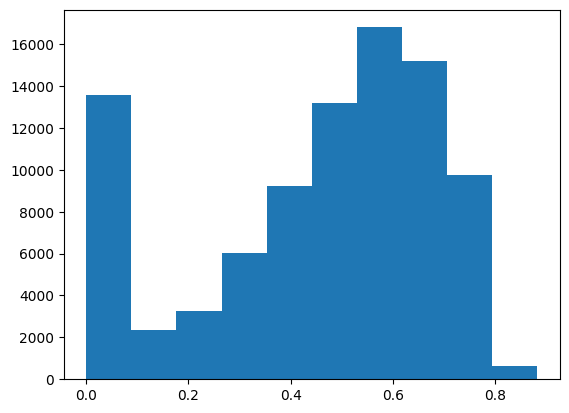

In [33]:
plt.hist(test_pred_total_mean)

In [34]:
test_pred_total_mean = np.mean(test_pred_total, axis=(0))
sample_submission = pd.read_csv('../sample_submission.csv')
sample_submission['probability'] = test_pred_total_mean
sample_submission.to_csv('CODE_recentgit_lgbmcat_cpu_mac_sunghyun+StandardScaler-removefeatures.csv', index=False)